## Import external libraries

In [53]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import torch
import copy
from collections import deque
statespace_size = 13

# Define functions necessary for Deep-q-learning

The function "prepare_torch" needs to be called once and only once at the start of your program to initialise PyTorch and generate the two Q-networks. It returns the target model (for testing).

In [54]:
def prepare_torch(statespace_size=13):
  global model, model2
  global optimizer
  global loss_fn
  l1 = statespace_size
  l2 = 24
  l3 = 24
  l4 = 4
  model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4))
  model2 = copy.deepcopy(model)
  model2.load_state_dict(model.state_dict())
  loss_fn = torch.nn.MSELoss()
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return model2



The function "update_target" copies the state of the prediction network to the target network. You need to use this in regular intervals.

In [55]:
def update_target():
  global model, model2
  model2.load_state_dict(model.state_dict())

The function "get_qvals" returns a numpy list of qvals for the state given by the argument _based on the prediction network_.

In [56]:
def get_qvals(state):
  state1 = torch.from_numpy(state).float()
  qvals_torch = model(state1)
  qvals = qvals_torch.data.numpy()
  return qvals

The function "get_maxQ" returns the maximum q-value for the state given by the argument _based on the target network_.

In [57]:
def get_maxQ(s):
  return torch.max(model2(torch.from_numpy(s).float())).float()

The function "train_one_step_new" performs a single training step. It returns the current loss (only needed for debugging purposes). Its parameters are three parallel lists: a minibatch of states, a minibatch of actions, a minibatch of the corresponding TD targets and the discount factor.

In [58]:
def train_one_step(states, actions, targets, gamma):
    # pass to this function: state1_batch, action_batch, TD_batch
    global model, model2
    
    # Reshape the states to be a 2D tensor with shape (batch_size, state_size)
    state1_batch = torch.stack([torch.from_numpy(s).float() for s in states])
    action_batch = torch.Tensor(actions)
    
    Q1 = model(state1_batch)
    X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
    Y = torch.tensor(targets)
    loss = loss_fn(X, Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# Implementing Simple Grid World

## Agent class

In [70]:
class Agent:
    def __init__(self, position, agent_id):
        """
        Initialize an agent with a position in the grid.
        
        Args:
            position (tuple): Initial (x, y) position of the agent
            agent_id (int): Unique identifier for the agent
        """
        self.position = position
        self.has_package = False
        self.agent_id = agent_id
        self.direction = None  # 'to_b' or 'to_a'
    
    def get_state(self, package_position, opposite_agents):
        """
        Return the agent's state as a numpy array for DQN.
        - agent_x, agent_y
        - package_x, package_y
        - has_package (0/1)
        - 8 binary values for opposite-direction agents in neighborhood
        """
        state = [
            self.position[0], self.position[1],
            package_position[0], package_position[1],
            1.0 if self.has_package else 0.0
        ]
        # Add the 8 neighborhood values (convert bools to float)
        state.extend([1.0 if x else 0.0 for x in opposite_agents])
        return np.array(state, dtype=np.float32)

    def update_direction(self):
        """
        Update the agent's direction based on whether it has a package
        """
        self.direction = 'to_b' if self.has_package else 'to_a'
    
    def move(self, action, grid_size):
        """
        Move the agent according to the given action.
        
        Args:
            action (str): One of "up", "down", "left", "right"
            grid_size (int): Size of the grid
        """
        x, y = self.position

        # "up" means decreasing row (x), "down" means increasing row (x)
        # "left" means decreasing column (y), "right" means increasing column (y)
        if action == "up" and x > 0:
            self.position = (x - 1, y)
        elif action == "down" and x < grid_size - 1:
            self.position = (x + 1, y)
        elif action == "left" and y > 0:
            self.position = (x, y - 1)
        elif action == "right" and y < grid_size - 1:
            self.position = (x, y + 1)



## Environment Class

In [71]:
class MultiAgentEnvironment:
    def __init__(self, grid_size=5, num_agents=4):
        self.grid_size = grid_size
        self.num_agents = num_agents
        self.grid = np.zeros((grid_size, grid_size), dtype=object)
        
        # Randomly place A and B
        positions = self.get_random_positions(2)
        self.package_position = positions[0]  # A location
        self.target_position = positions[1]   # B location
        
        # Initialize agents at either A or B
        self.agents = []
        for i in range(num_agents):
            start_position = random.choice([self.package_position, self.target_position])
            agent = Agent(start_position, i)
            agent.direction = 'to_b' if start_position == self.package_position else 'to_a'
            self.agents.append(agent)
            
        self.update_grid()
        self.current_agent_idx = 0

    def get_random_positions(self, n, exclude=None):
        if exclude is None:
            exclude = []
        positions = []
        while len(positions) < n:
            pos = (random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1))
            if pos not in exclude and pos not in positions:
                positions.append(pos)
        return positions
    
    def get_opposite_agents(self, agent):
        x, y = agent.position
        neighbors = []
        for dx, dy in [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]:
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
                has_opposite = False
                for other_agent in self.agents:
                    if (other_agent.position == (new_x, new_y) and 
                        other_agent.direction != agent.direction):
                        has_opposite = True
                        break
                neighbors.append(has_opposite)
            else:
                neighbors.append(False)
        return neighbors

    def is_head_on_collision(self, agent, new_position):
        # Don't check for collisions at A or B locations
        if new_position == self.package_position or new_position == self.target_position:
            return False
        for other_agent in self.agents:
            if other_agent.position == new_position and other_agent != agent:
                return agent.direction != other_agent.direction
        return False

    def move_agent(self, agent, action):
        x, y = agent.position
        possible_moves = {
            "up": (-1, 0),
            "down": (1, 0),
            "left": (0, -1),
            "right": (0, 1)
        }
        dx, dy = possible_moves[action]
        new_x, new_y = x + dx, y + dy
        new_pos = (new_x, new_y)

        # Wall collision
        if not (0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size):
            return -5, {"valid": False, "collision": False, "delivery": False}

        # Head-on collision
        if self.is_head_on_collision(agent, new_pos):
            return -10, {"valid": False, "collision": True, "delivery": False}

        # Move agent
        agent.position = new_pos

        # Handle package pickup at A
        reward = -1  # Base step cost
        if agent.position == self.package_position and not agent.has_package:
            agent.has_package = True
            agent.direction = 'to_b'
            reward += 10  # Reward for picking up package

        # Handle package delivery at B
        delivery = False
        if agent.position == self.target_position and agent.has_package:
            agent.has_package = False
            agent.direction = 'to_a'
            reward += 50  # Reward for successful delivery
            delivery = True

        self.update_grid()
        return reward, {
            "valid": True,
            "collision": False,
            "delivery": delivery
        }
    
    def step(self, action):
        current_agent = self.agents[self.current_agent_idx]
        reward, info = self.move_agent(current_agent, action)
        self.current_agent_idx = (self.current_agent_idx + 1) % self.num_agents
        next_agent = self.agents[self.current_agent_idx]
        observation = {
            'state': next_agent.get_state(self.package_position, self.get_opposite_agents(next_agent))
        }
        return observation, reward, info

    def update_grid(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=object)
        self.grid[self.package_position] = "A"
        self.grid[self.target_position] = "B"
        for agent in self.agents:
            x, y = agent.position
            if agent.has_package:
                self.grid[x, y] = f"AG{agent.agent_id}(A)"
            else:
                self.grid[x, y] = f"AG{agent.agent_id}"

    def reset(self):
        positions = self.get_random_positions(2)
        self.package_position = positions[0]
        self.target_position = positions[1]
        for agent in self.agents:
            start_position = random.choice([self.package_position, self.target_position])
            agent.position = start_position
            agent.has_package = False
            agent.direction = 'to_b' if start_position == self.package_position else 'to_a'
        self.update_grid()
        self.current_agent_idx = 0
            

## Shared Replay Buffer

In [72]:
class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)

## Visualizer

In [73]:
class MultiAgentVisualizer:
    def __init__(self, env):
        """
        Initialize the visualizer with an environment.
        
        Args:
            env (MultiAgentEnvironment): The grid world environment to visualize
        """
        self.env = env
        self.colors = {
            "agent_to_b": "blue",      # Agents moving towards B
            "agent_to_a": "green",     # Agents moving towards A
            "package": "yellow",       # Location A
            "target": "red",          # Location B
            "agent_with_package": "purple"
        }
        
    def render(self, title=None, show=True, save_path=None):
        """
        Render the current state of the environment.
        """
    
        fig, ax = plt.subplots(figsize=(7, 7))
        
        # Set plot limits
        ax.set_xlim(-0.5, self.env.grid_size - 0.5)
        ax.set_ylim(-0.5, self.env.grid_size - 0.5)
        
        # Draw grid lines
        for i in range(self.env.grid_size + 1):
            ax.axhline(i - 0.5, color='black', linestyle='-', alpha=0.2)
            ax.axvline(i - 0.5, color='black', linestyle='-', alpha=0.2)
        
        # Draw package location (A)
        x, y = self.env.package_position
        package = patches.Rectangle((y - 0.4, x - 0.4), 0.8, 0.8, 
                                color=self.colors["package"], alpha=0.7)
        ax.add_patch(package)
        ax.text(y, x, "A", ha='center', va='center', fontsize=12)
        
        # Draw target location (B)
        x, y = self.env.target_position
        target = patches.Rectangle((y - 0.4, x - 0.4), 0.8, 0.8, 
                                color=self.colors["target"], alpha=0.7)
        ax.add_patch(target)
        ax.text(y, x, "B", ha='center', va='center', fontsize=12)
        
        # Draw agents
        for agent in self.env.agents:
            x, y = agent.position
            # Choose color based on direction and package status
            if agent.has_package:
                color = self.colors["agent_with_package"]
            else:
                color = self.colors["agent_to_b"] if agent.direction == 'to_b' else self.colors["agent_to_a"]
            
            agent_circle = patches.Circle((y, x), 0.3, color=color, alpha=0.8)
            ax.add_patch(agent_circle)
            label = f"{agent.agent_id}"
            ax.text(y, x, label, ha='center', va='center', fontsize=10, color='white')
        
        if title:
            ax.set_title(title)
        ax.set_xlabel("Column")
        ax.set_ylabel("Row")
        
        ax.set_xticks(range(self.env.grid_size))
        ax.set_yticks(range(self.env.grid_size))
        
        # Invert y-axis to match grid coordinates (0,0 at top-left)
        ax.invert_yaxis()
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        
        if show:
            plt.show()
        else:
            plt.close()
    
        return fig

## DeepQ Learning Training methods

In [74]:
def train_multi_agent_system_with_budgets(
    step_budget=1_500_000,
    collision_budget=4_000,
    walltime_budget_seconds=600,  # 10 minutes
    reset_interval=200  # how often to randomize env for diversity
):
    # --- 1. Initialize everything ---
    env = MultiAgentEnvironment(grid_size=5, num_agents=4)
    visualizer = MultiAgentVisualizer(env)
    statespace_size = 13
    prepare_torch(statespace_size)

    replay_buffer = ReplayBuffer(capacity=100_000)
    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay = 0.9995
    gamma = 0.99
    batch_size = 128

    total_steps = 0
    total_collisions = 0
    start_time = time.time()
    deliveries = 0
    rewards = 0

    # For optional progress tracking
    rewards_history = []
    deliveries_history = []
    collisions_history = []
    progress_interval = 10000  # Print progress every N steps

    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, 3)  # 4 actions: 0=up, 1=down, 2=left, 3=right
        qvals = get_qvals(state)
        return int(np.argmax(qvals))

    # --- 2. Main training loop ---
    while (total_steps < step_budget and 
           total_collisions < collision_budget and 
           (time.time() - start_time) < walltime_budget_seconds):

        # Optionally reset environment every N steps for diversity
        if total_steps % reset_interval == 0:
            env.reset()

        current_agent = env.agents[env.current_agent_idx]
        state = current_agent.get_state(env.package_position, env.get_opposite_agents(current_agent))
        action = select_action(state, epsilon)
        action_map = {0: "up", 1: "down", 2: "left", 3: "right"}
        action_str = action_map[action]
        next_observation, reward, info = env.step(action_str)
        next_state = next_observation['state']
        done = False  # Always False for infinite-horizon

        # --- 3. Store experience in replay buffer ---
        replay_buffer.push(state, action, reward, next_state, done)

        # --- 4. Sample minibatch and train DQN ---
        if len(replay_buffer) > batch_size:
            states, actions, rewards_batch, next_states, dones = replay_buffer.sample(batch_size)
            next_max_q = [get_maxQ(s) for s in next_states]
            targets = [r + gamma * nq for r, nq in zip(rewards_batch, next_max_q)]
            loss = train_one_step(states, actions, targets, gamma)

        # --- 5. Decay epsilon ---
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # --- 6. Update metrics ---
        rewards += reward
        if info["delivery"]:
            deliveries += 1
        if info["collision"]:
            total_collisions += 1
        total_steps += 1

        # --- 7. Optionally print progress ---
        if total_steps % progress_interval == 0:
            elapsed = time.time() - start_time
            print(f"Steps: {total_steps}, Collisions: {total_collisions}, Deliveries: {deliveries}, Elapsed: {elapsed:.1f}s")
            rewards_history.append(rewards)
            deliveries_history.append(deliveries)
            collisions_history.append(total_collisions)
            visualizer.render(title=f"Step {total_steps}", show=True)

    print(f"Training finished: Steps={total_steps}, Collisions={total_collisions}, Deliveries={deliveries}, Time={time.time() - start_time:.1f}s")
    return {
        'rewards': rewards_history,
        'deliveries': deliveries_history,
        'collisions': collisions_history,
        'env': env
    }

# Function to plot training metrics
def plot_training_metrics(metrics, progress_interval=10000):
    """
    Plot the training metrics.

    Args:
        metrics (dict): Dictionary containing training metrics
        progress_interval (int): Number of steps between each metric record
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    # X-axis: step intervals
    x = [i * progress_interval for i in range(len(metrics['rewards']))]

    # Plot rewards
    ax1.plot(x, metrics['rewards'])
    ax1.set_title('Cumulative Reward')
    ax1.set_xlabel('Environment Steps')
    ax1.set_ylabel('Reward')

    # Plot deliveries
    ax2.plot(x, metrics['deliveries'])
    ax2.set_title('Cumulative Deliveries')
    ax2.set_xlabel('Environment Steps')
    ax2.set_ylabel('Number of Deliveries')

    # Plot collisions
    ax3.plot(x, metrics['collisions'])
    ax3.set_title('Cumulative Collisions')
    ax3.set_xlabel('Environment Steps')
    ax3.set_ylabel('Number of Collisions')

    plt.tight_layout()
    plt.show()

## DeepQ Learning Training

In [75]:
# Train the system
metrics = train_multi_agent_system_with_budgets()
torch.save(model.state_dict(), "dqn_model.pth")

# Plot the training metrics
plot_training_metrics(metrics, progress_interval=10000)  # Use the same interval as in training

KeyboardInterrupt: 

## Test the trained agents functions

In [77]:
def test_trained_agents_dqn(env, num_tests=10, steps_per_test=200, render=True, render_delay=0.5, show_all_steps=False):
    """
    Test the trained agents in the multi-agent environment using DQN.
    
    Args:
        env (MultiAgentEnvironment): The environment to test in (should be same as training)
        num_tests (int): Number of test scenarios to run
        steps_per_test (int): Number of steps per test
        render (bool): Whether to render the environment
        render_delay (float): Delay between renders in seconds (for visualization)
        
    Returns:
        dict: Test metrics
    """
    visualizer = MultiAgentVisualizer(env)
    all_deliveries = []
    all_collisions = []
    all_rewards = []

    for test_num in range(num_tests):
        print(f"\nTest {test_num + 1}/{num_tests}")
        env.reset()
        test_deliveries = 0
        test_collisions = 0
        test_reward = 0

        for step in range(steps_per_test):
            current_agent = env.agents[env.current_agent_idx]
            state = current_agent.get_state(env.package_position, env.get_opposite_agents(current_agent))
            # DQN action selection (greedy, no exploration)
            action = int(np.argmax(get_qvals(state)))
            action_map = {0: "up", 1: "down", 2: "left", 3: "right"}
            action_str = action_map[action]
            next_observation, reward, info = env.step(action_str)
            test_reward += reward
            if info["delivery"]:
                test_deliveries += 1
            if info["collision"]:
                test_collisions += 1
            if show_all_steps:
                visualizer.render(
                    title=f"Test {test_num + 1}, Step {step}\n"
                          f"Deliveries: {test_deliveries}, Collisions: {test_collisions}",
                    show=True
                )
            elif render and step % 5 == 0:
                visualizer.render(
                    title=f"Test {test_num + 1}, Step {step}\n"
                          f"Deliveries: {test_deliveries}, Collisions: {test_collisions}",
                    show=True
                )
                plt.pause(render_delay)
        all_deliveries.append(test_deliveries)
        all_collisions.append(test_collisions)
        all_rewards.append(test_reward)
        print(f"Test {test_num + 1} Results: Deliveries={test_deliveries}, Collisions={test_collisions}, Reward={test_reward}")

    avg_deliveries = np.mean(all_deliveries)
    avg_collisions = np.mean(all_collisions)
    avg_reward = np.mean(all_rewards)
    print("\nOverall Test Results:")
    print(f"Average Deliveries per Test: {avg_deliveries:.2f}")
    print(f"Average Collisions per Test: {avg_collisions:.2f}")
    print(f"Average Reward per Test: {avg_reward:.2f}")

    # Plot test results
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
    ax1.bar(range(num_tests), all_deliveries)
    ax1.set_title('Deliveries per Test')
    ax1.set_xlabel('Test Number')
    ax1.set_ylabel('Number of Deliveries')
    ax1.axhline(y=avg_deliveries, color='r', linestyle='--', label='Average')
    ax1.legend()
    ax2.bar(range(num_tests), all_collisions)
    ax2.set_title('Collisions per Test')
    ax2.set_xlabel('Test Number')
    ax2.set_ylabel('Number of Collisions')
    ax2.axhline(y=avg_collisions, color='r', linestyle='--', label='Average')
    ax2.legend()
    ax3.bar(range(num_tests), all_rewards)
    ax3.set_title('Total Reward per Test')
    ax3.set_xlabel('Test Number')
    ax3.set_ylabel('Reward')
    ax3.axhline(y=avg_reward, color='r', linestyle='--', label='Average')
    ax3.legend()
    plt.tight_layout()
    plt.show()

    return {
        'deliveries': all_deliveries,
        'collisions': all_collisions,
        'rewards': all_rewards,
        'avg_deliveries': avg_deliveries,
        'avg_collisions': avg_collisions,
        'avg_reward': avg_reward
    }


## Test

In [ ]:
# Load the model
model.load_state_dict(torch.load("dqn_model.pth"))
model.eval() 
print("DQN model loaded from dqn_model.pth")
env = metrics['env']
test_results = test_trained_agents_dqn(
    env,  # your MultiAgentEnvironment instance
    num_tests=10,
    steps_per_test=200,
    render=True,
    render_delay=0.5,
    show_all_steps=False
)

## Debug Test


Test 1/1


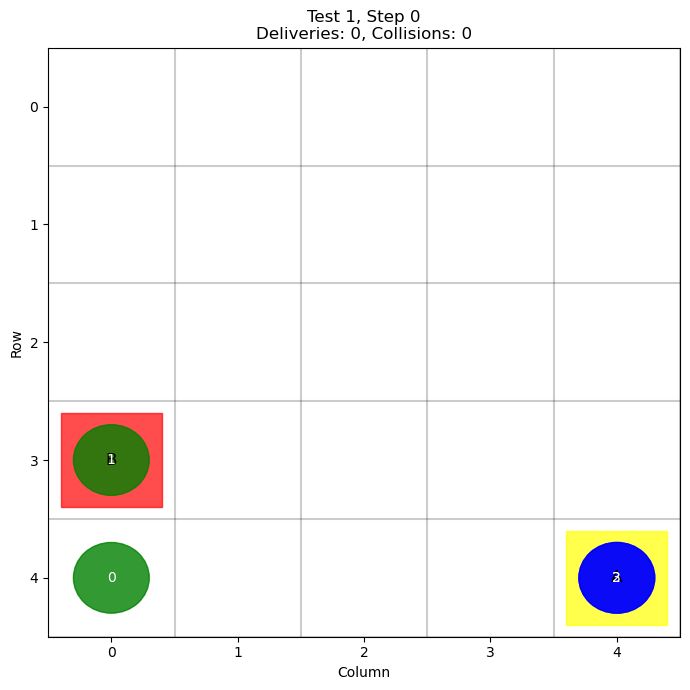

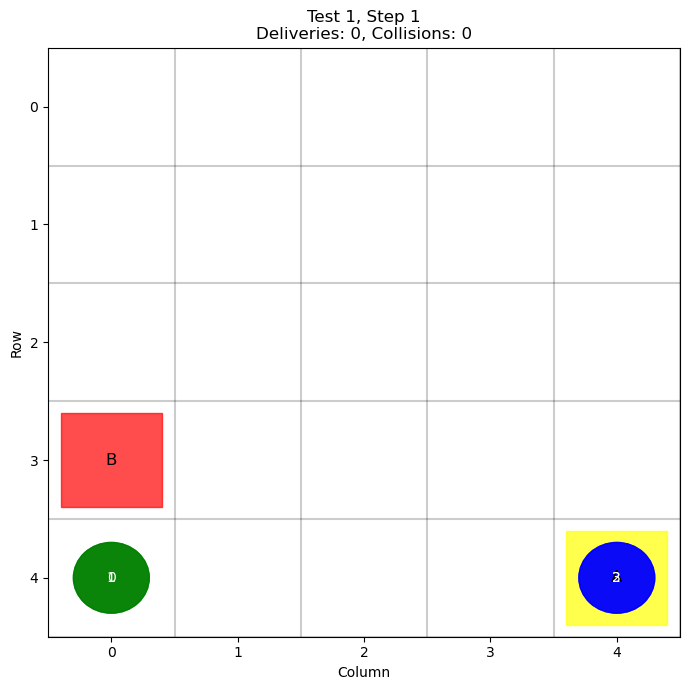

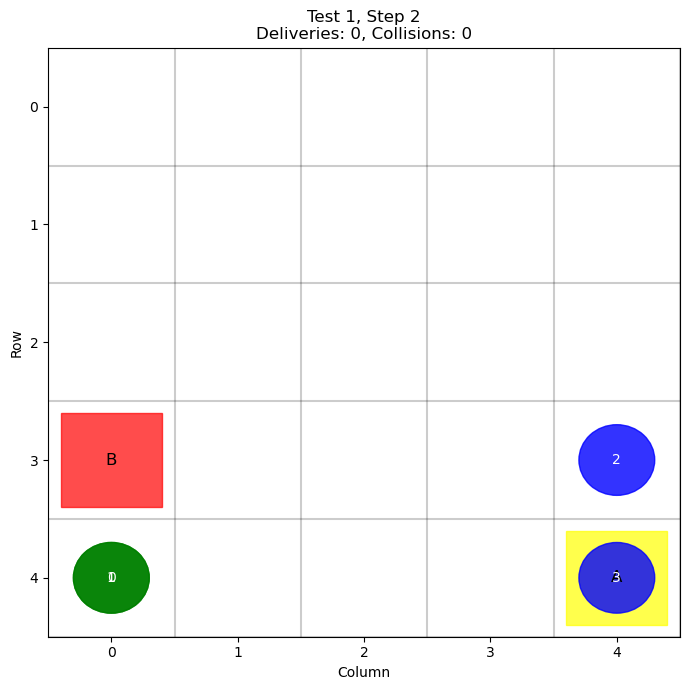

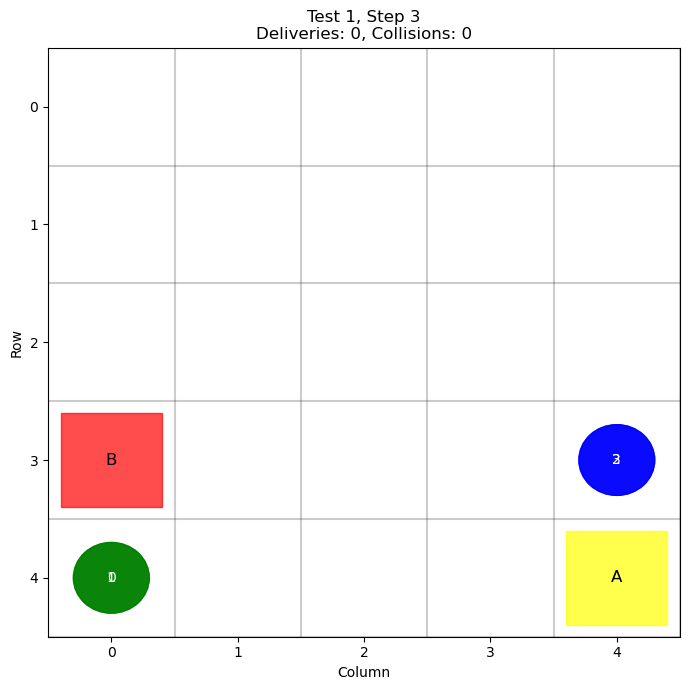

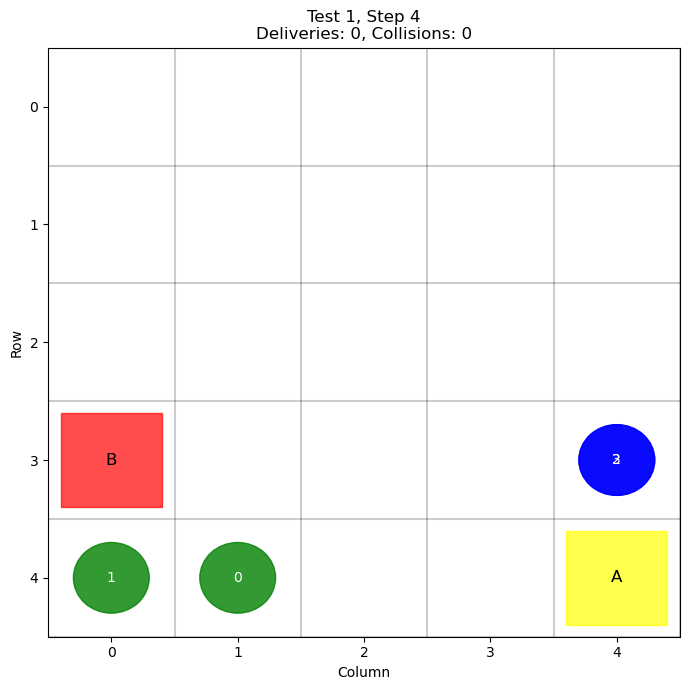

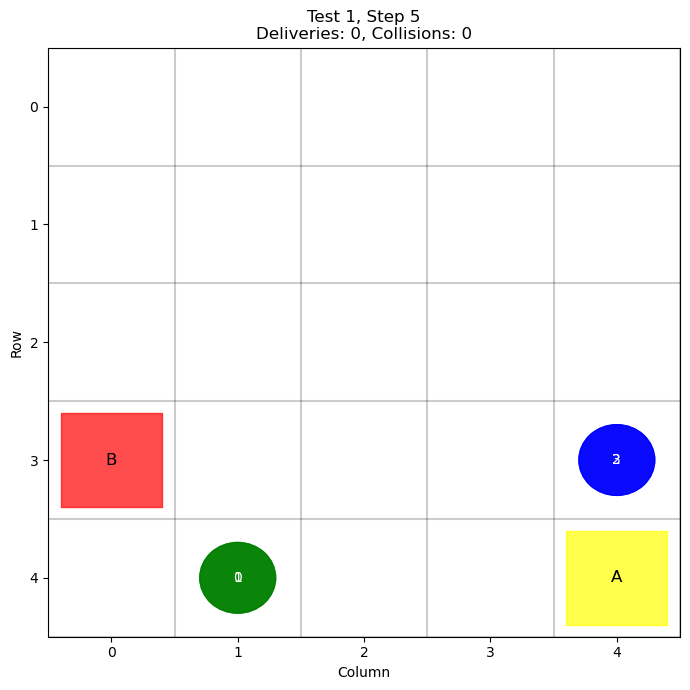

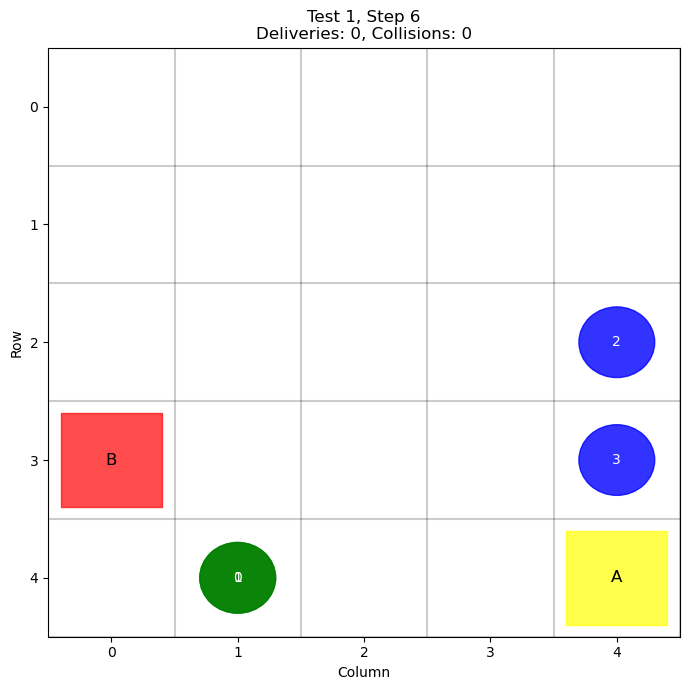

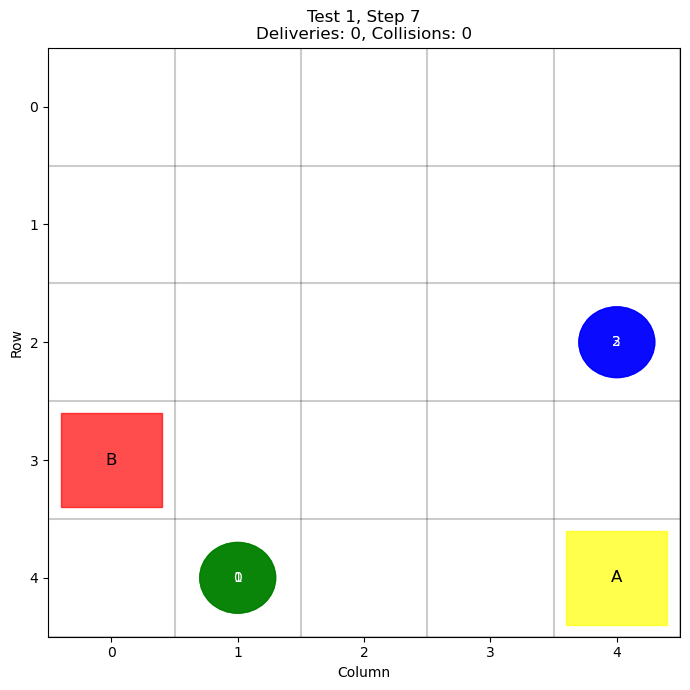

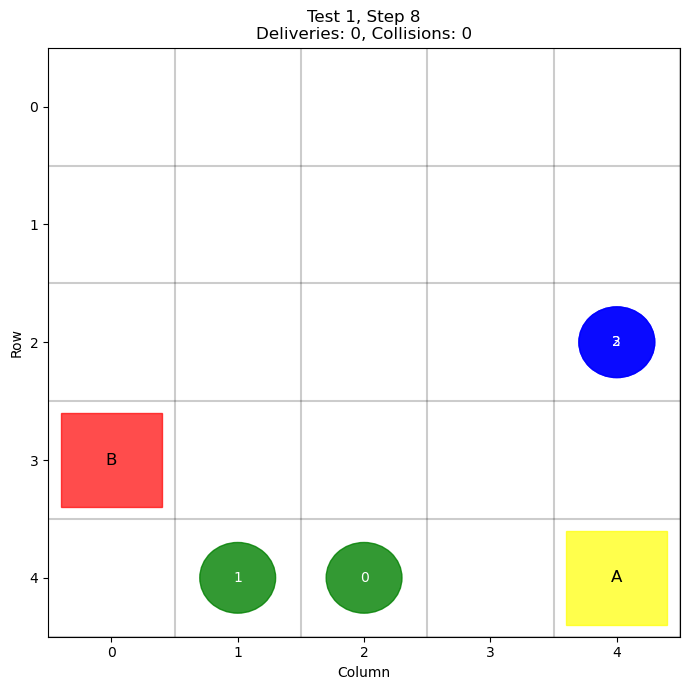

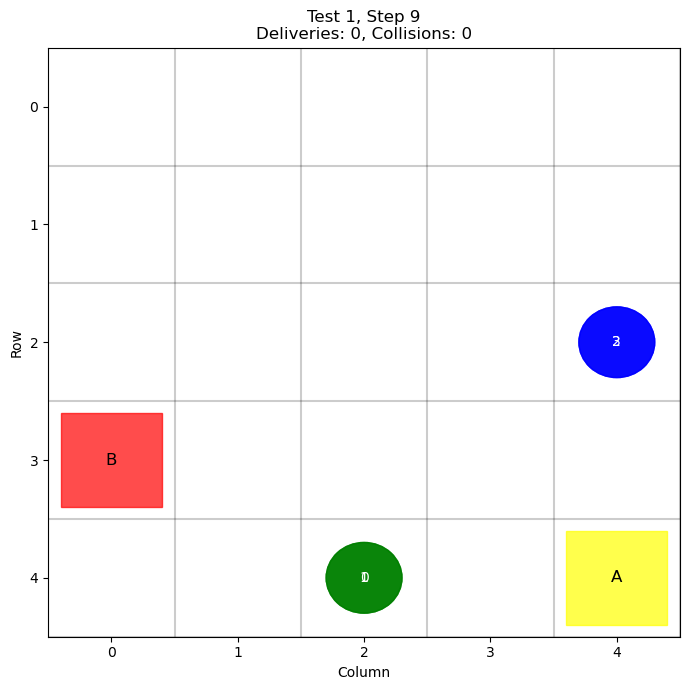

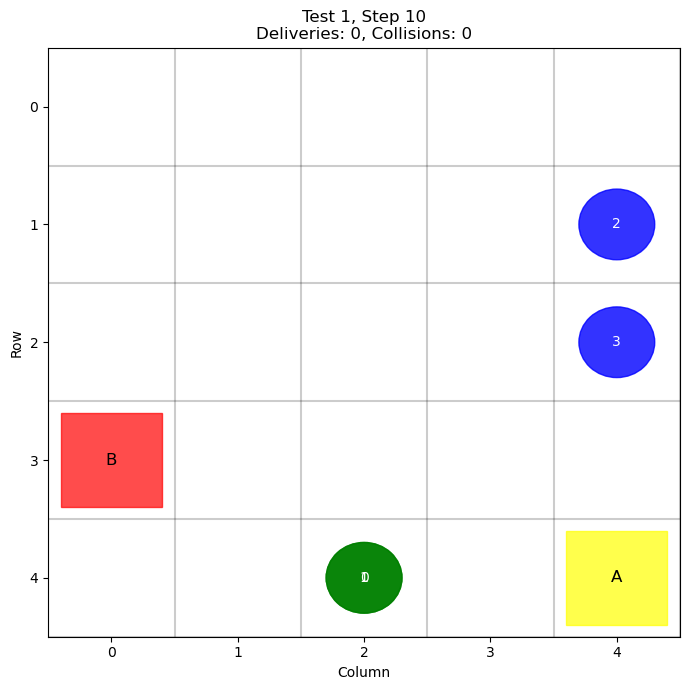

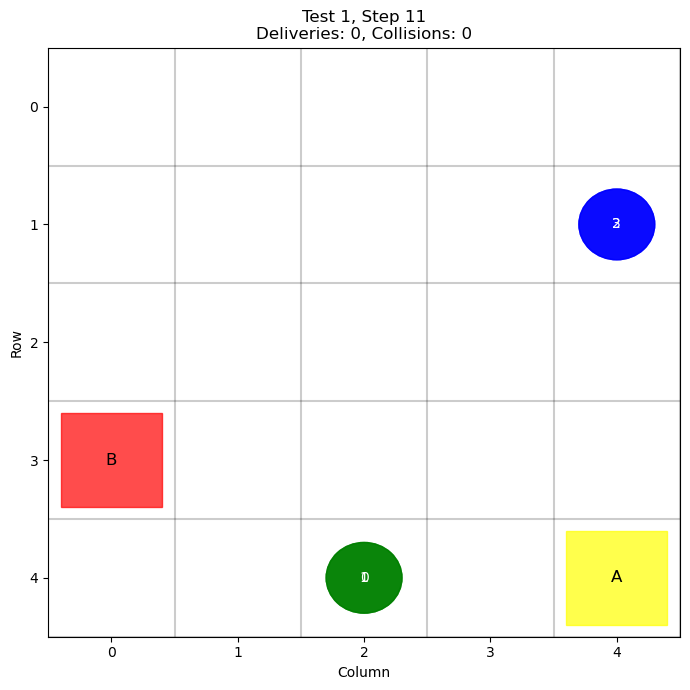

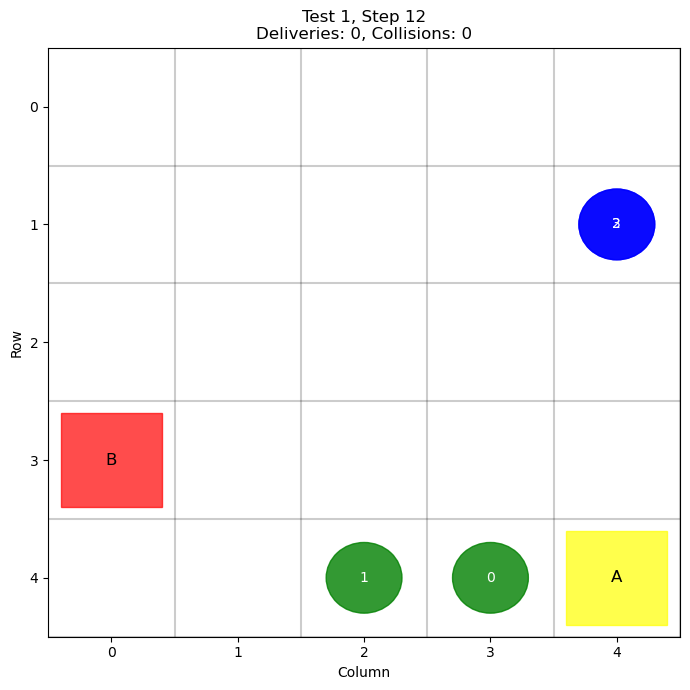

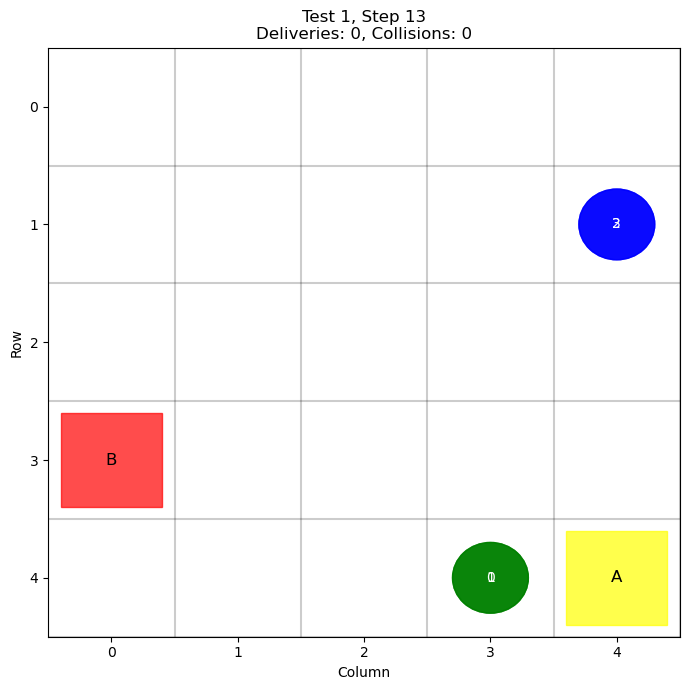

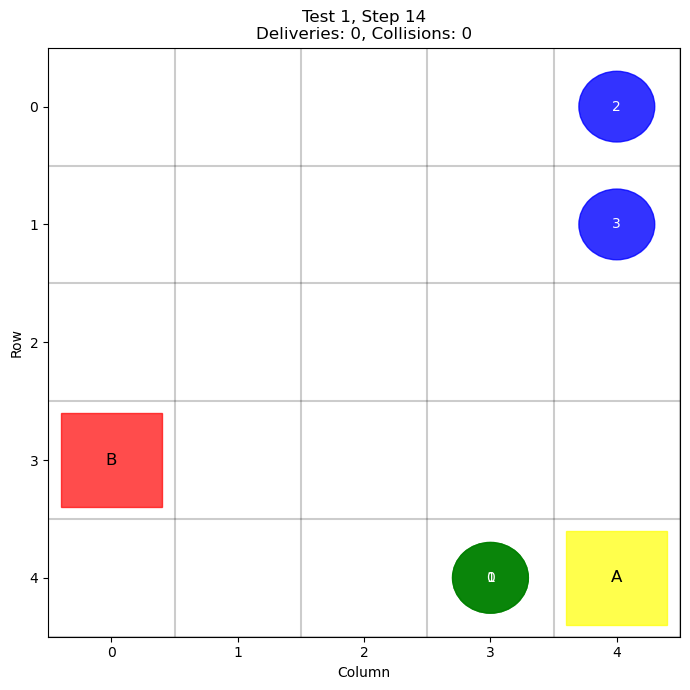

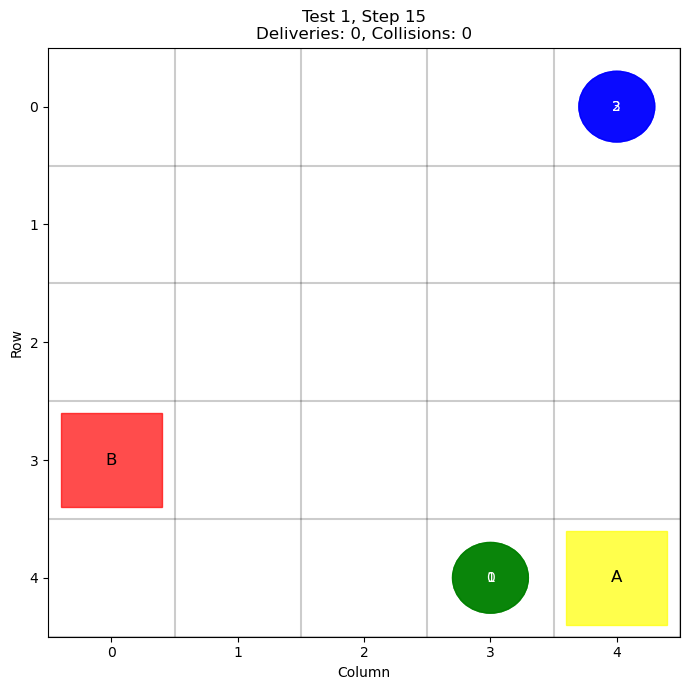

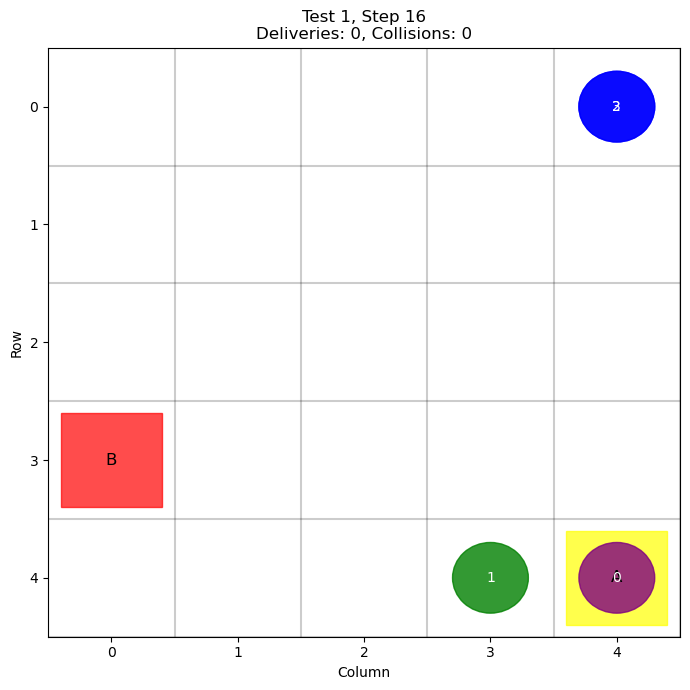

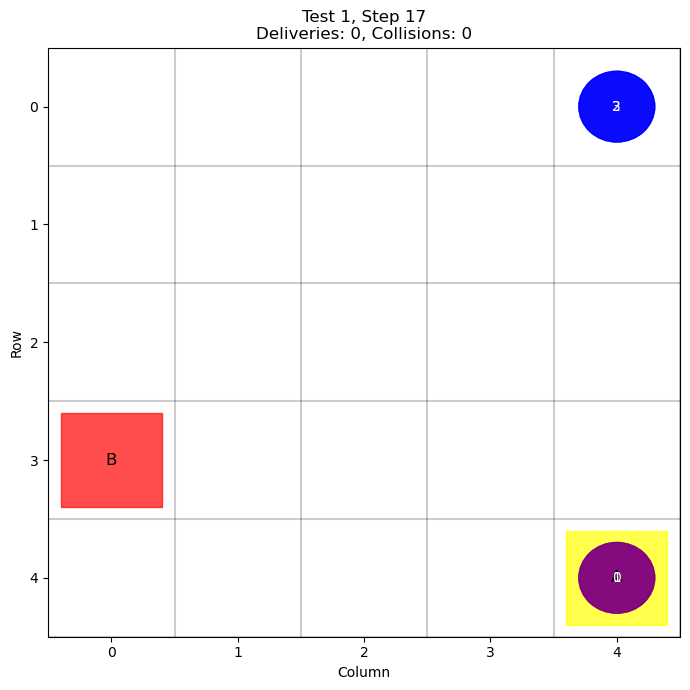

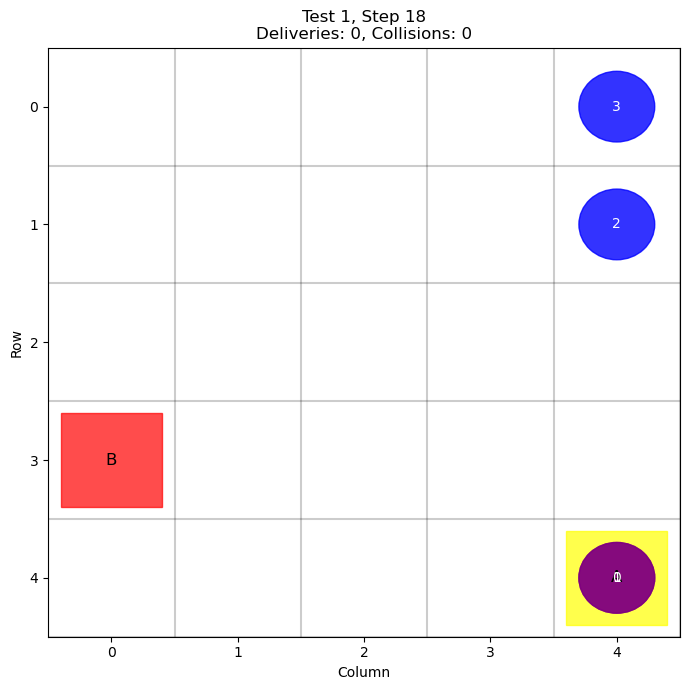

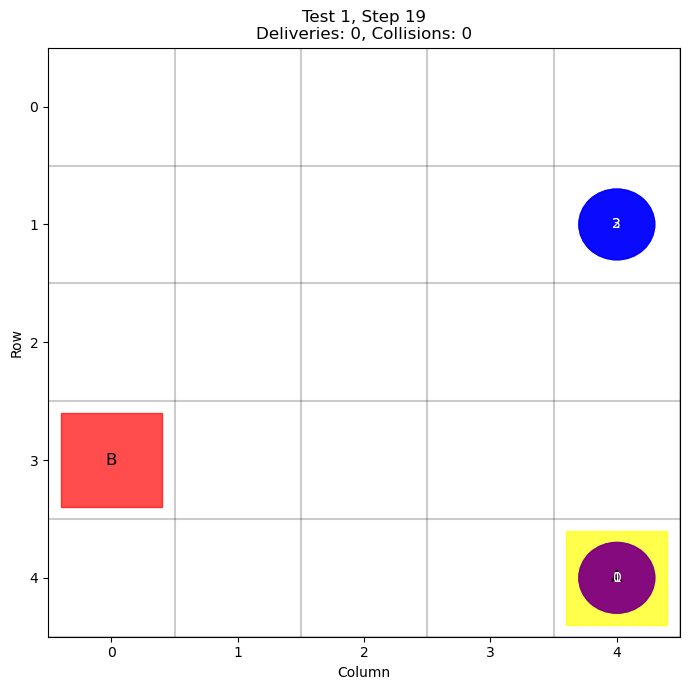

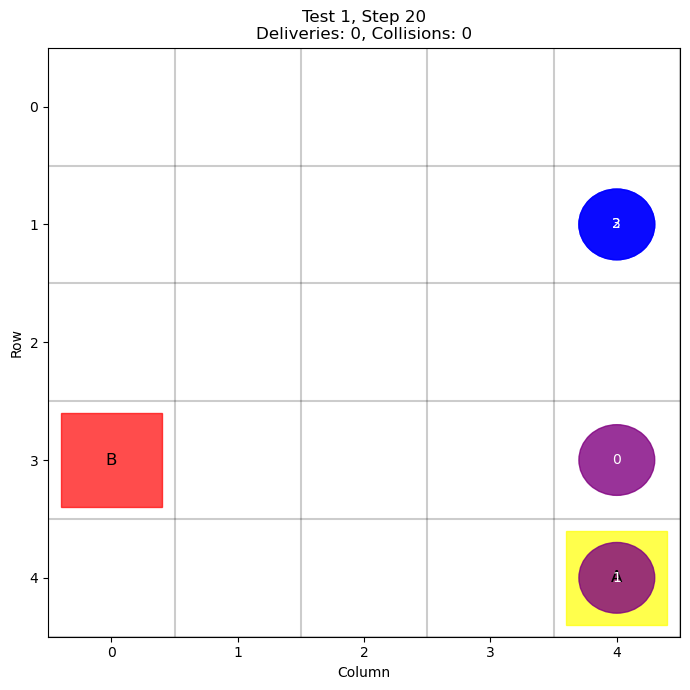

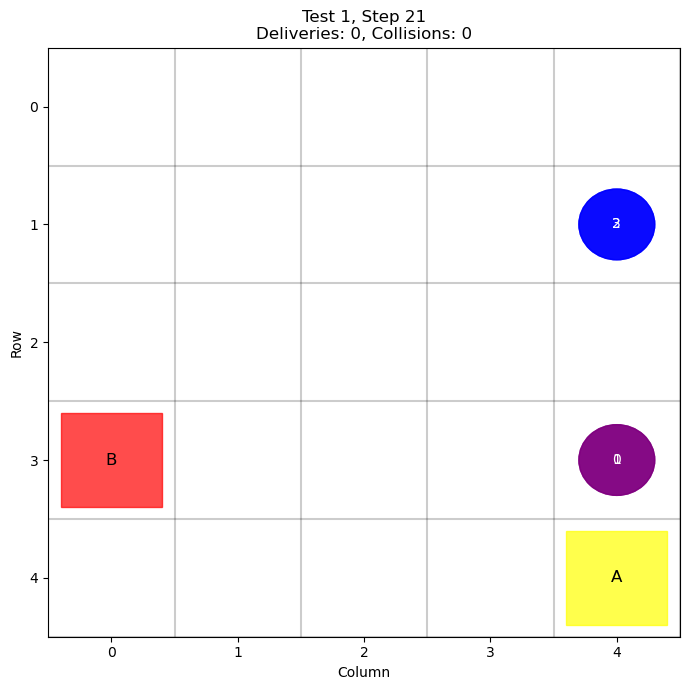

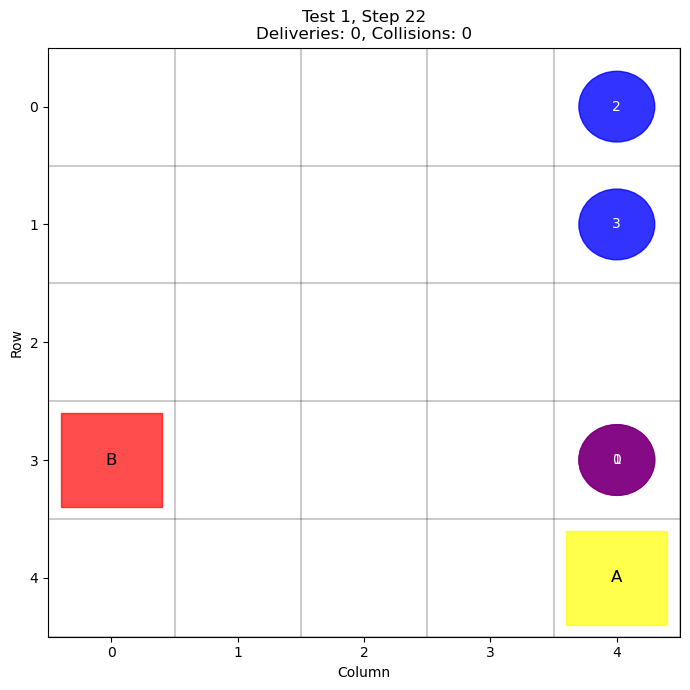

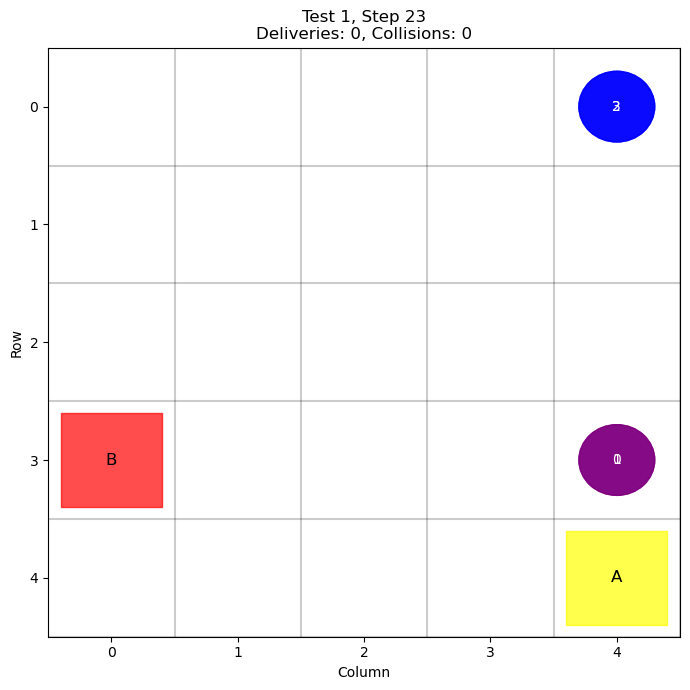

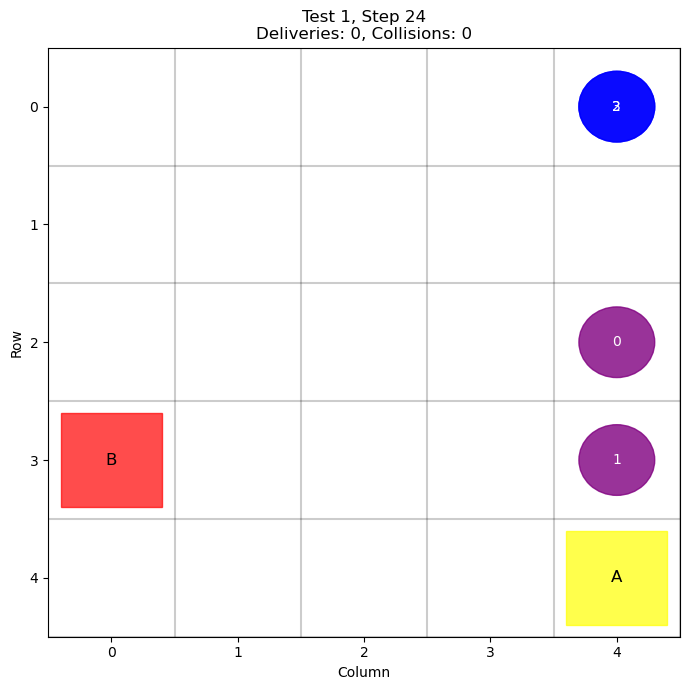

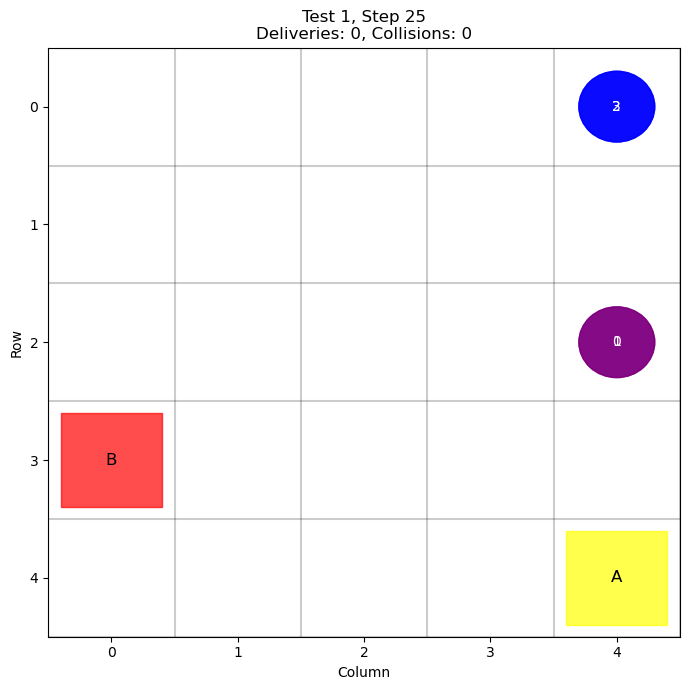

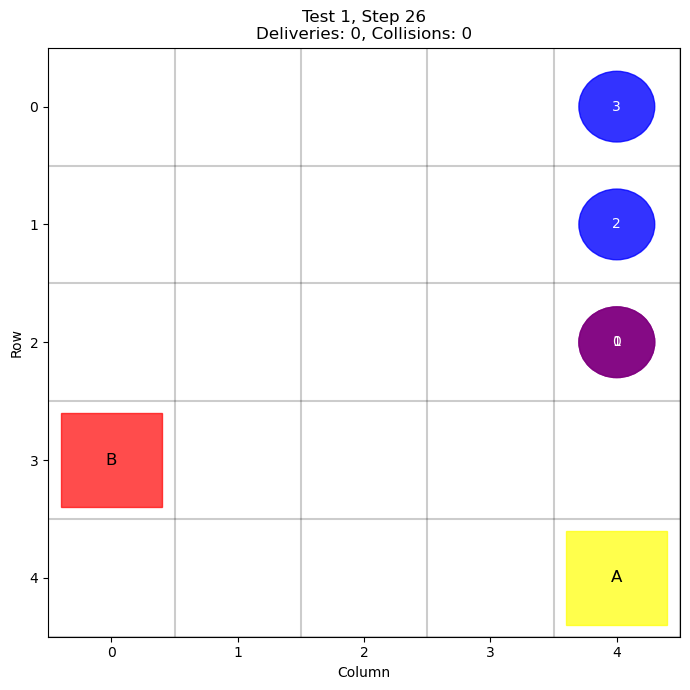

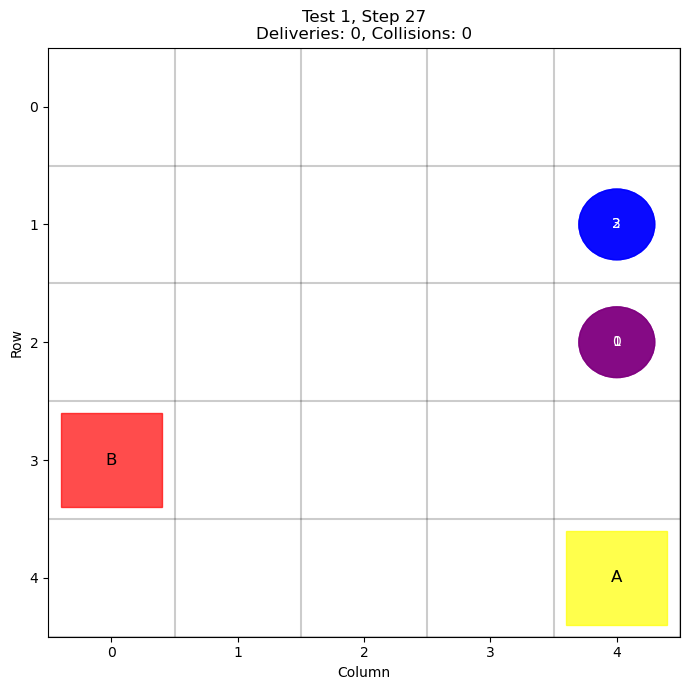

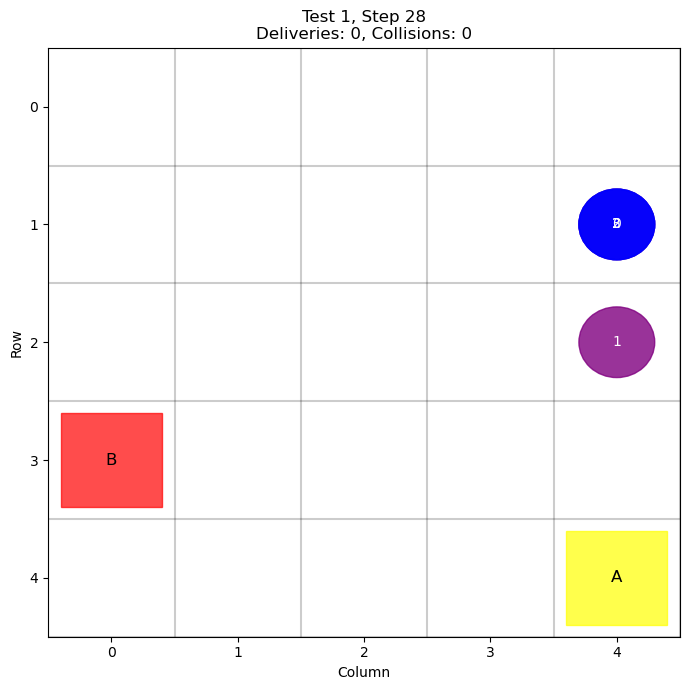

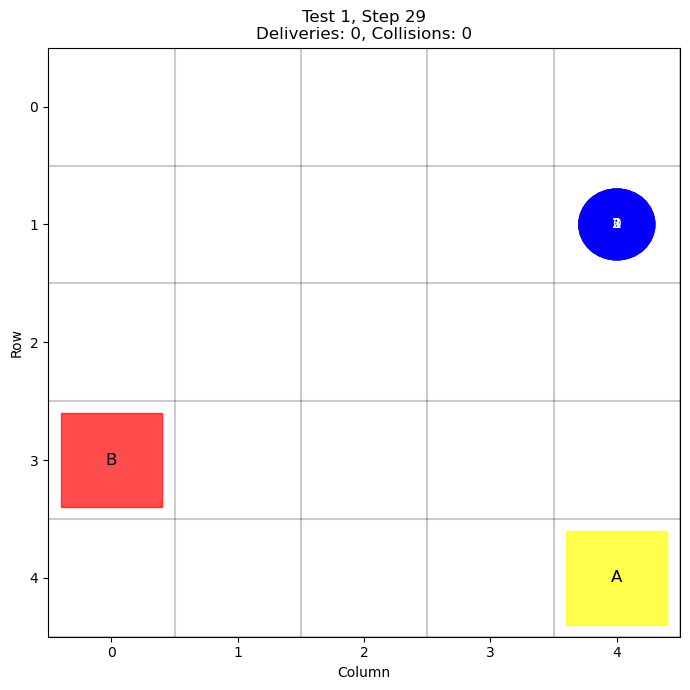

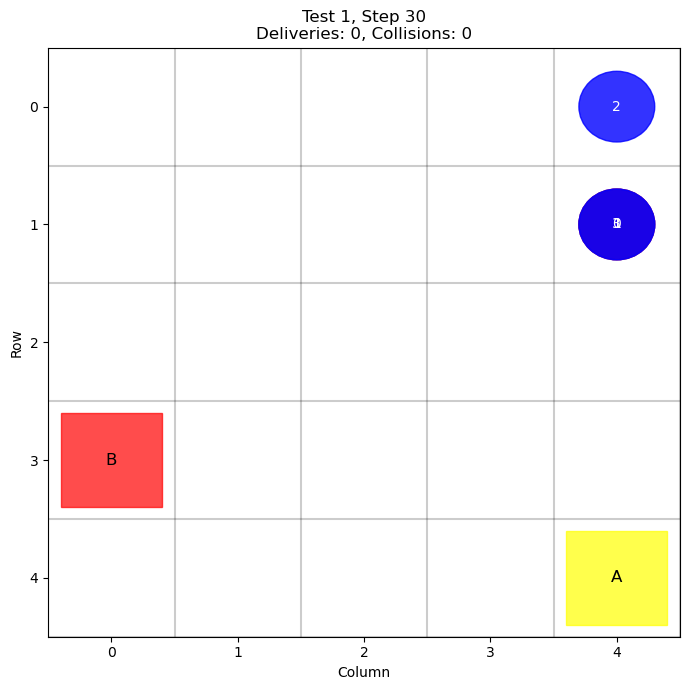

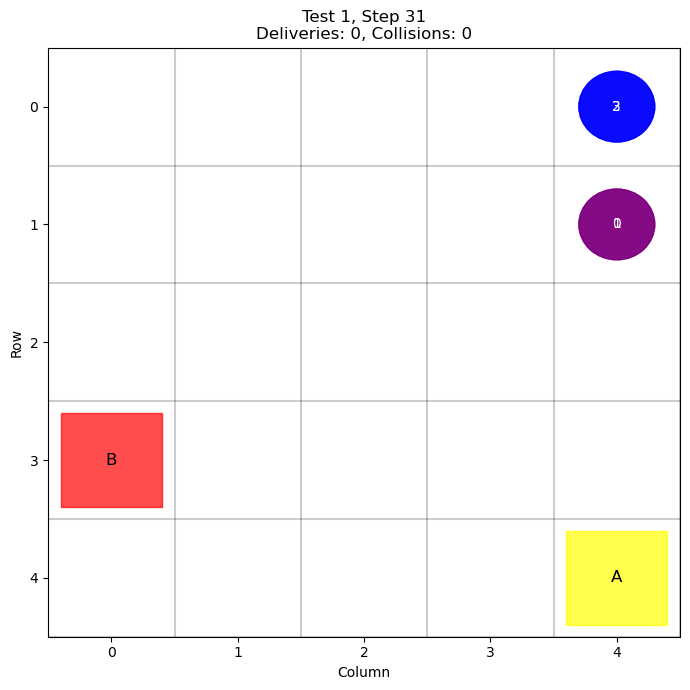

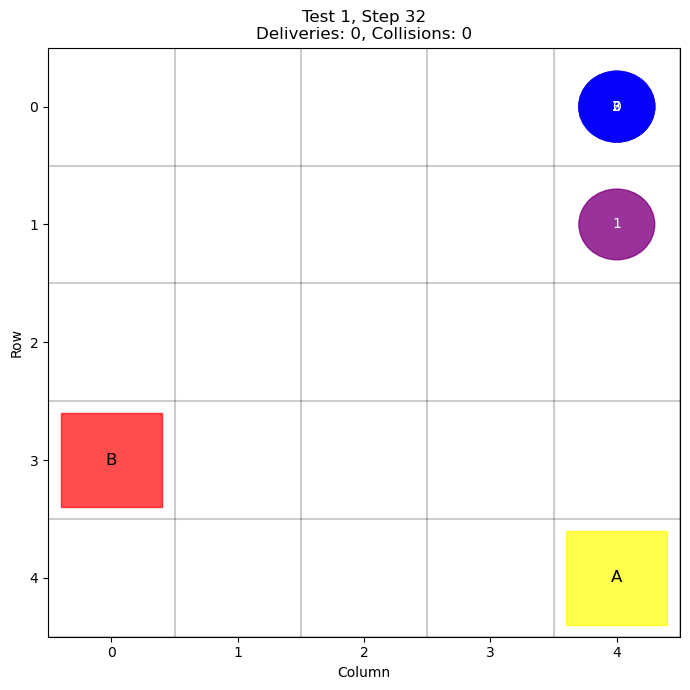

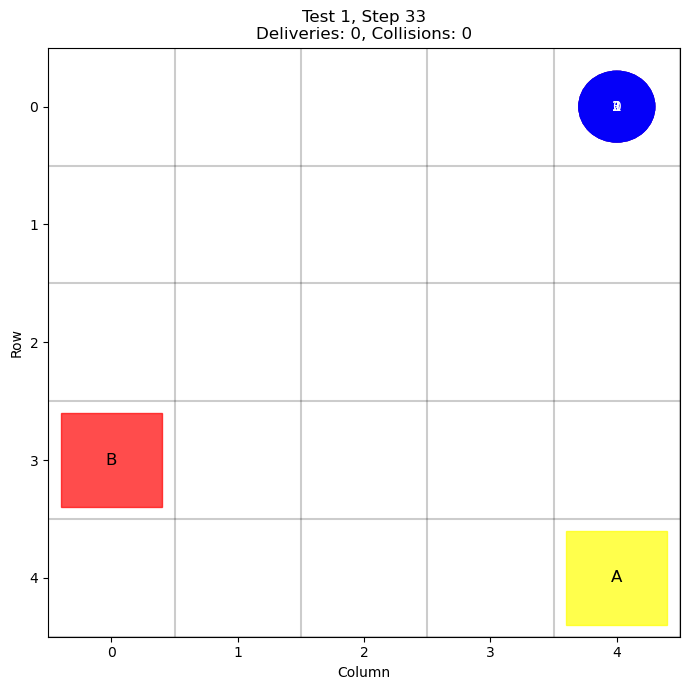

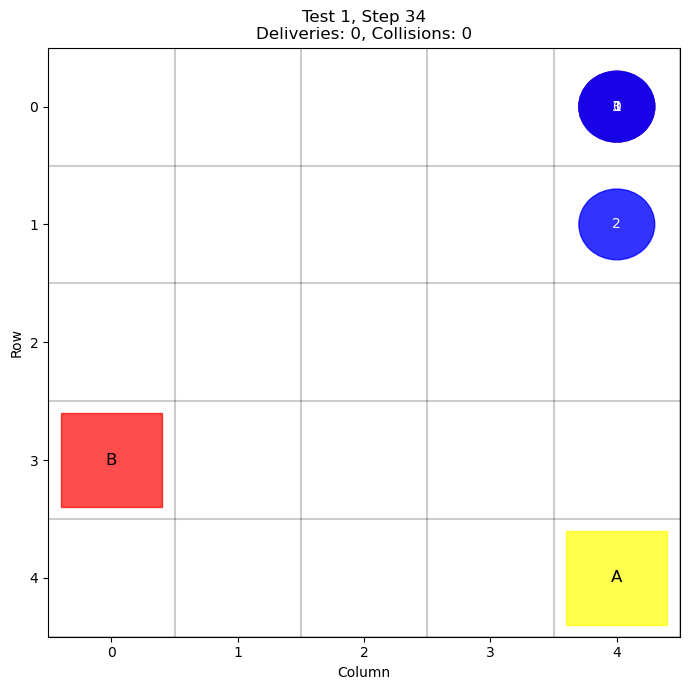

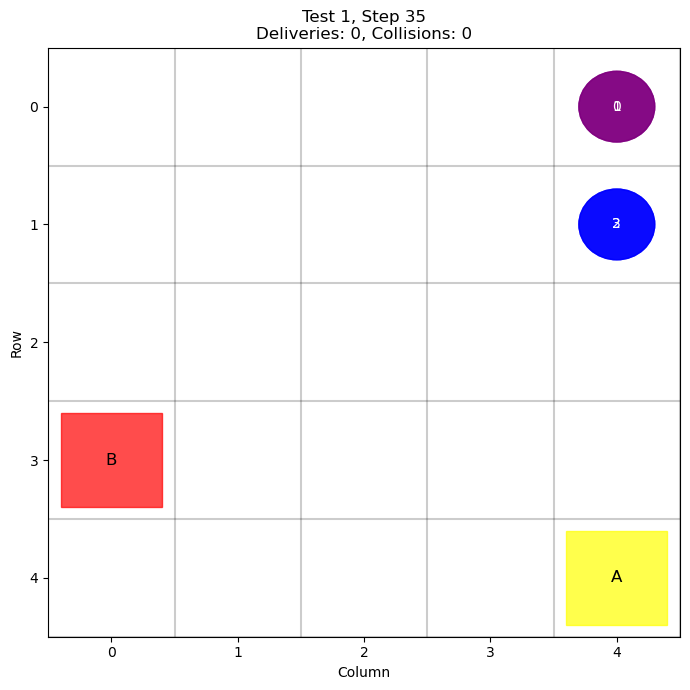

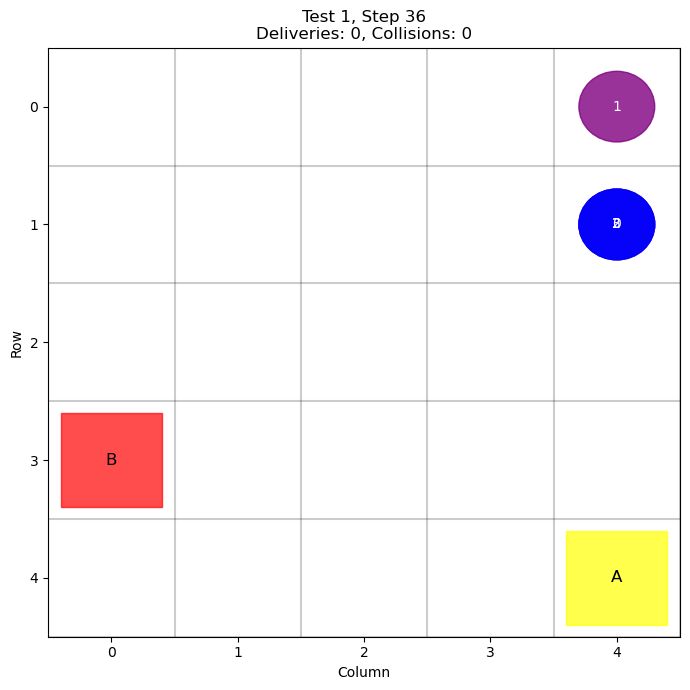

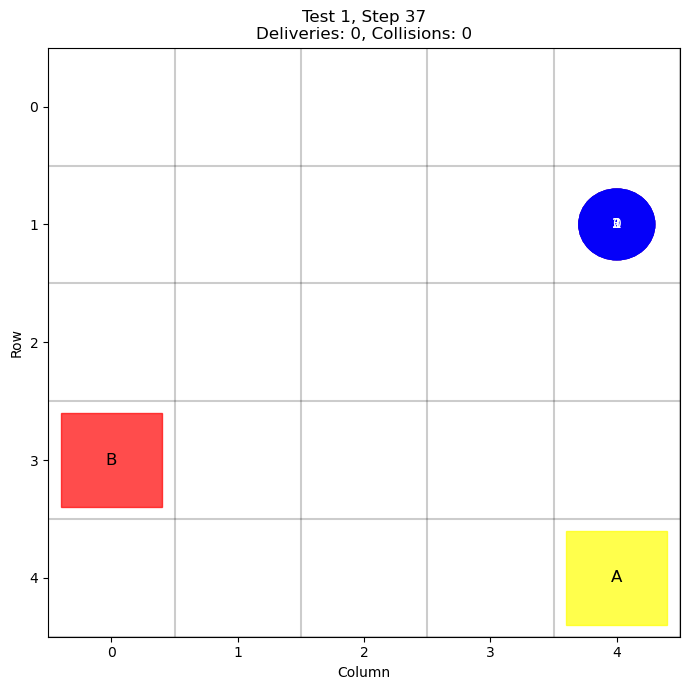

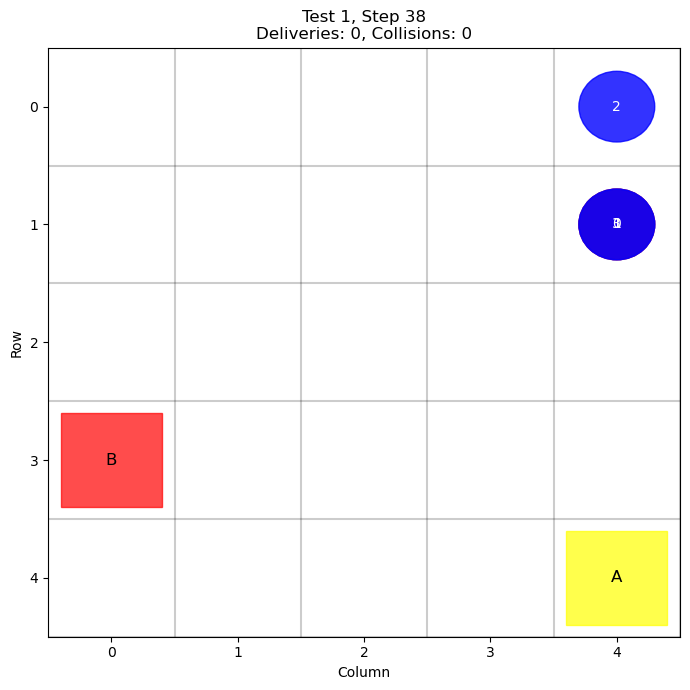

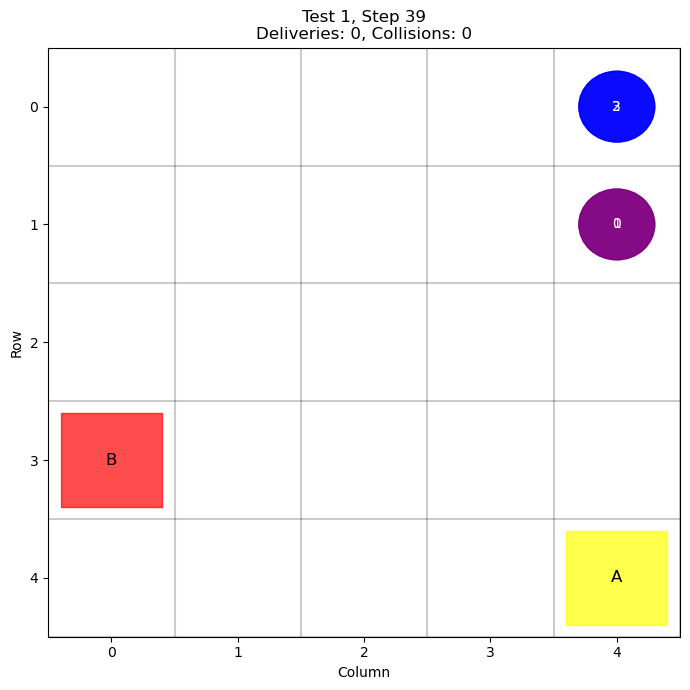

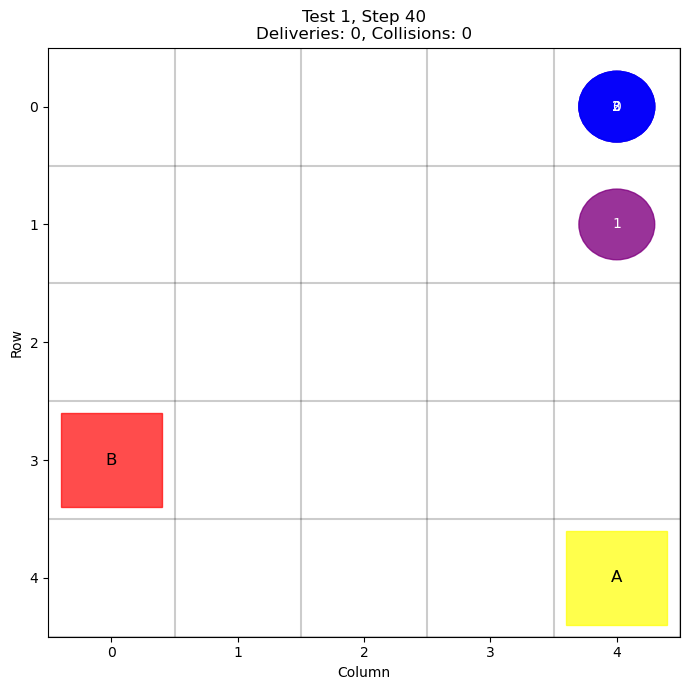

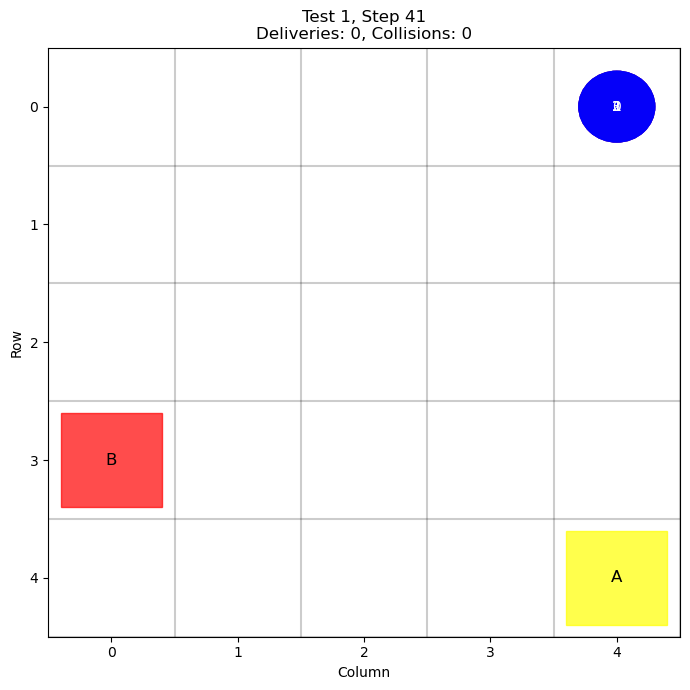

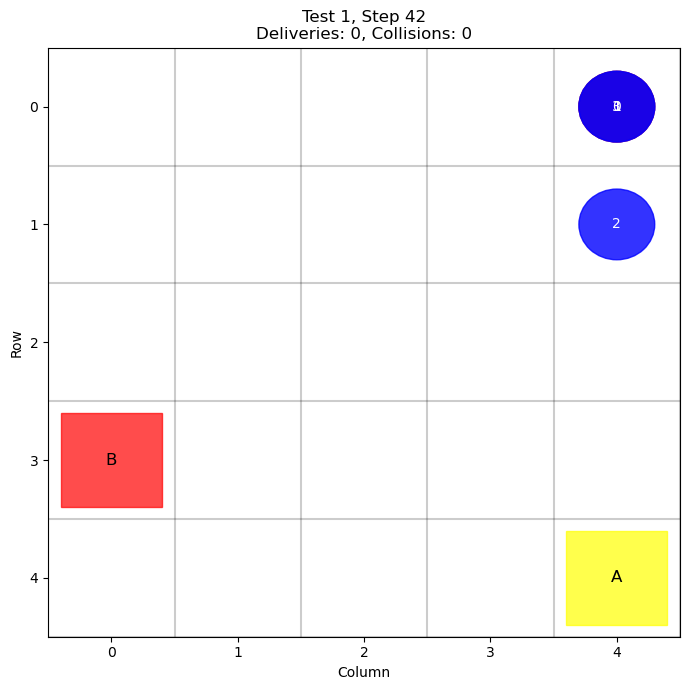

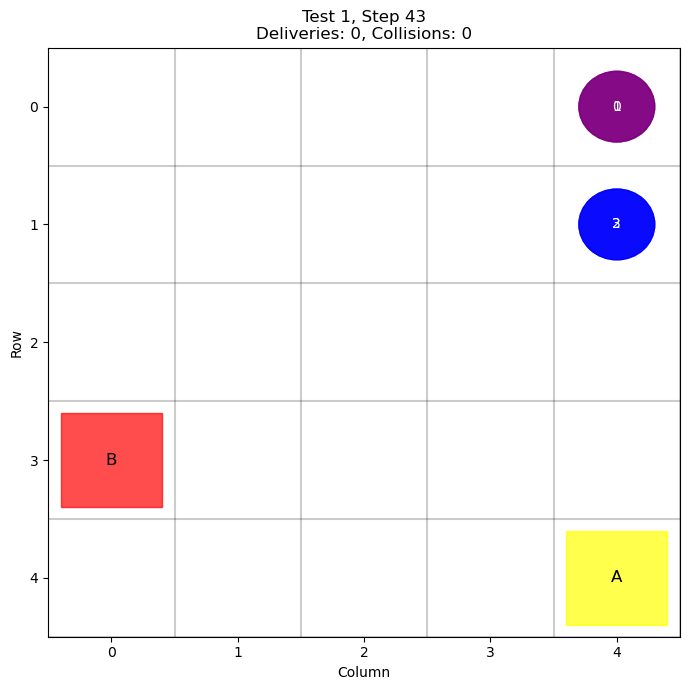

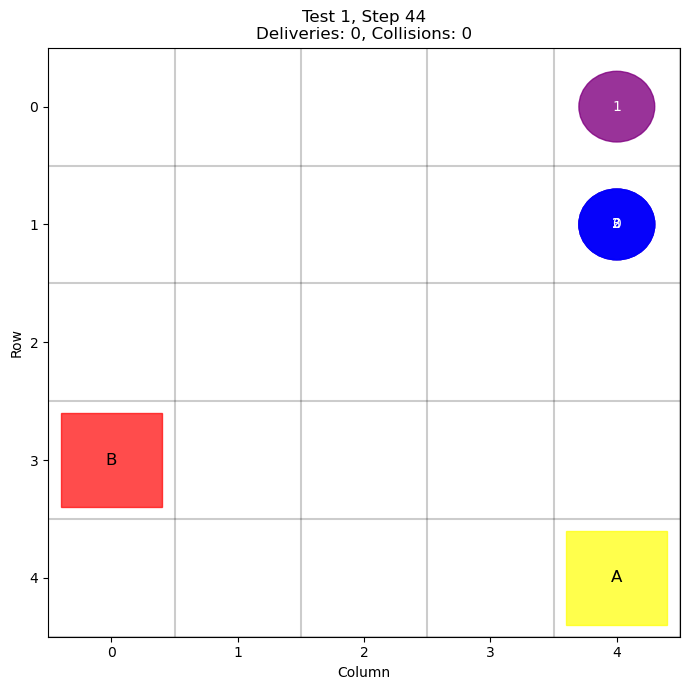

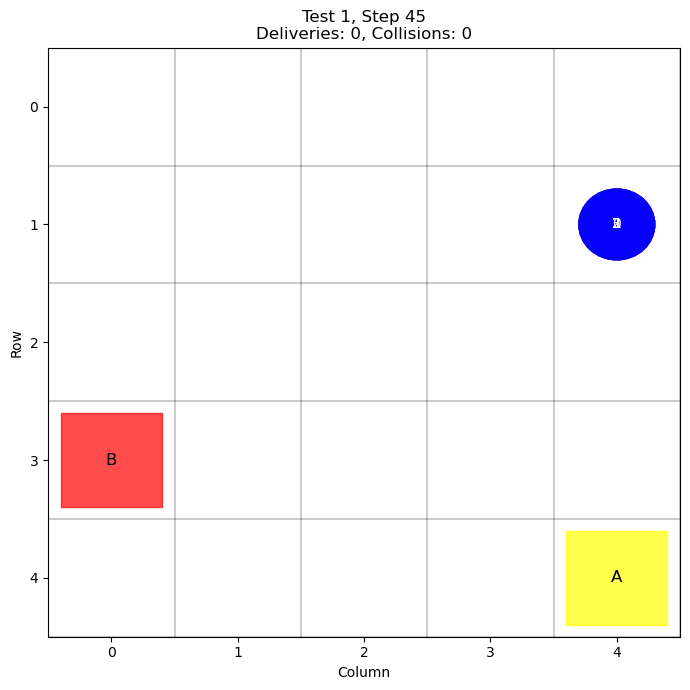

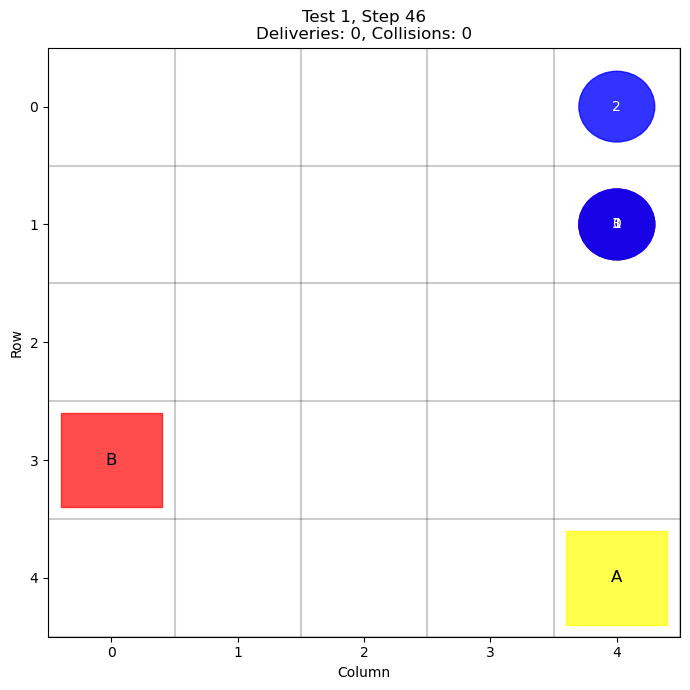

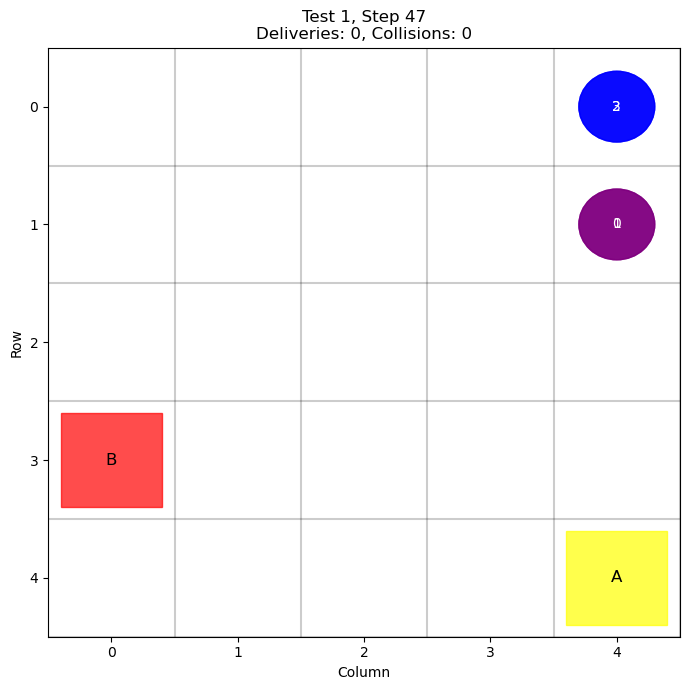

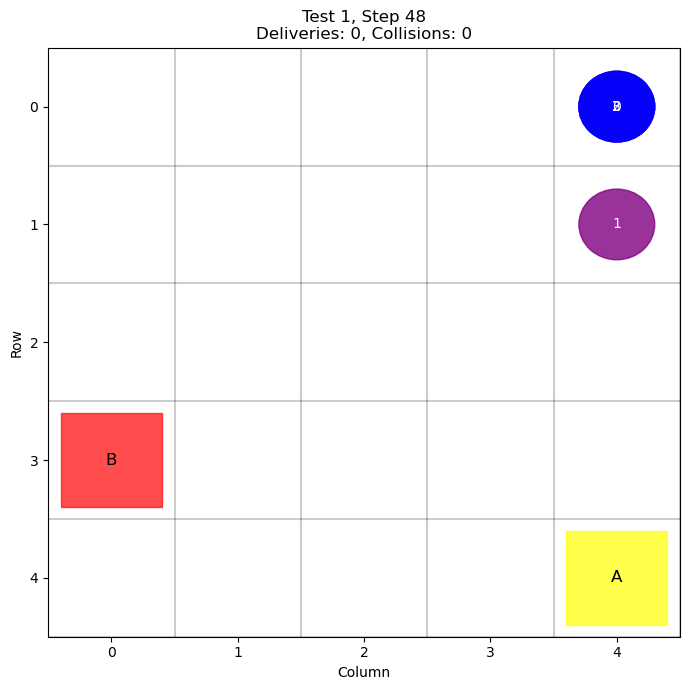

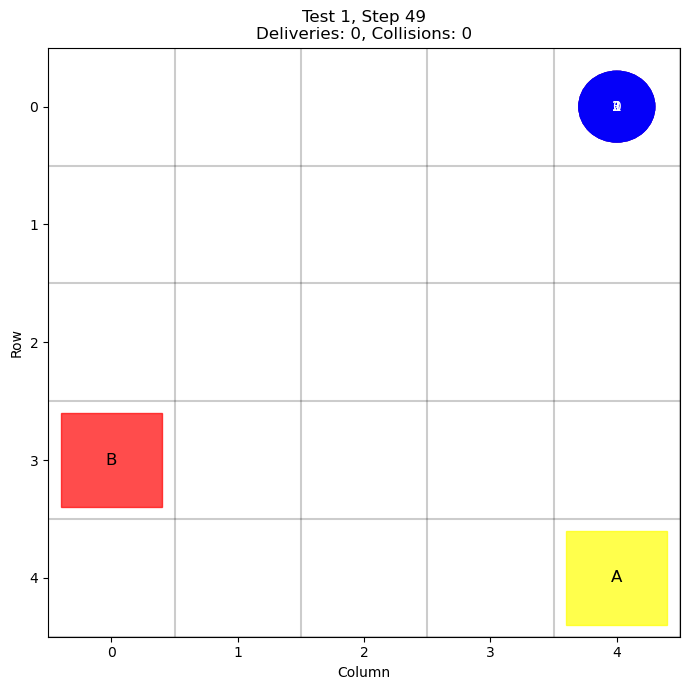

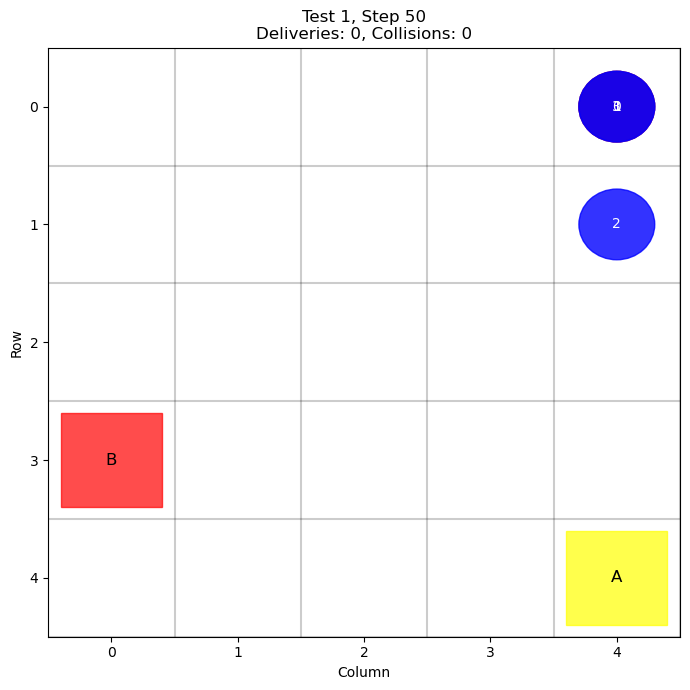

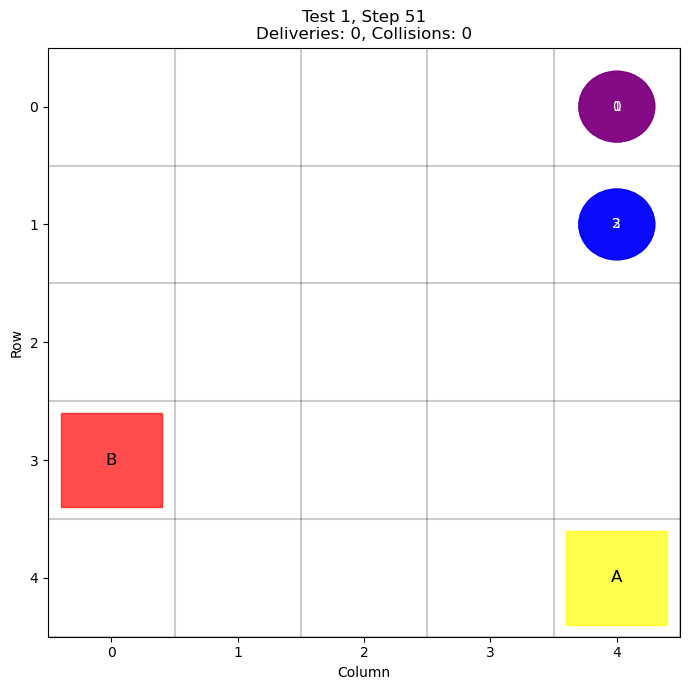

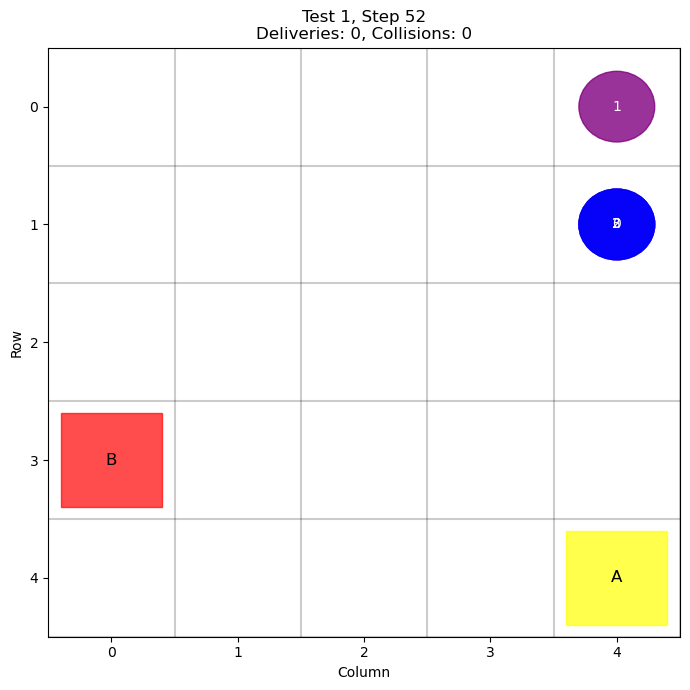

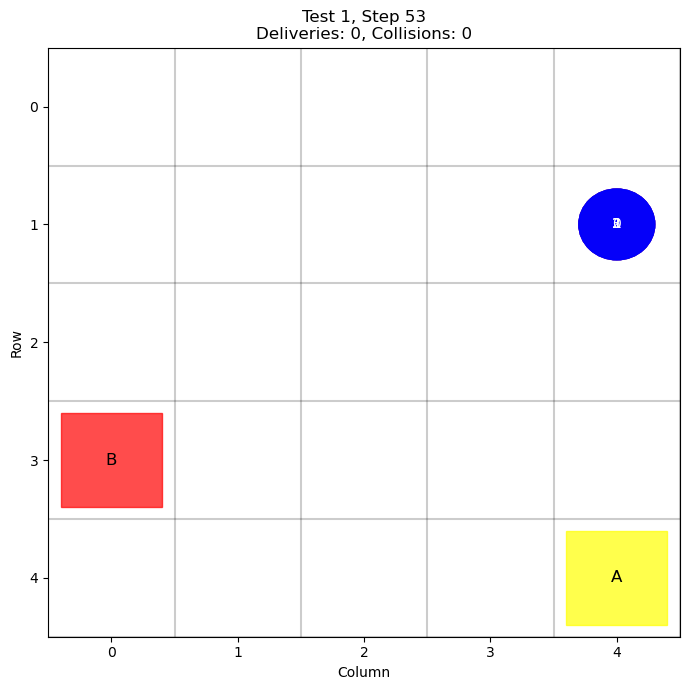

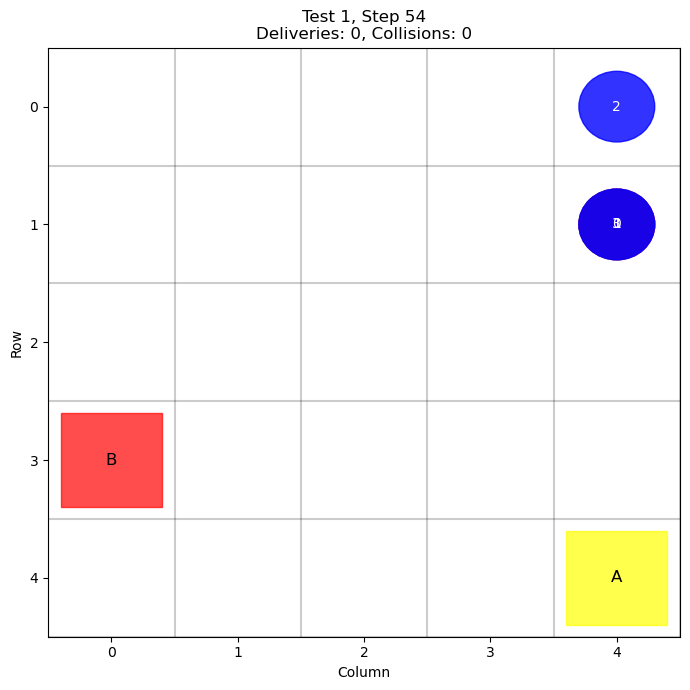

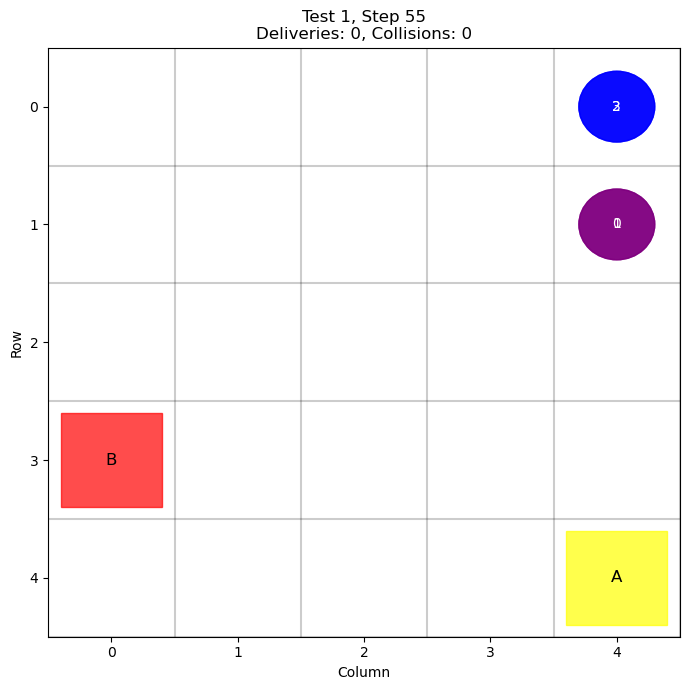

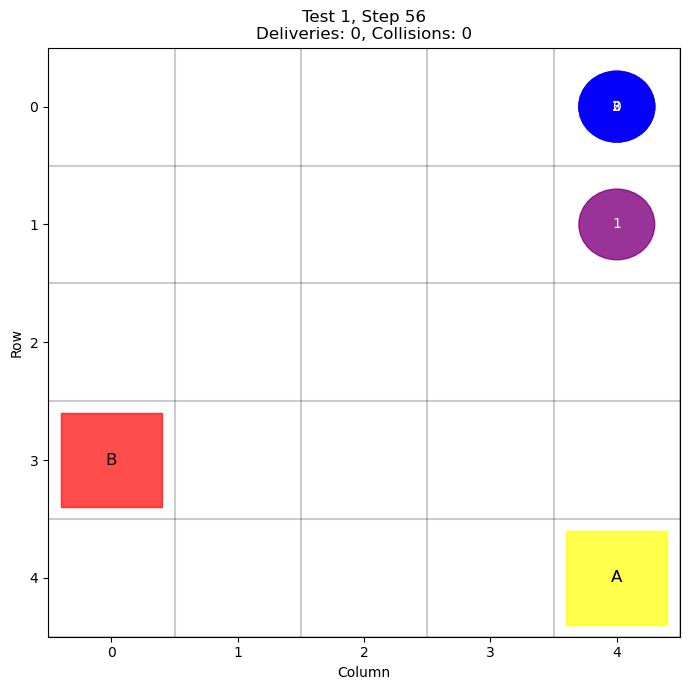

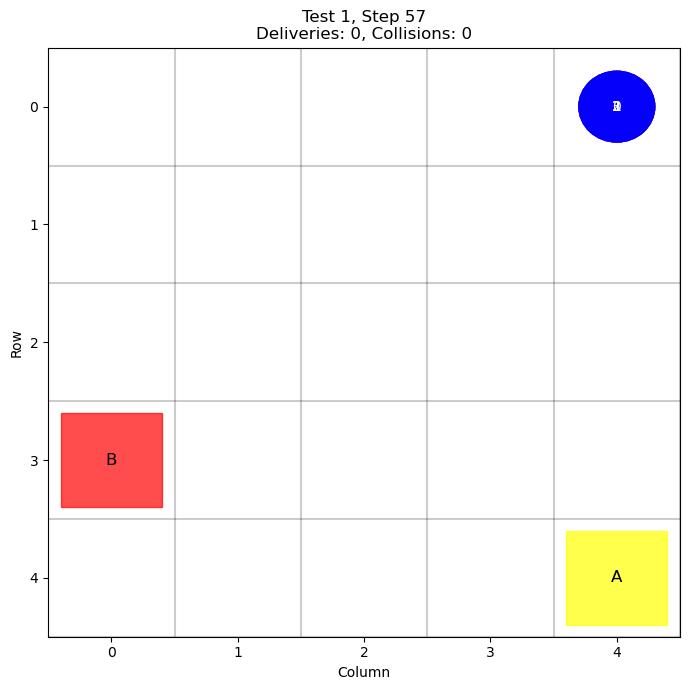

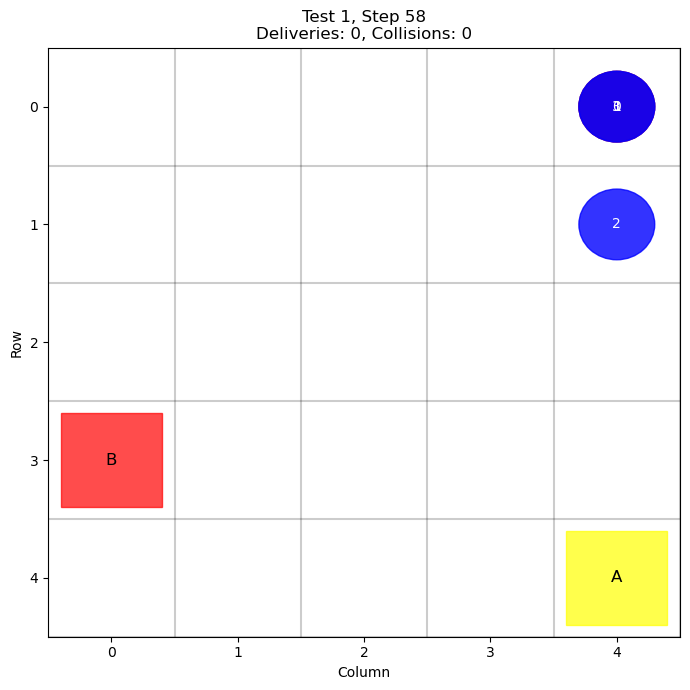

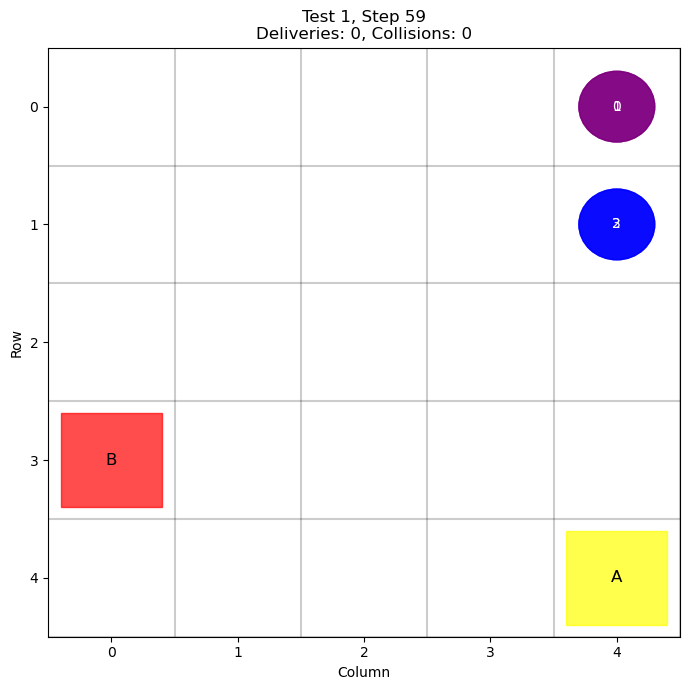

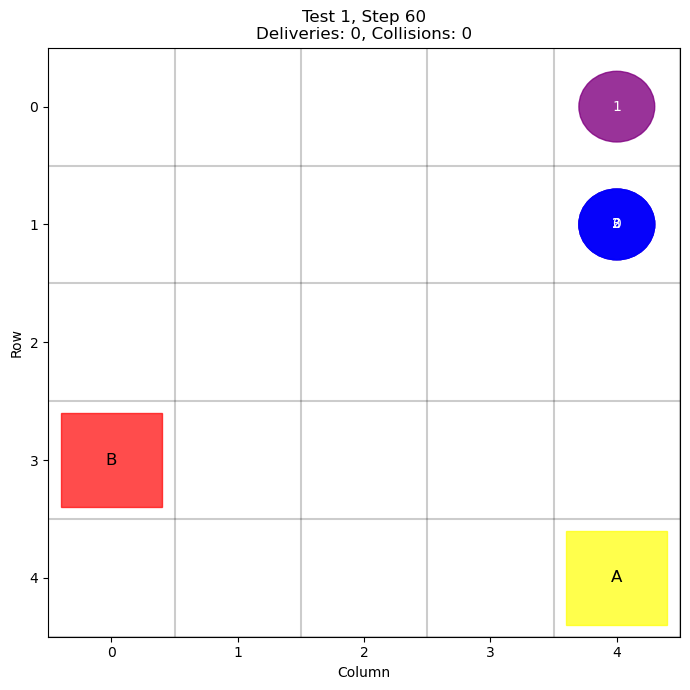

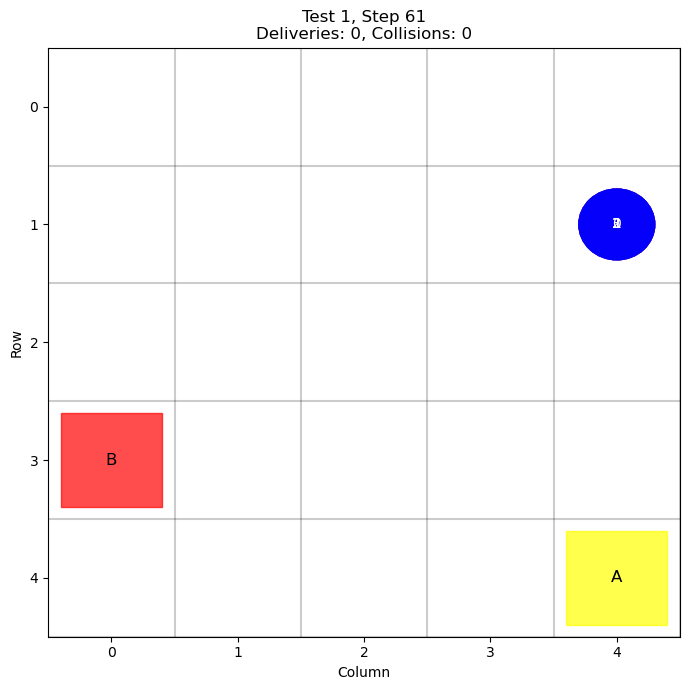

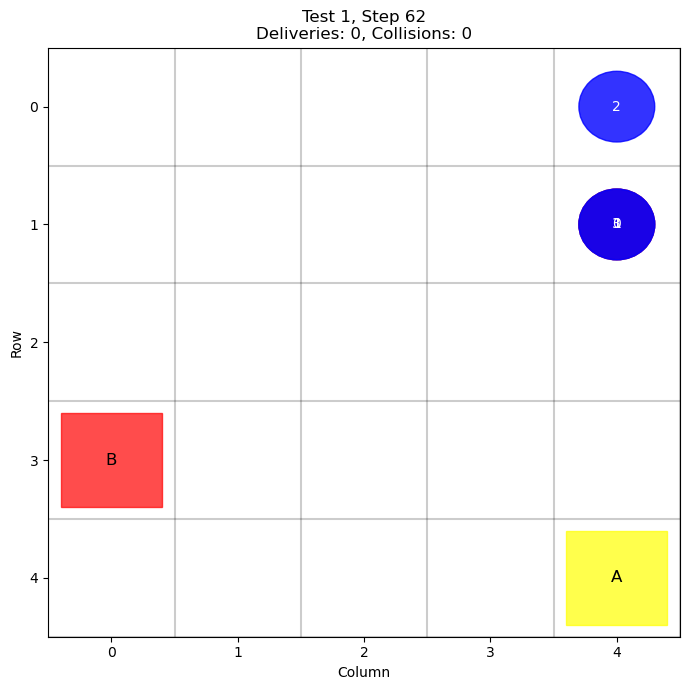

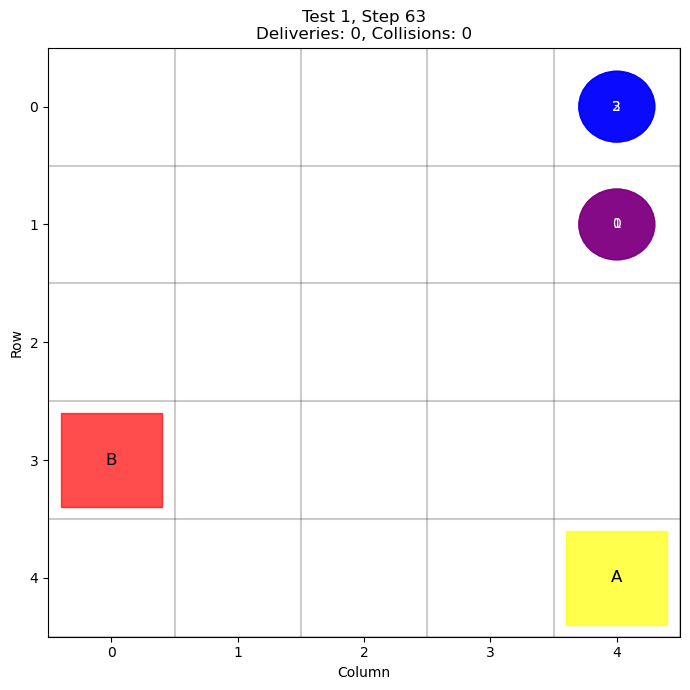

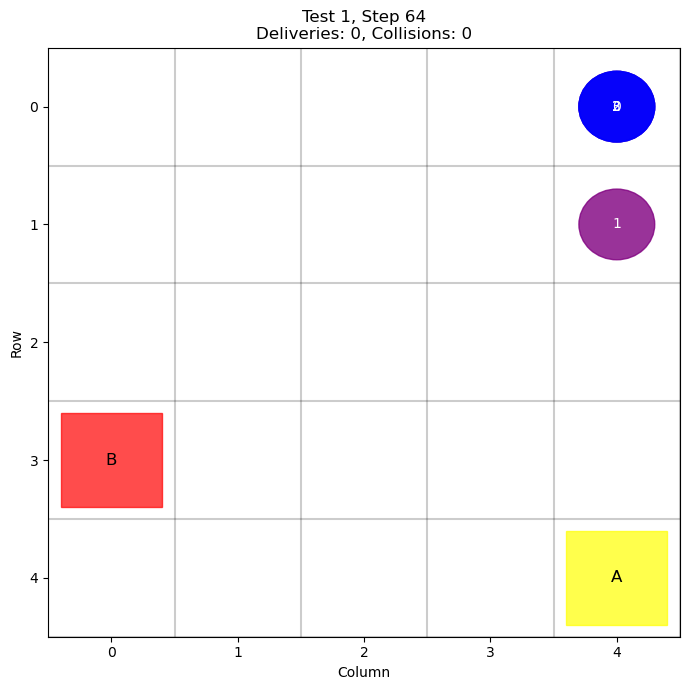

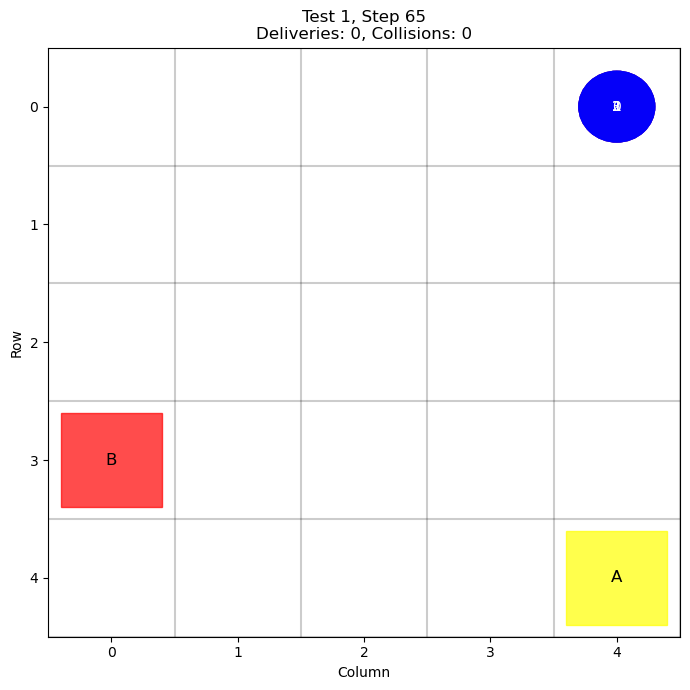

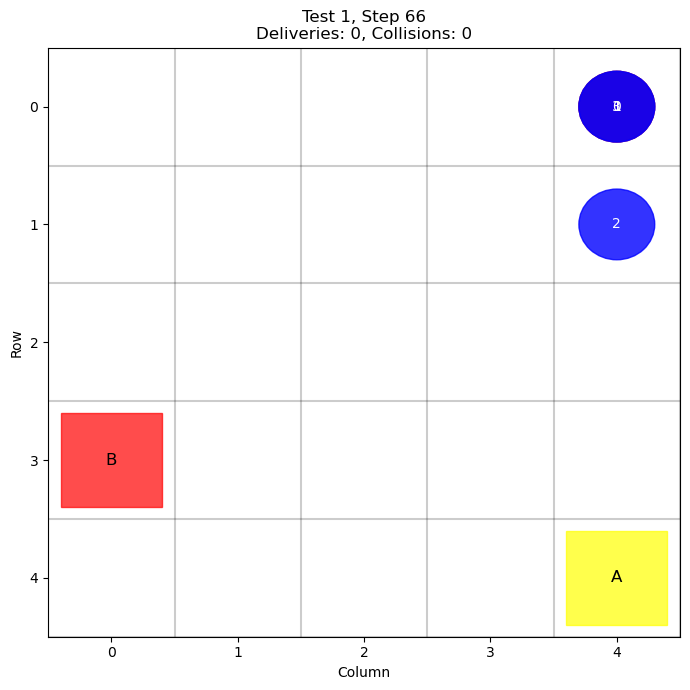

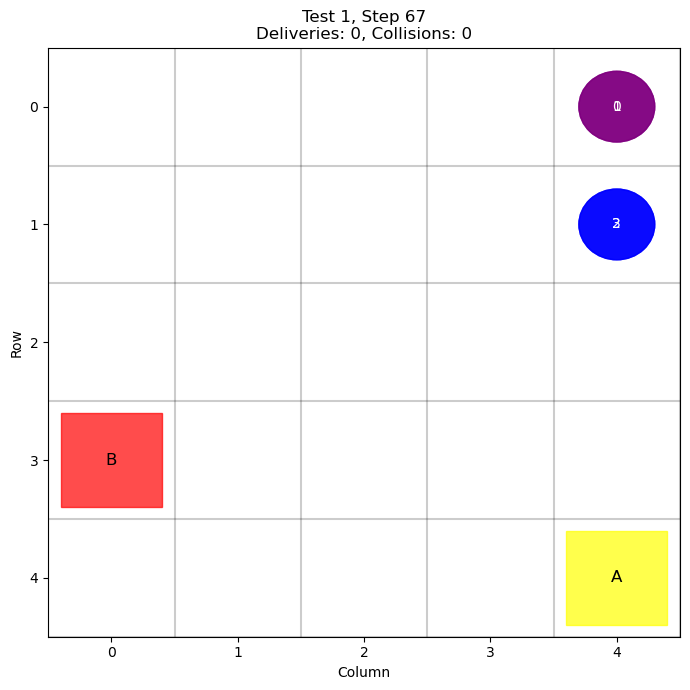

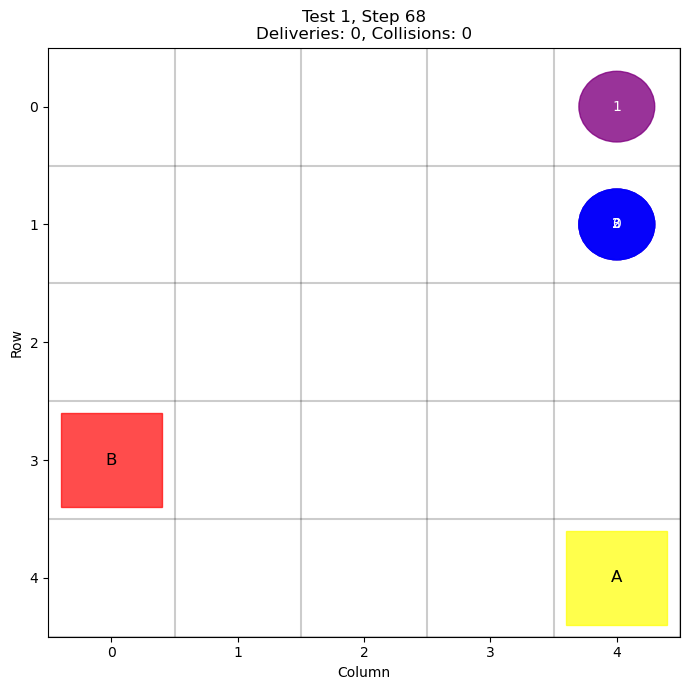

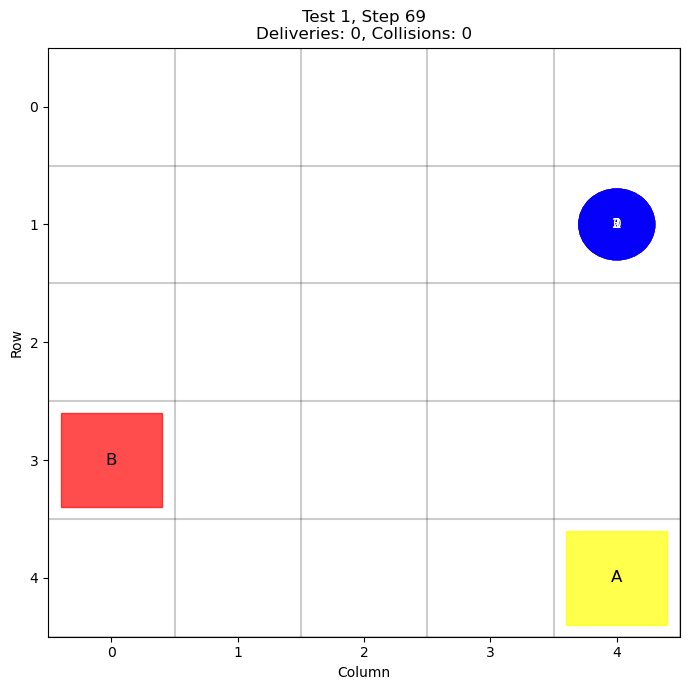

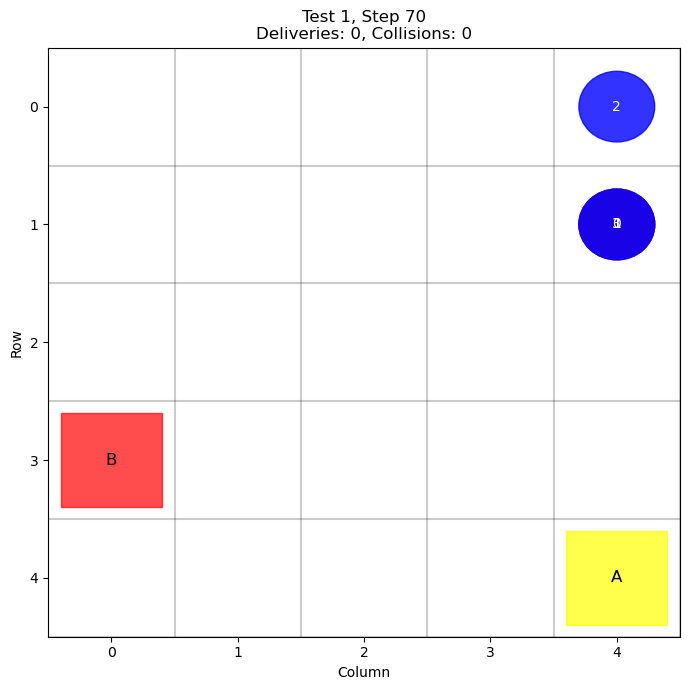

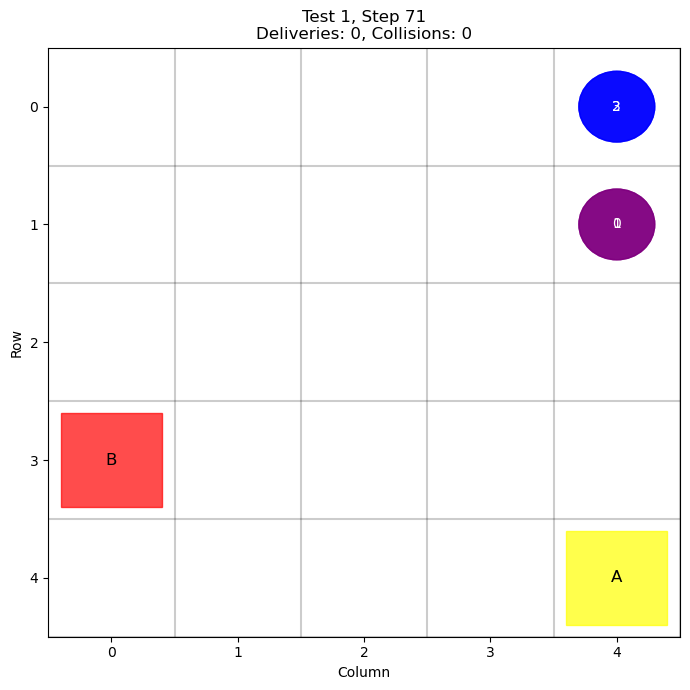

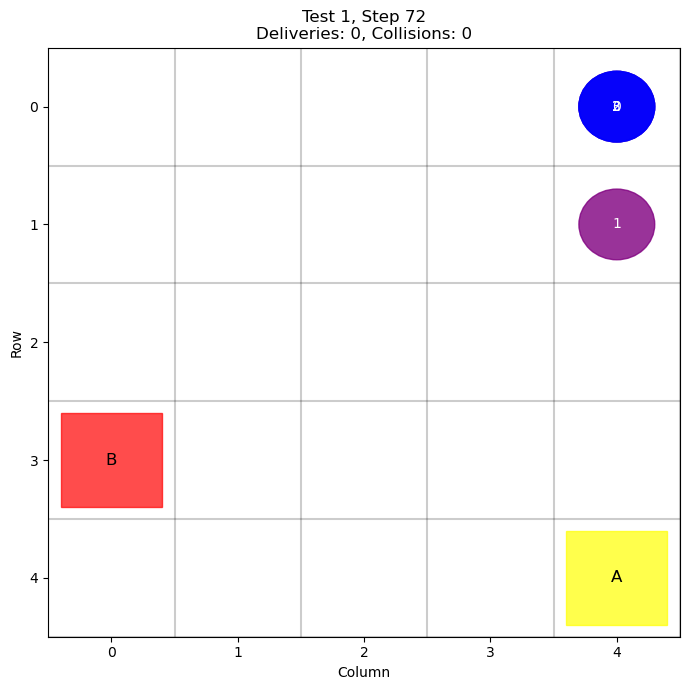

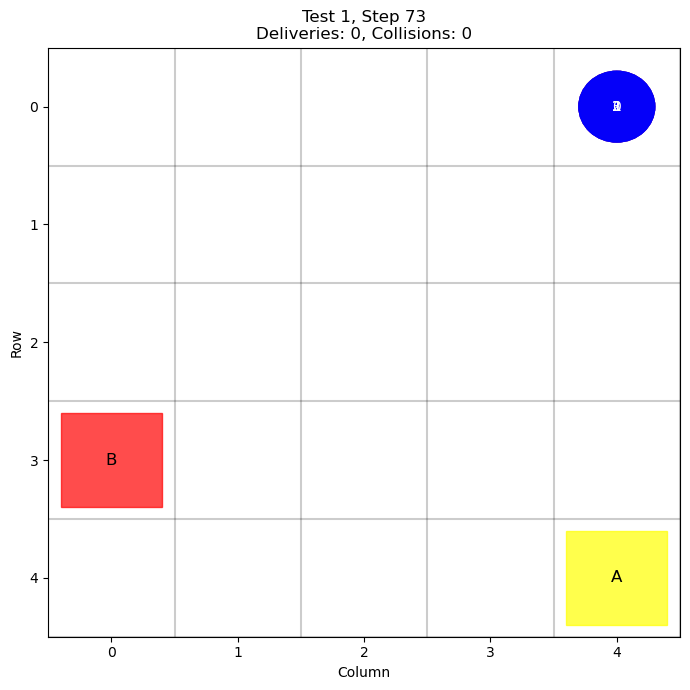

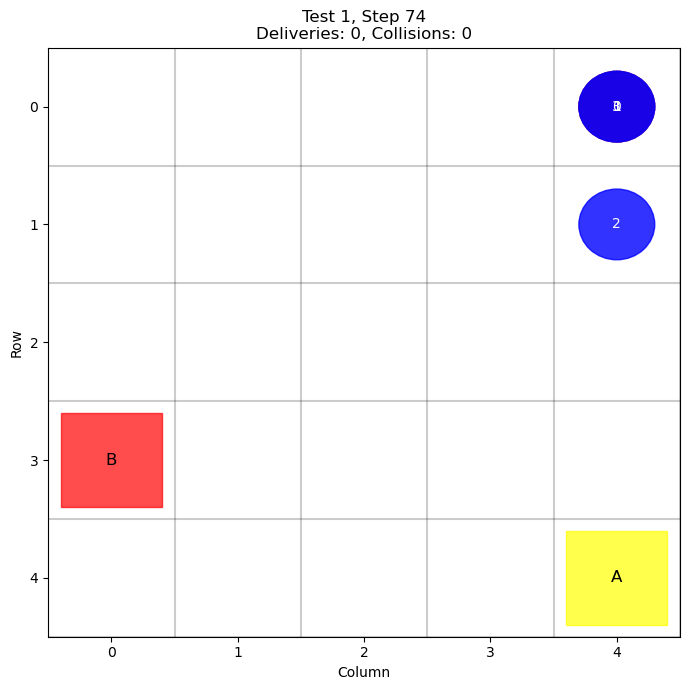

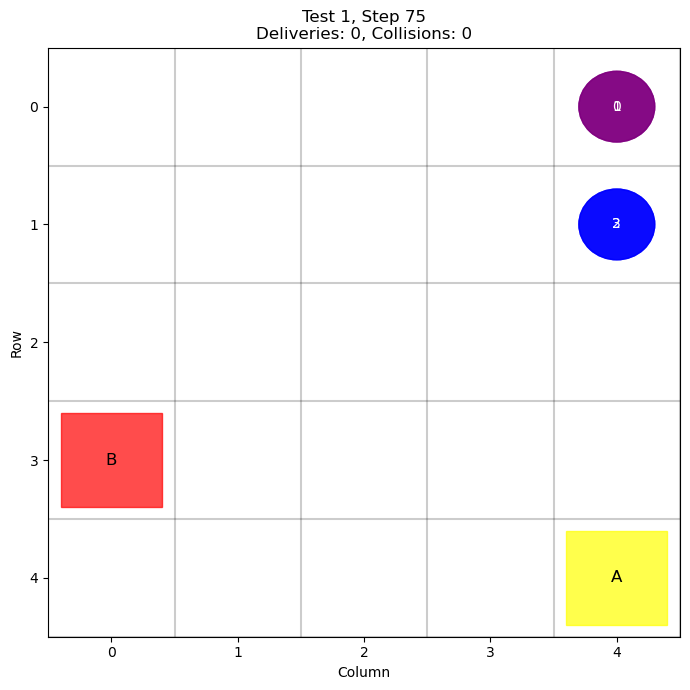

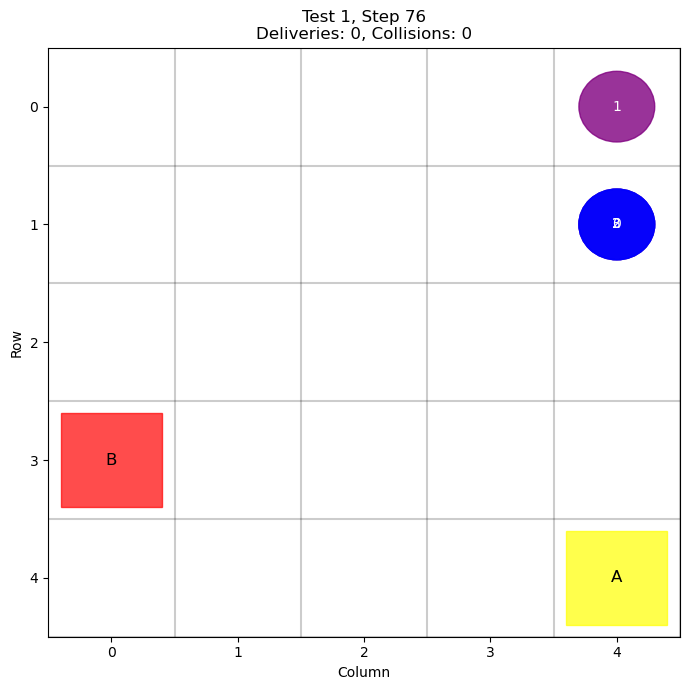

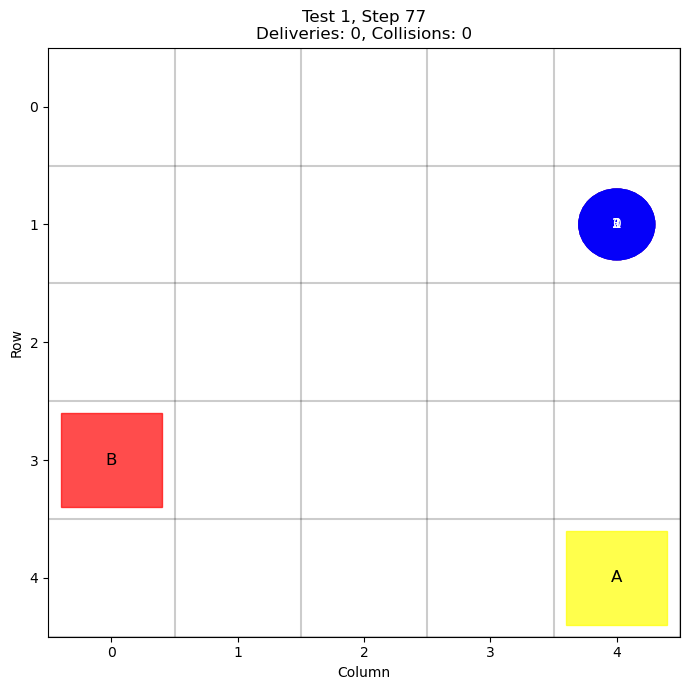

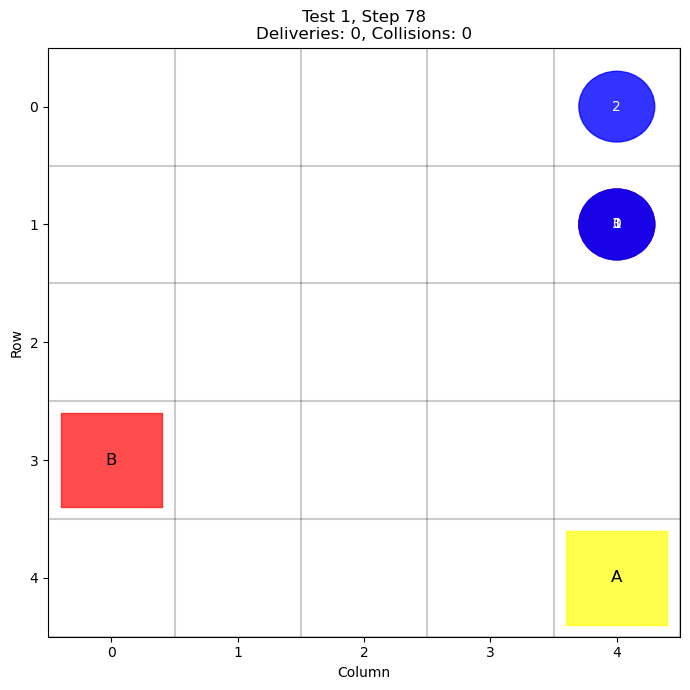

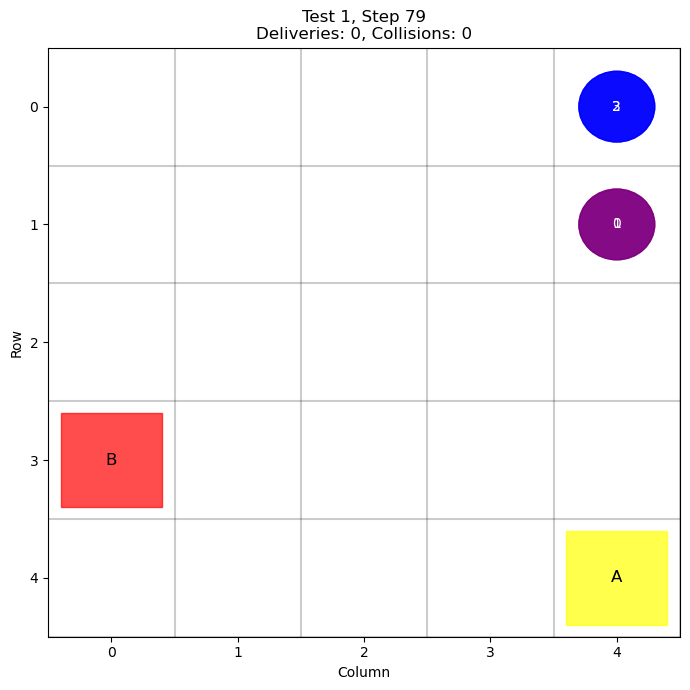

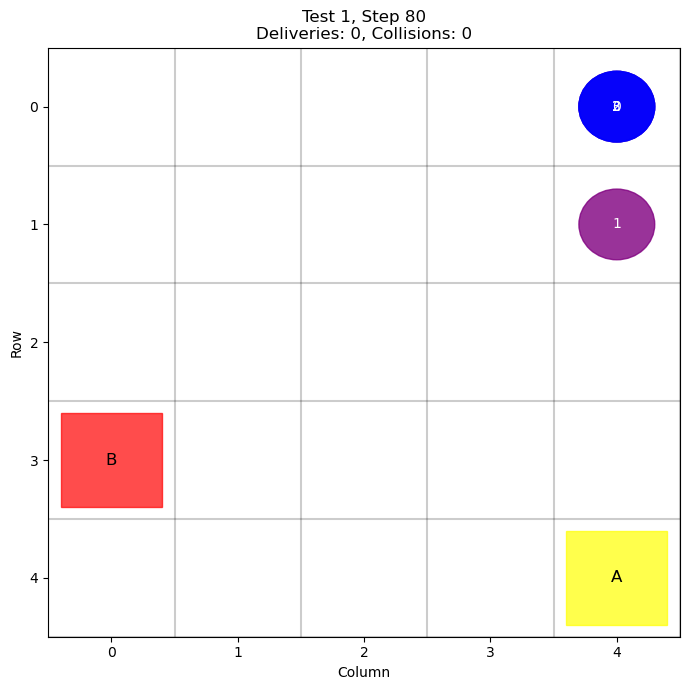

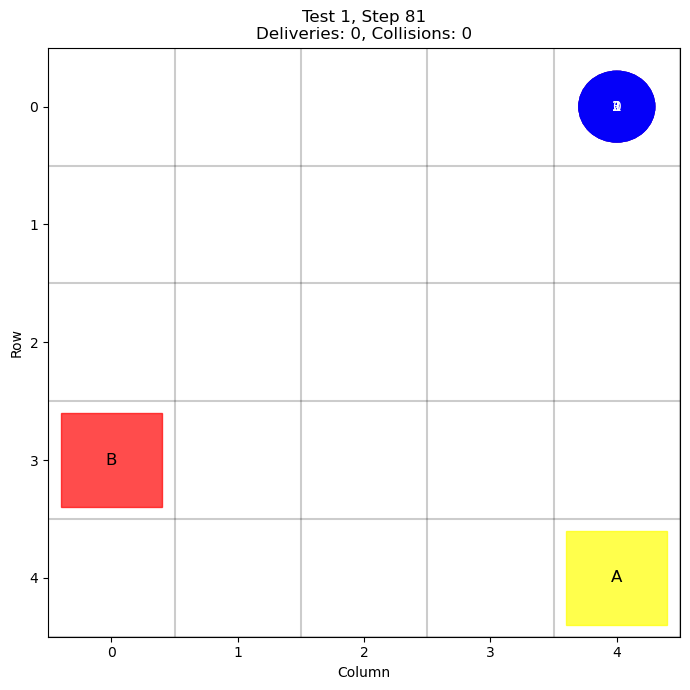

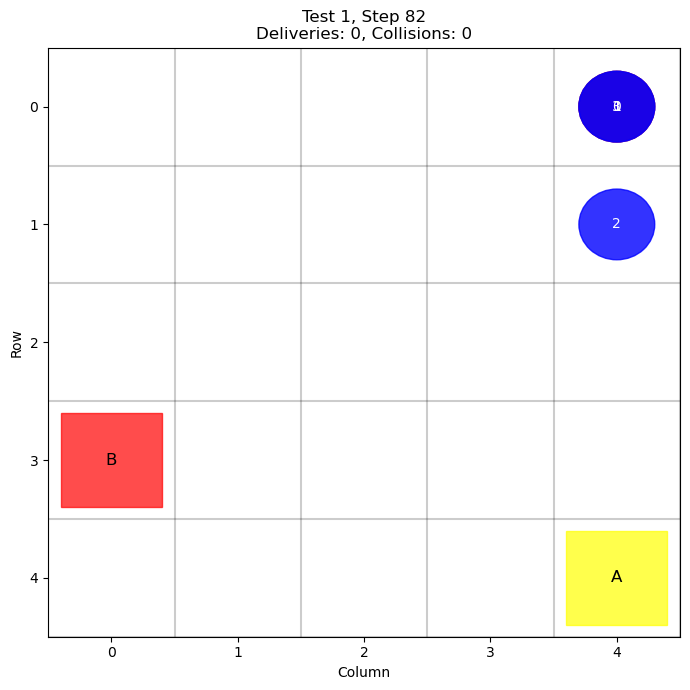

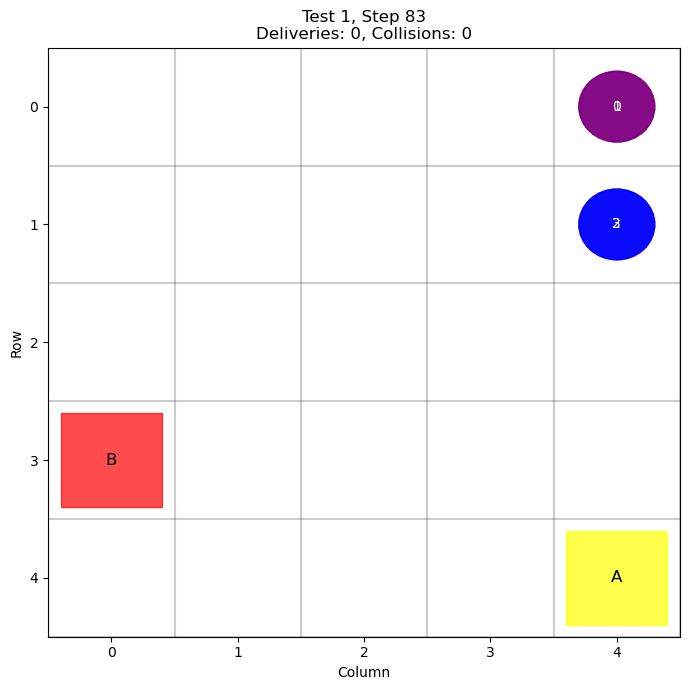

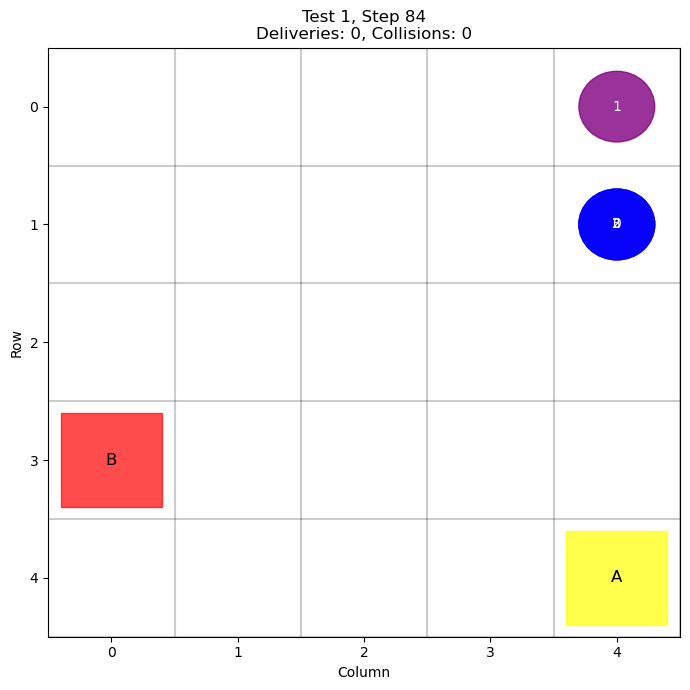

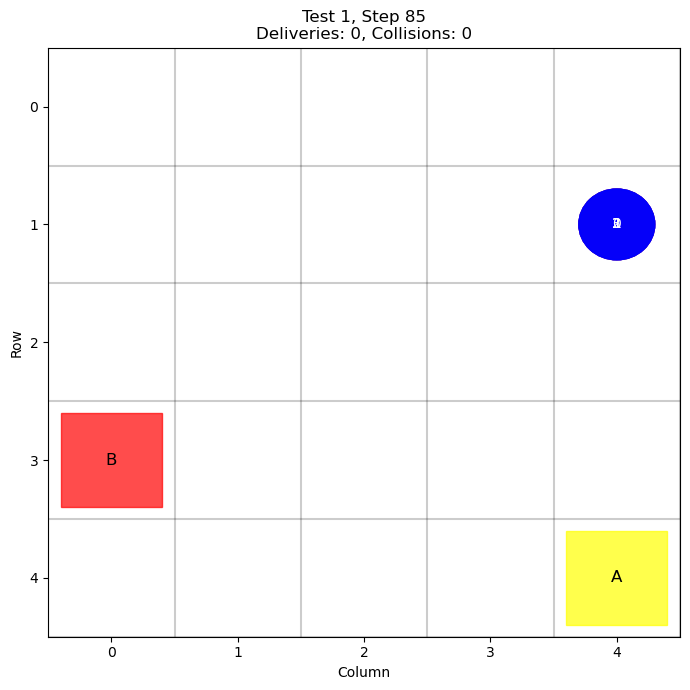

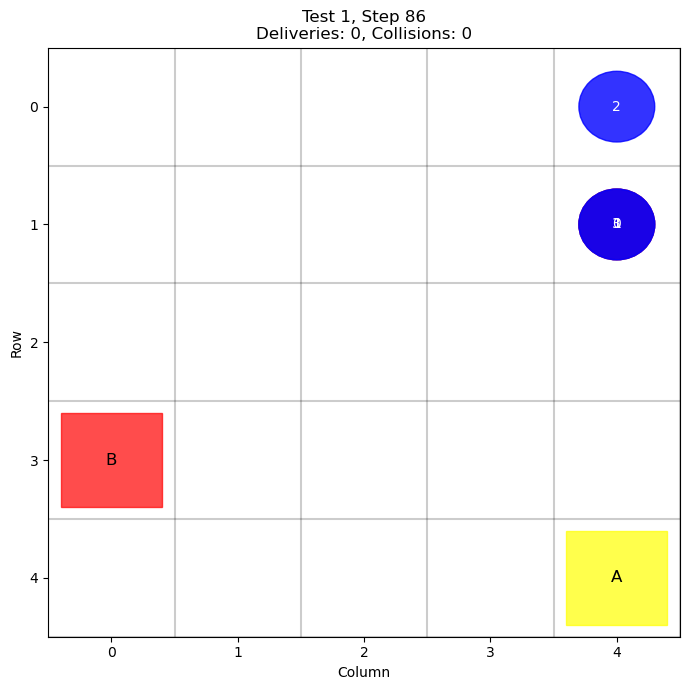

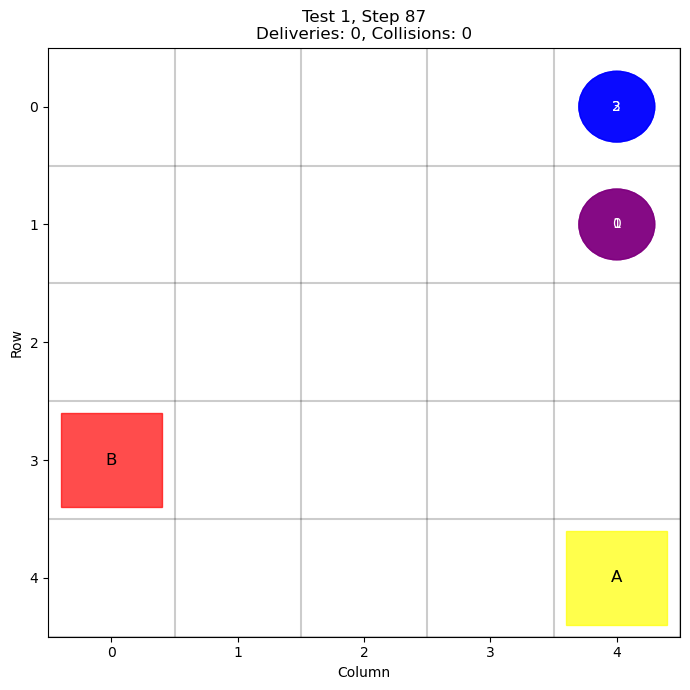

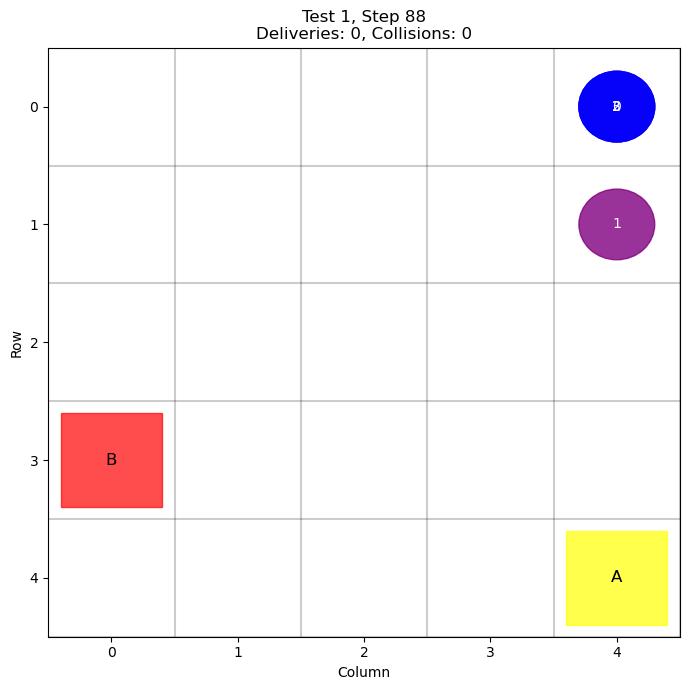

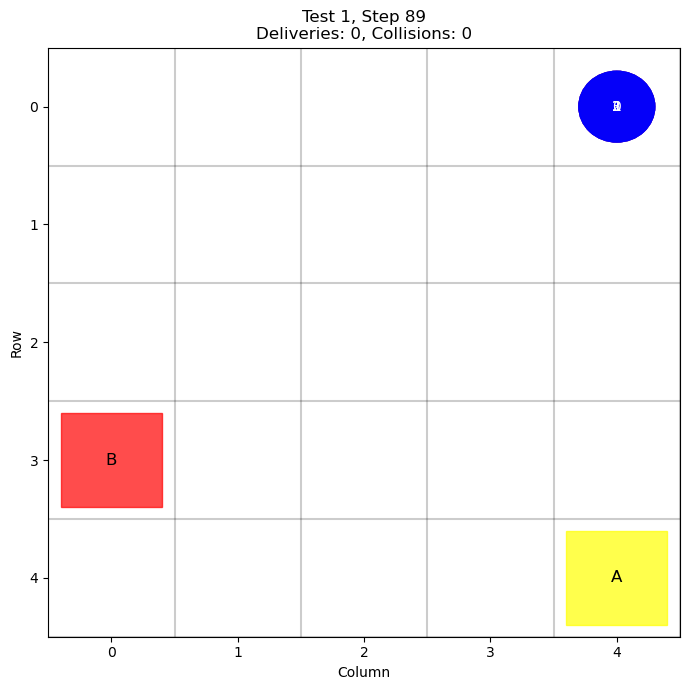

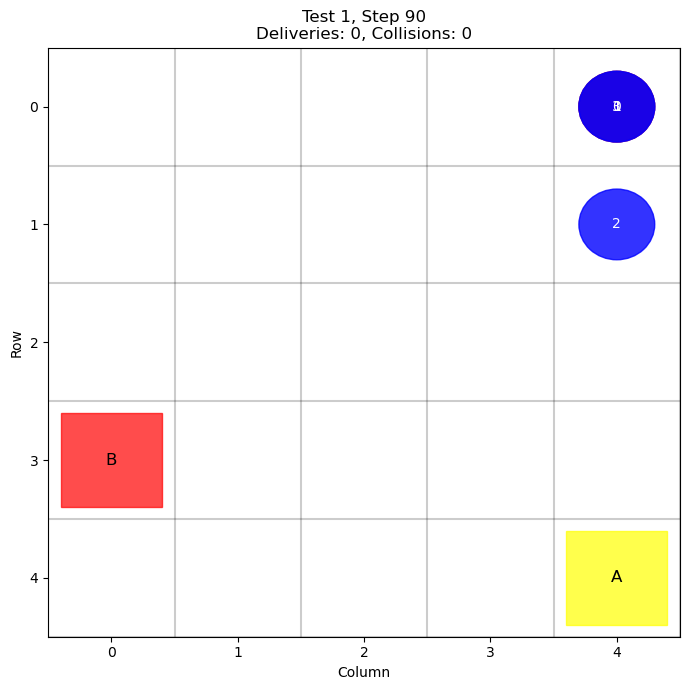

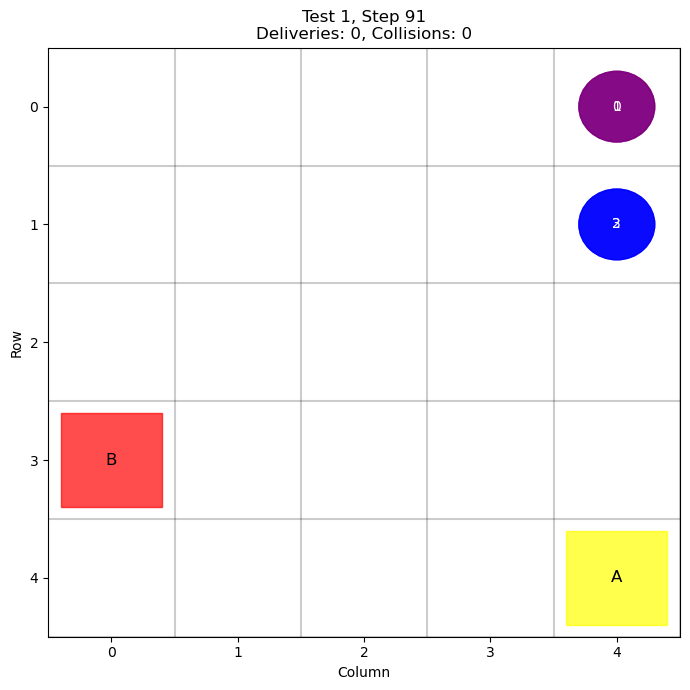

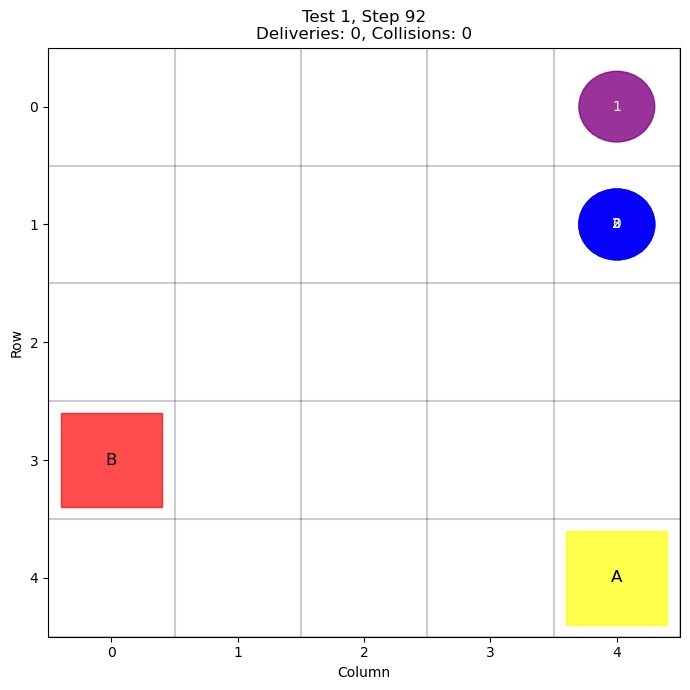

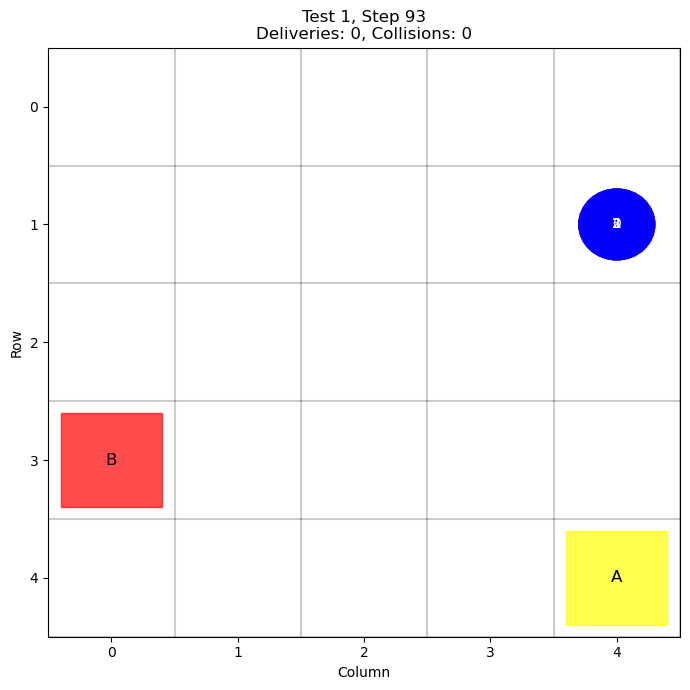

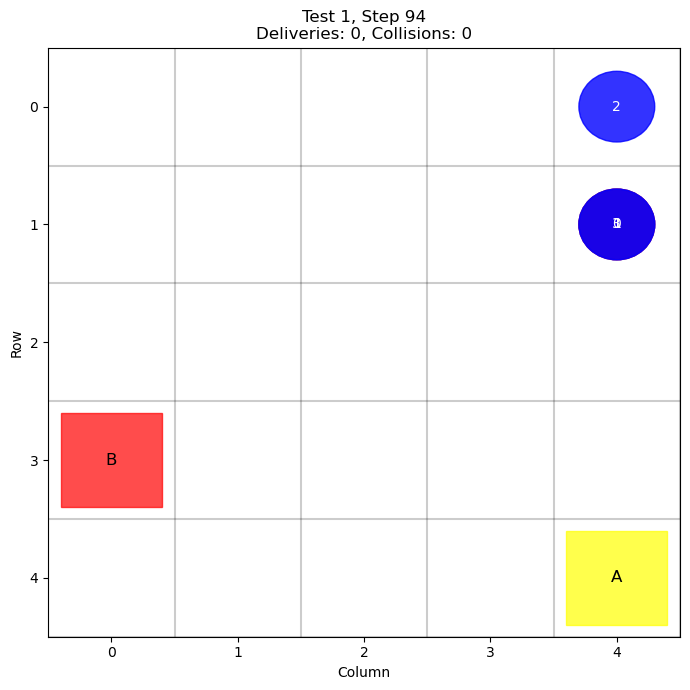

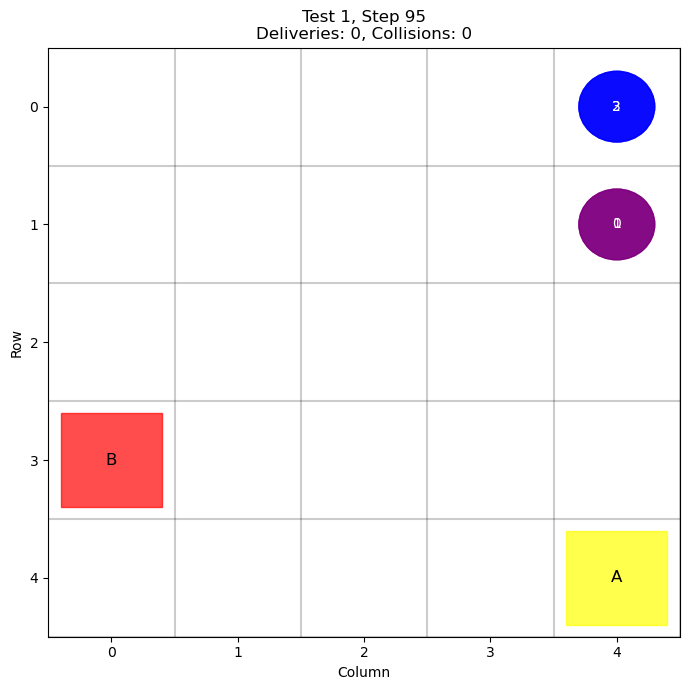

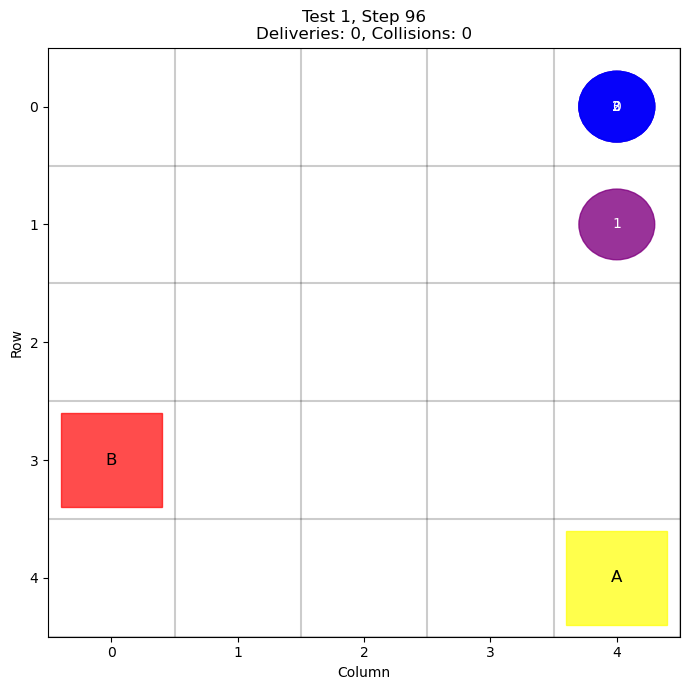

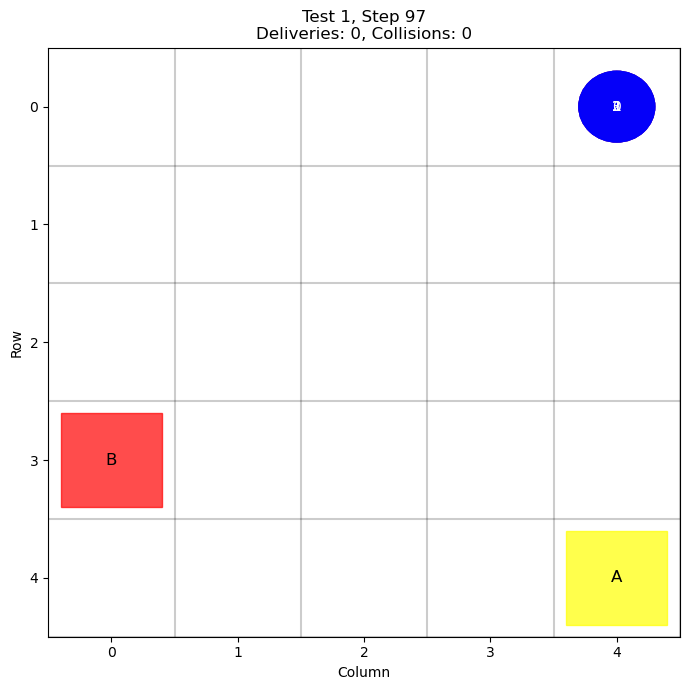

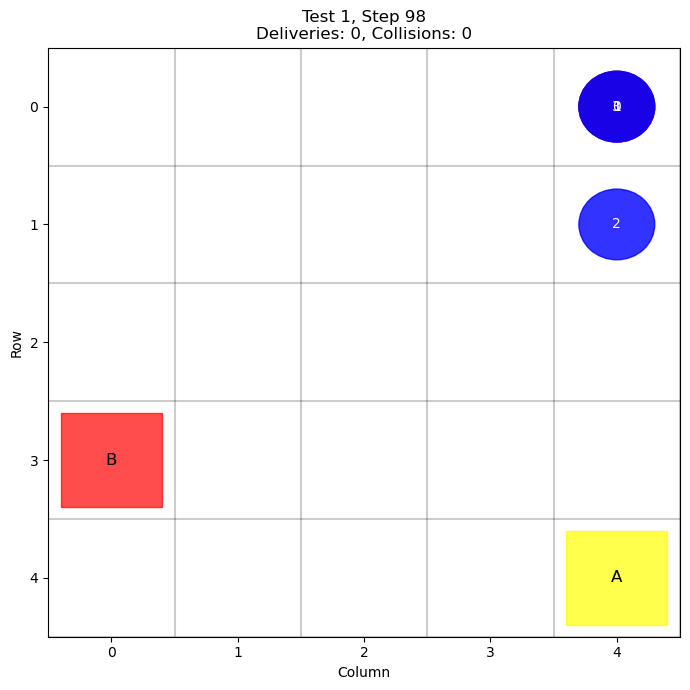

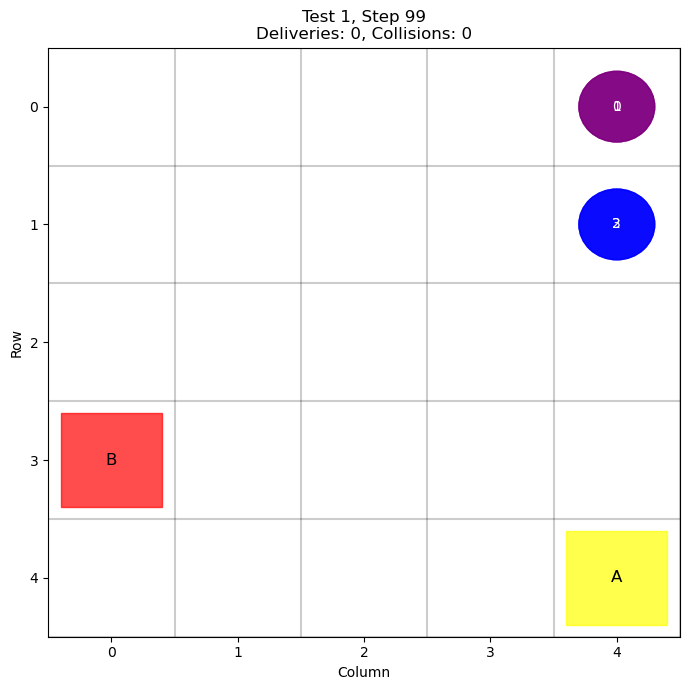

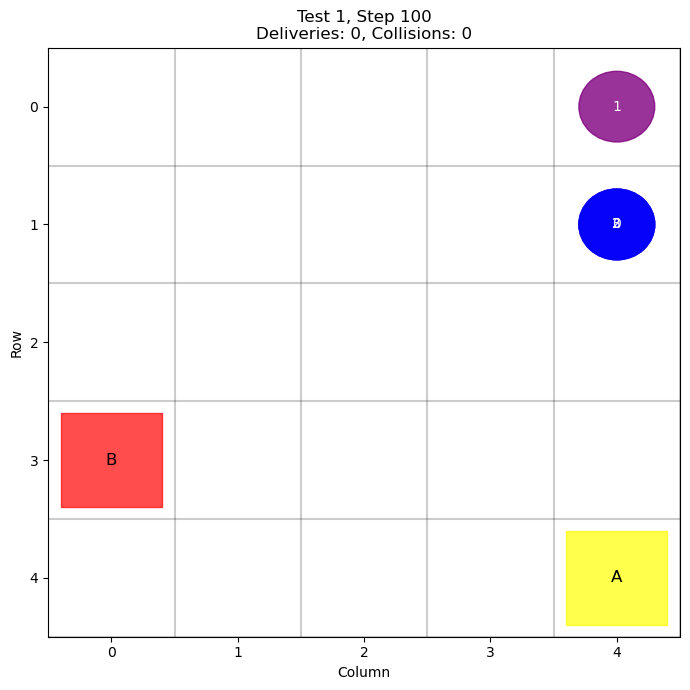

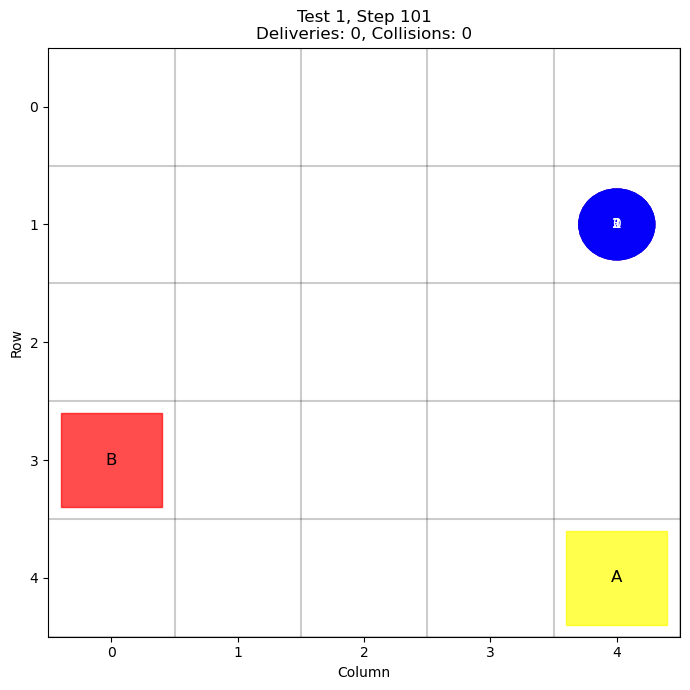

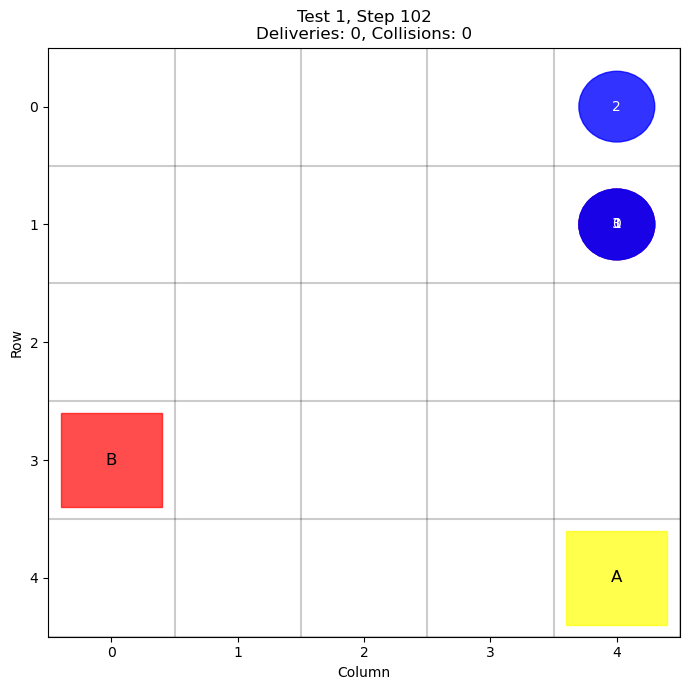

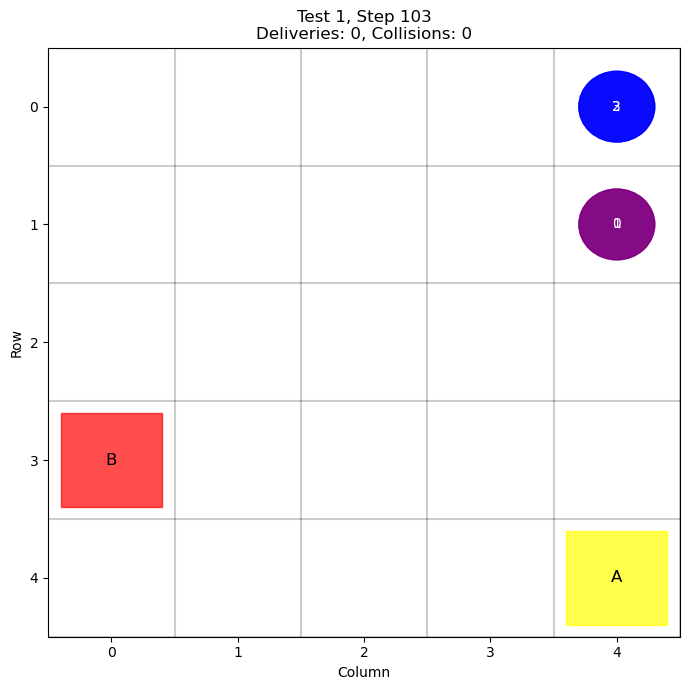

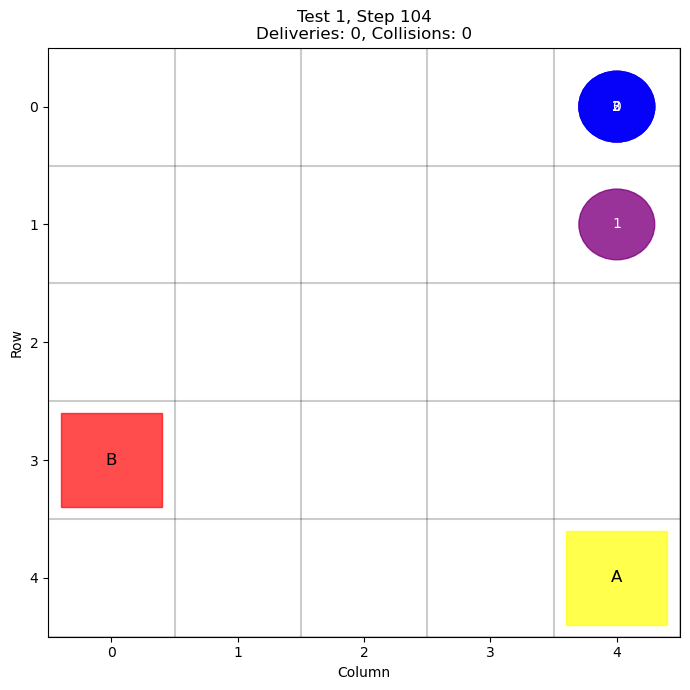

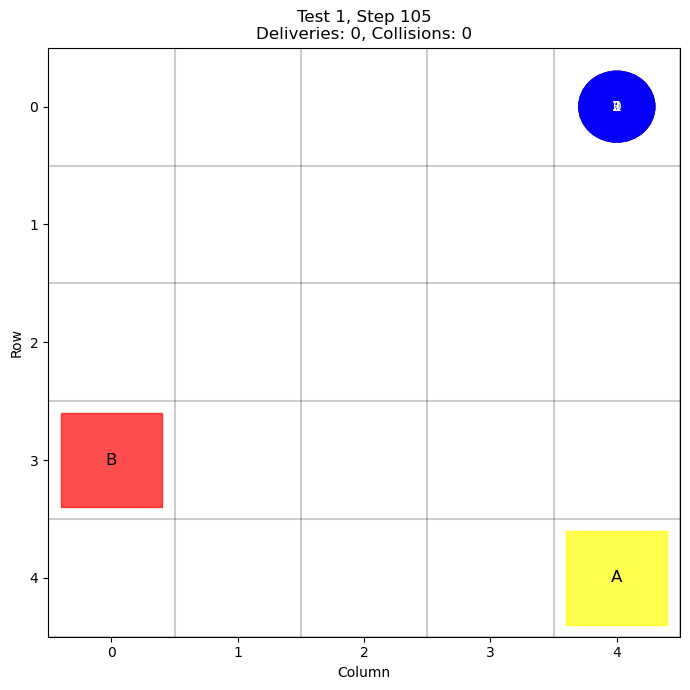

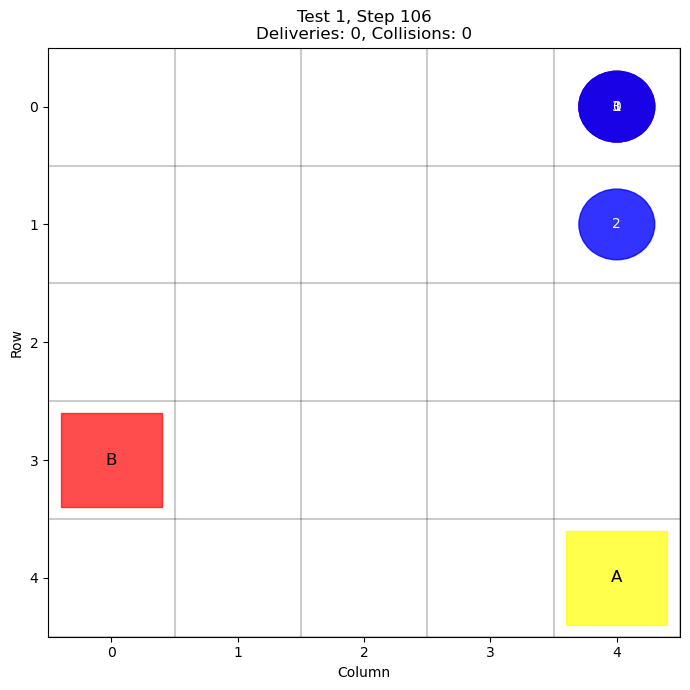

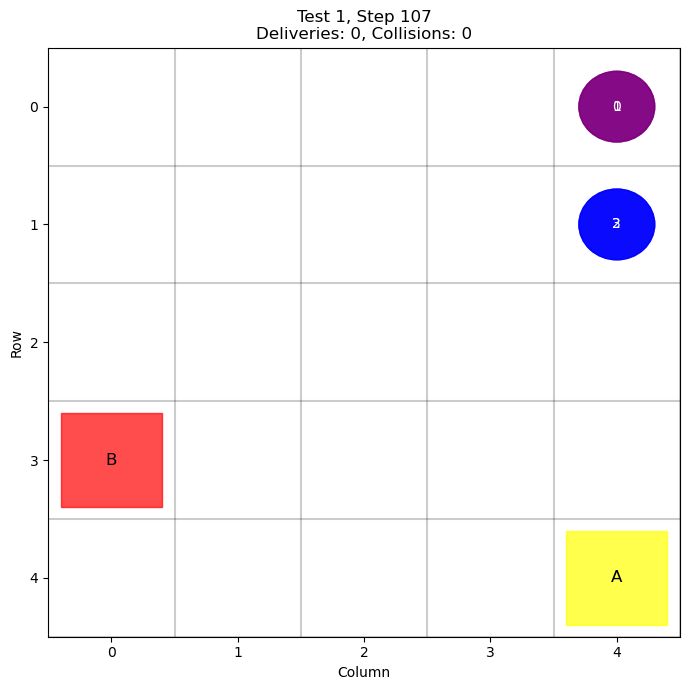

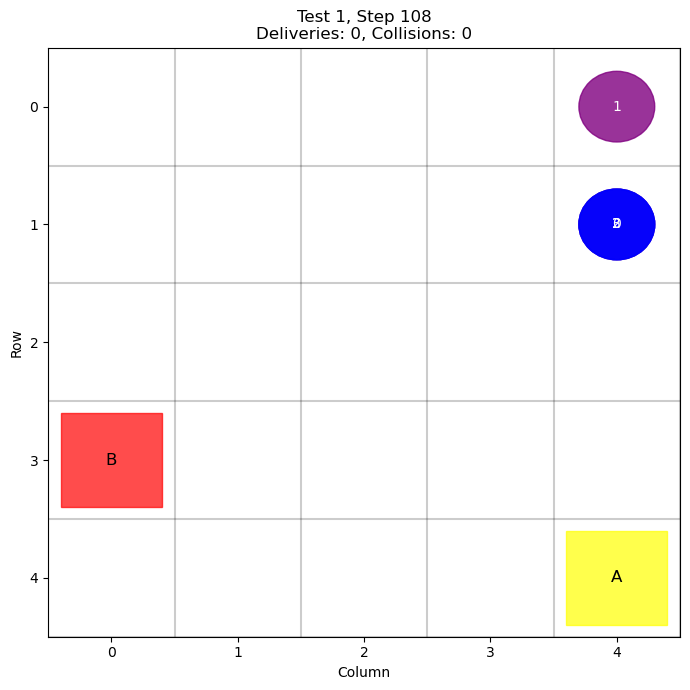

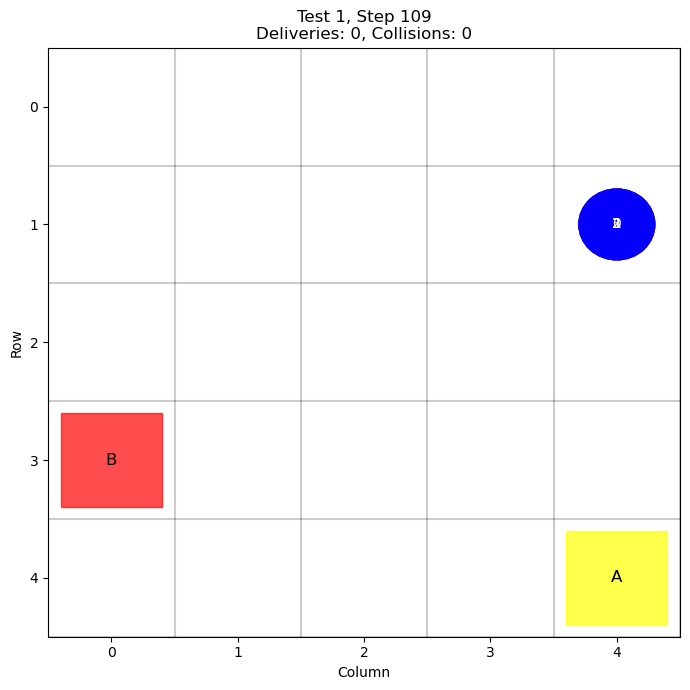

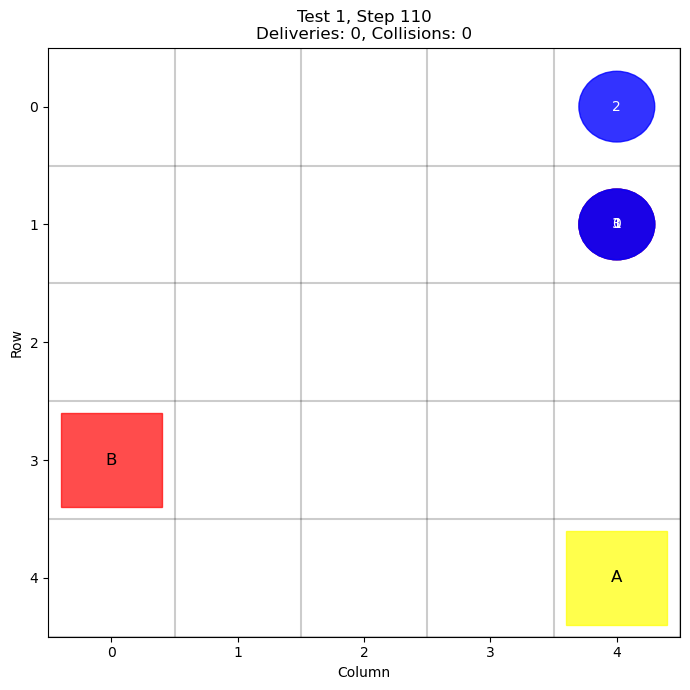

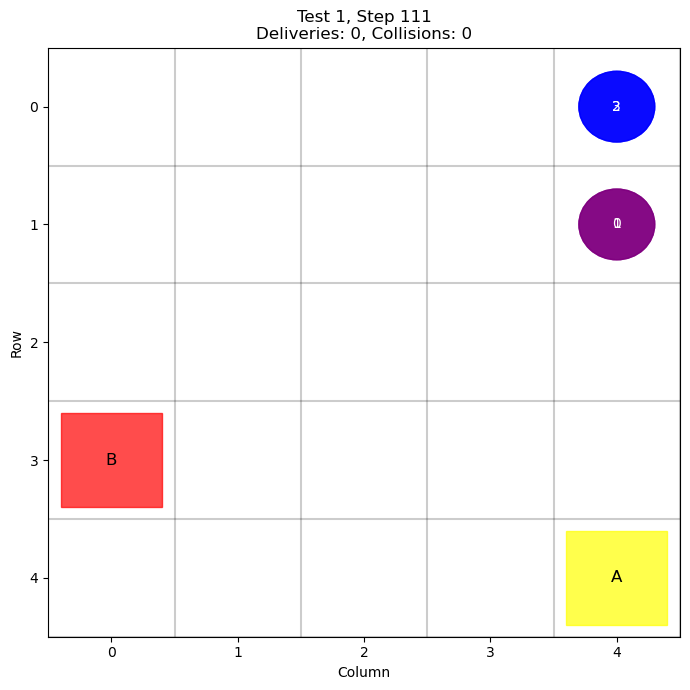

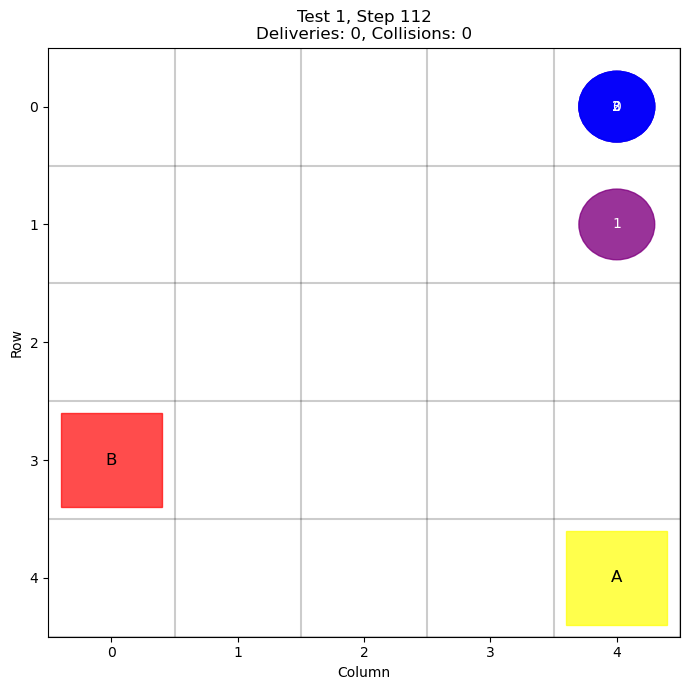

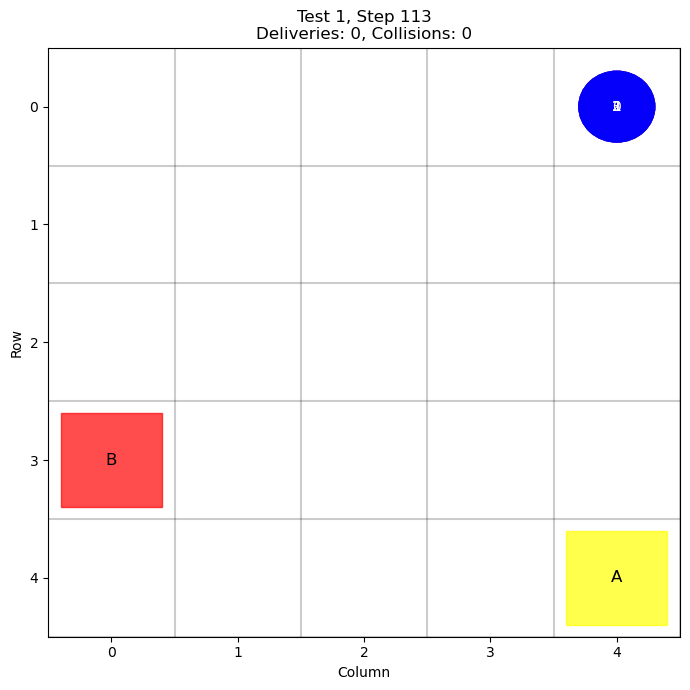

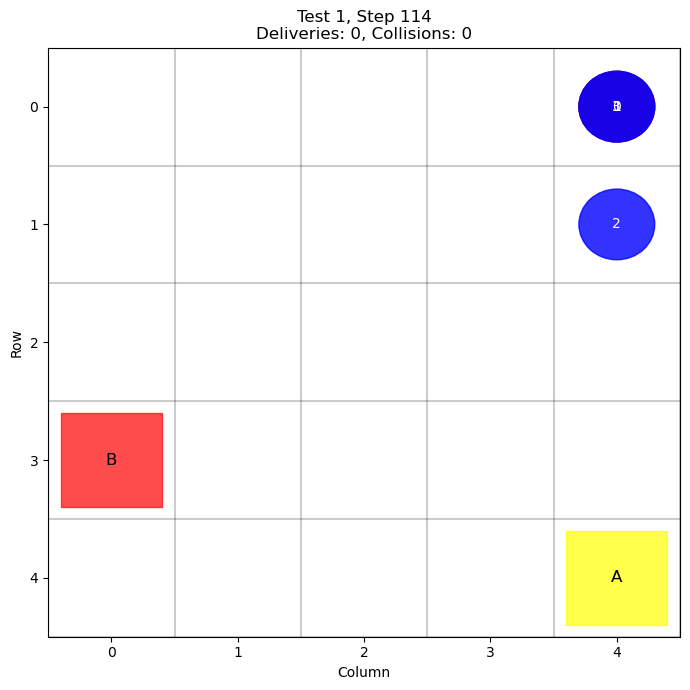

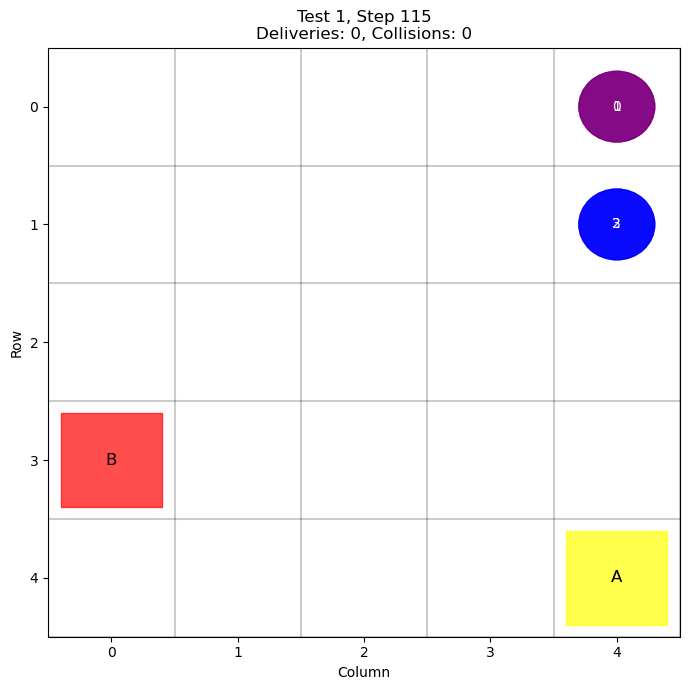

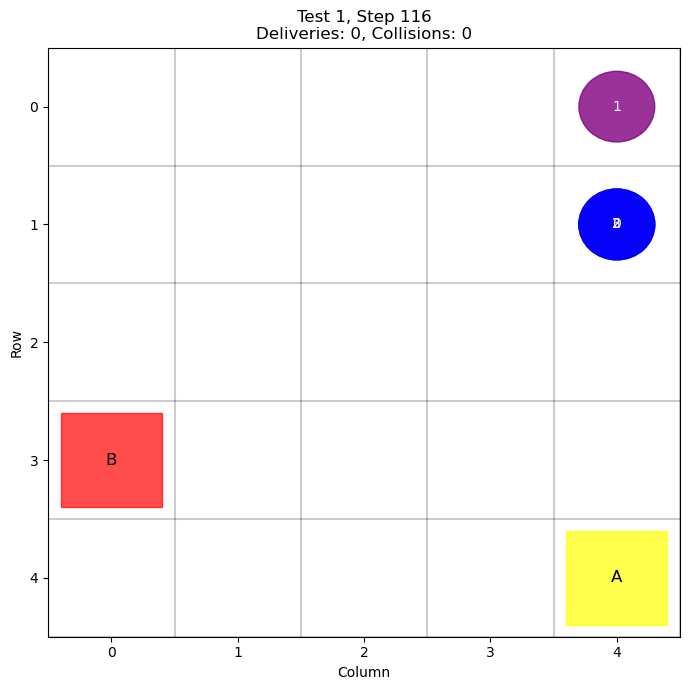

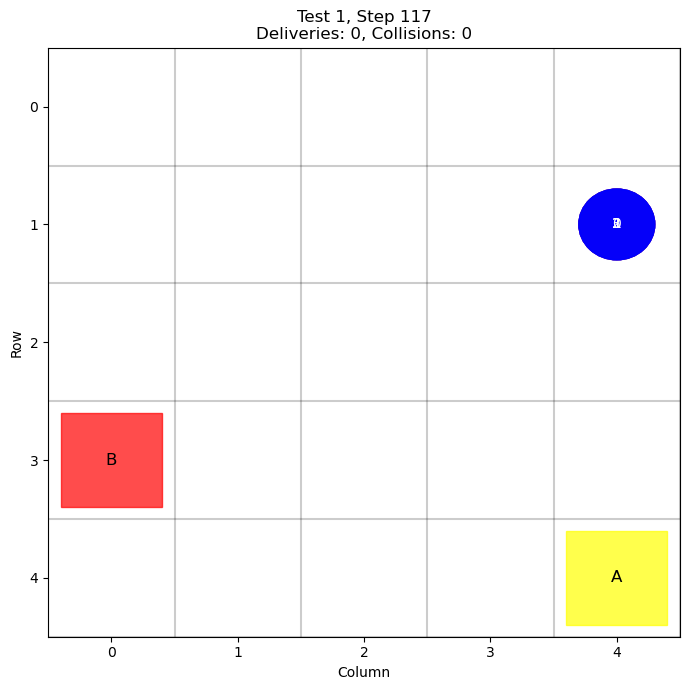

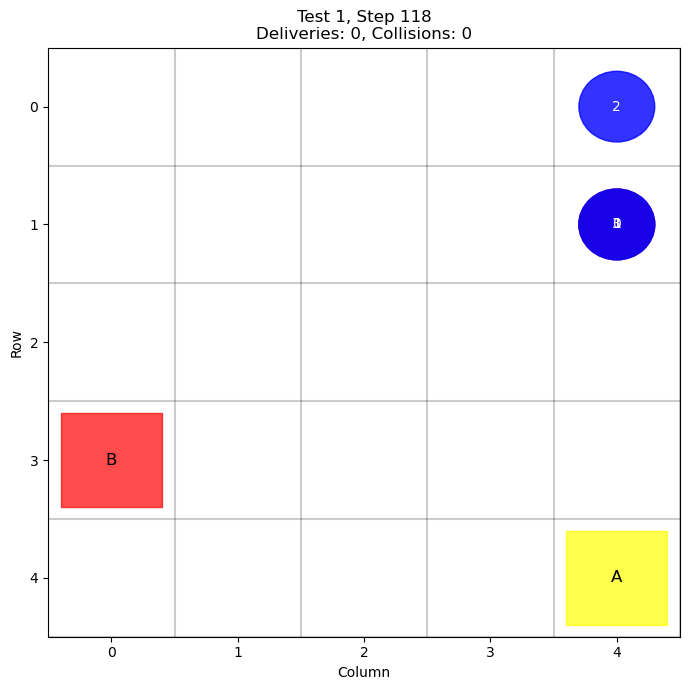

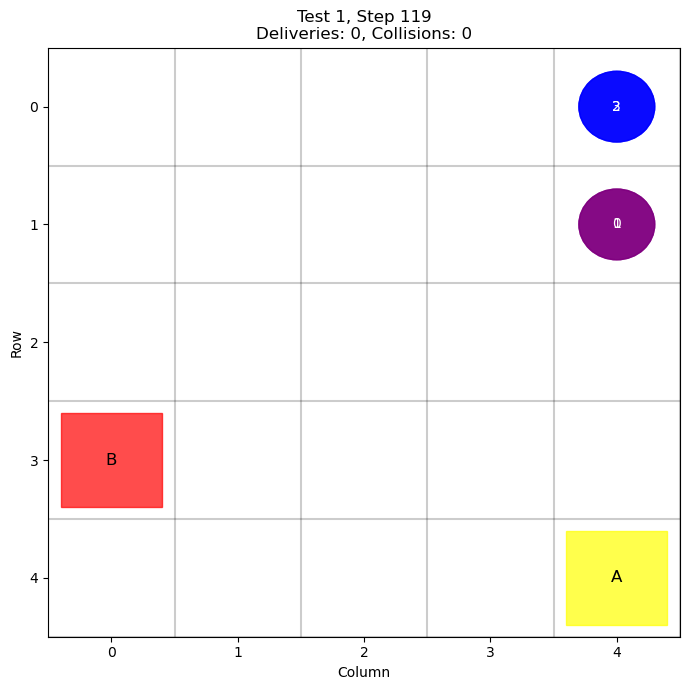

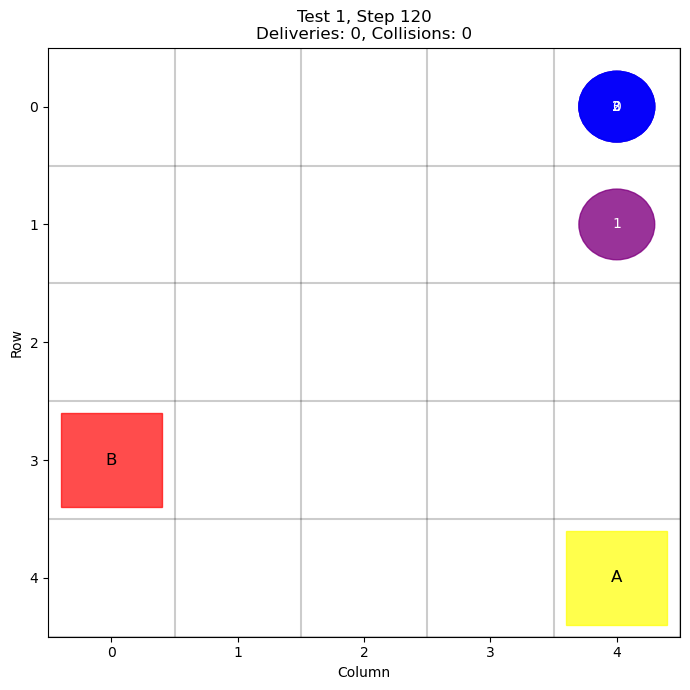

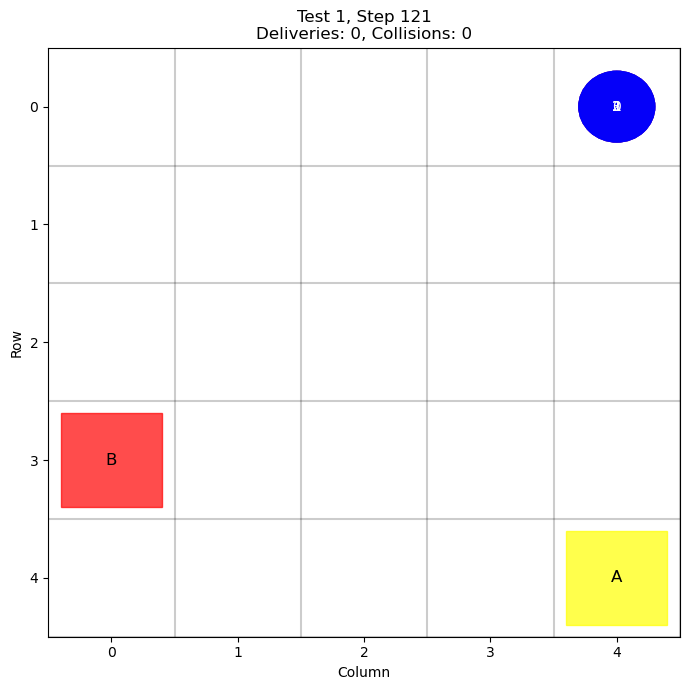

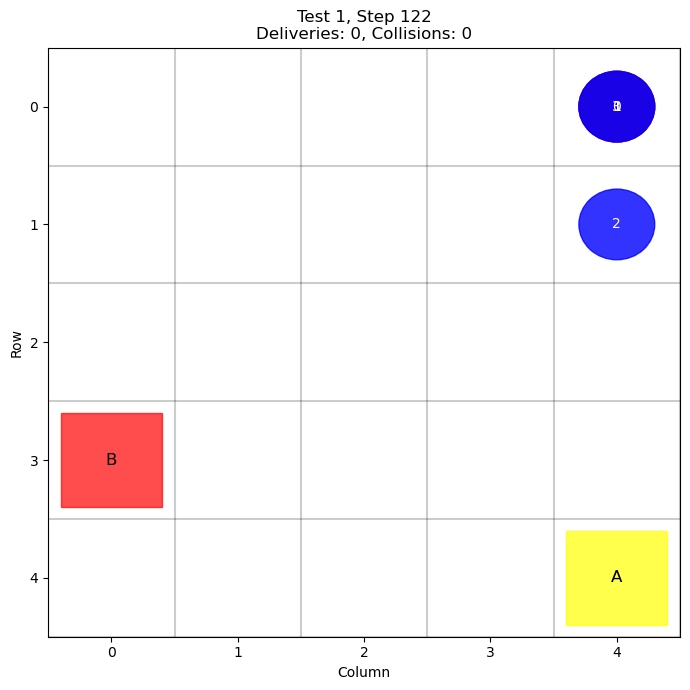

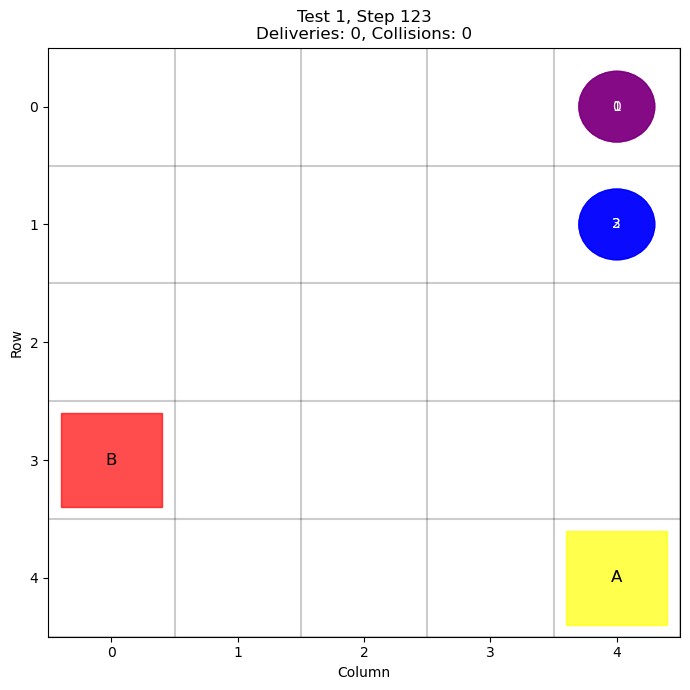

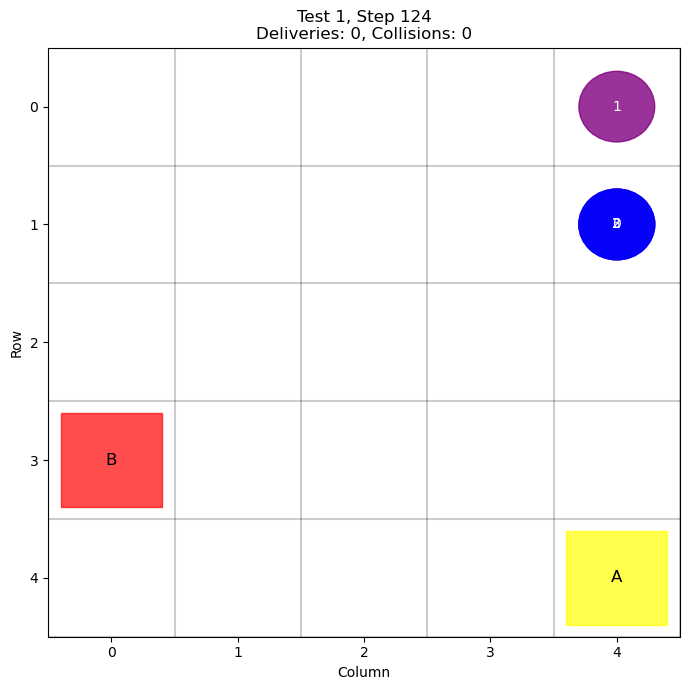

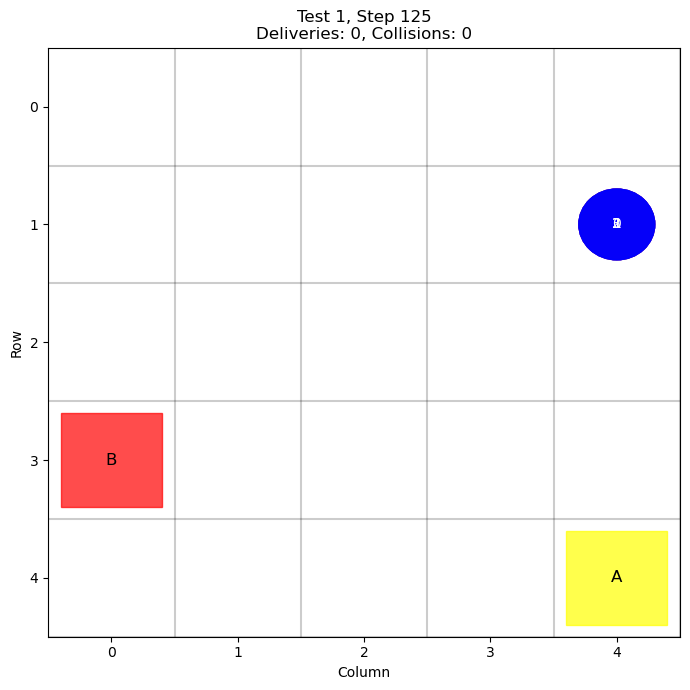

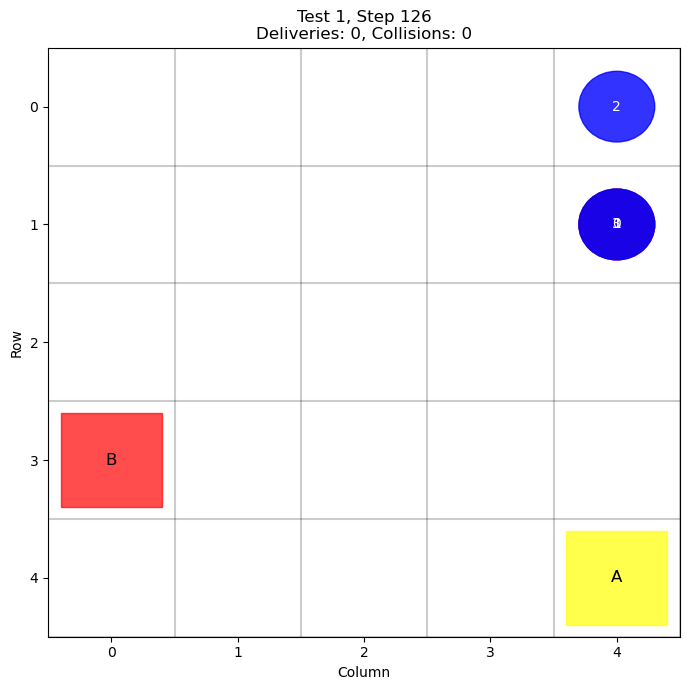

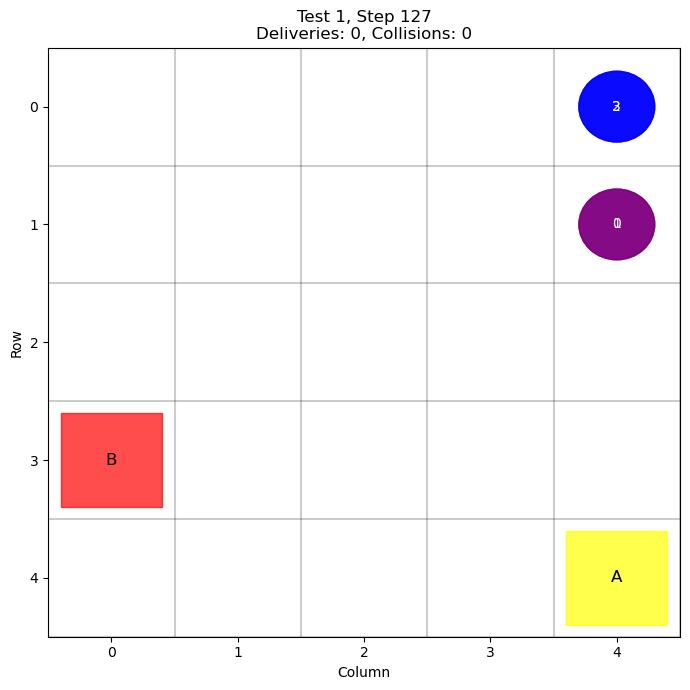

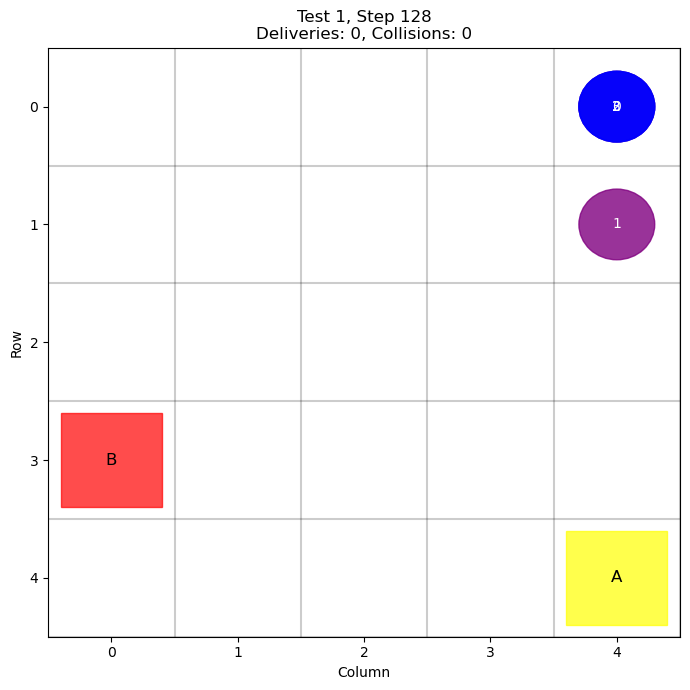

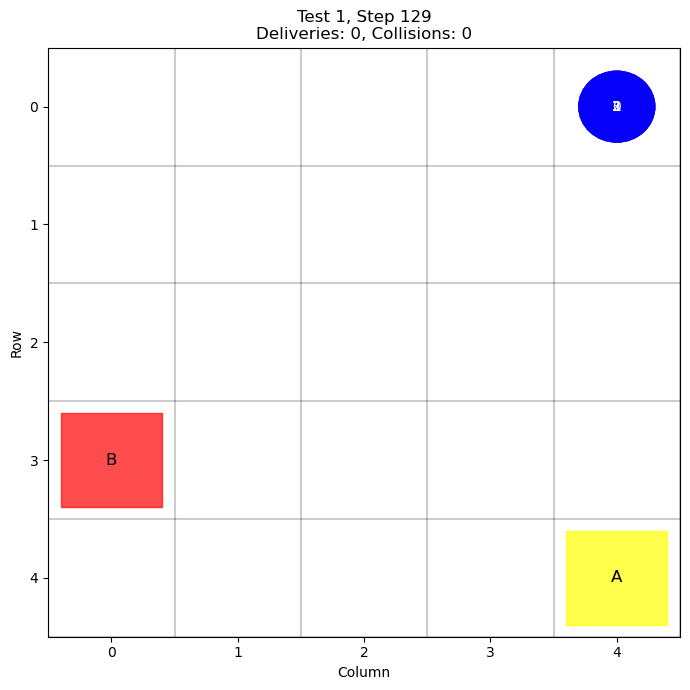

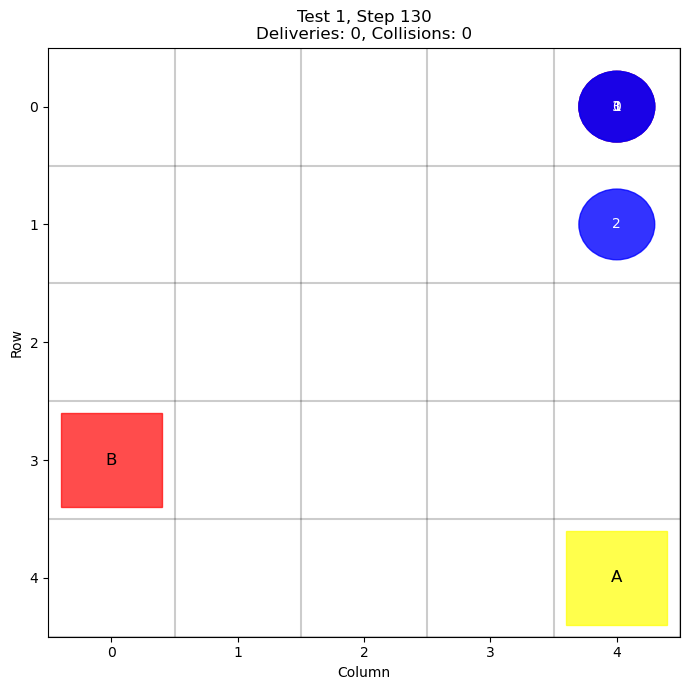

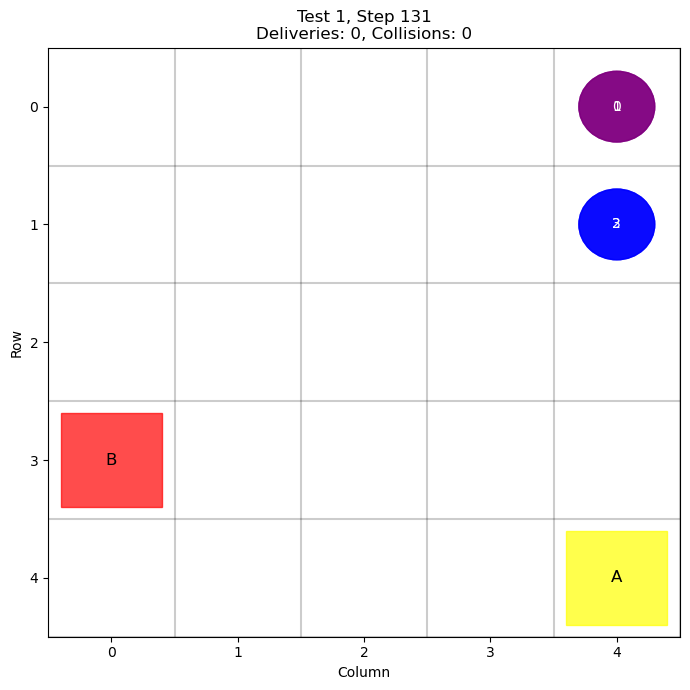

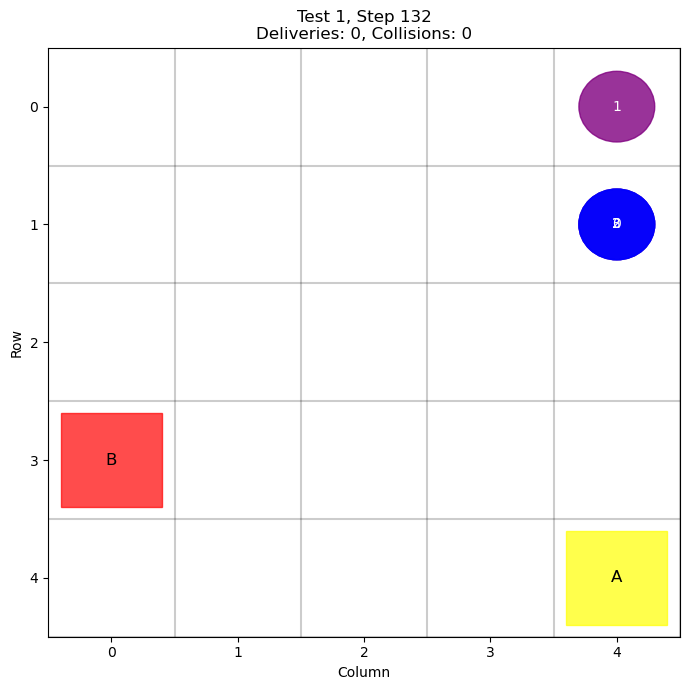

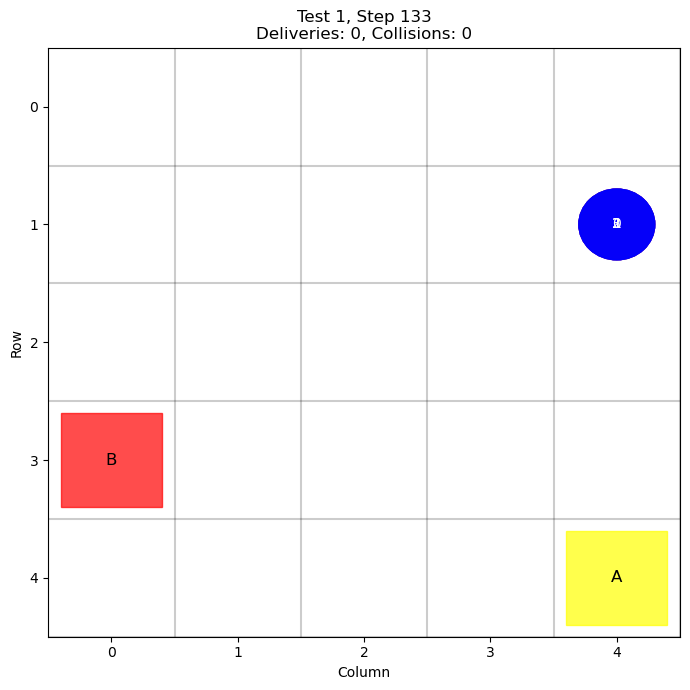

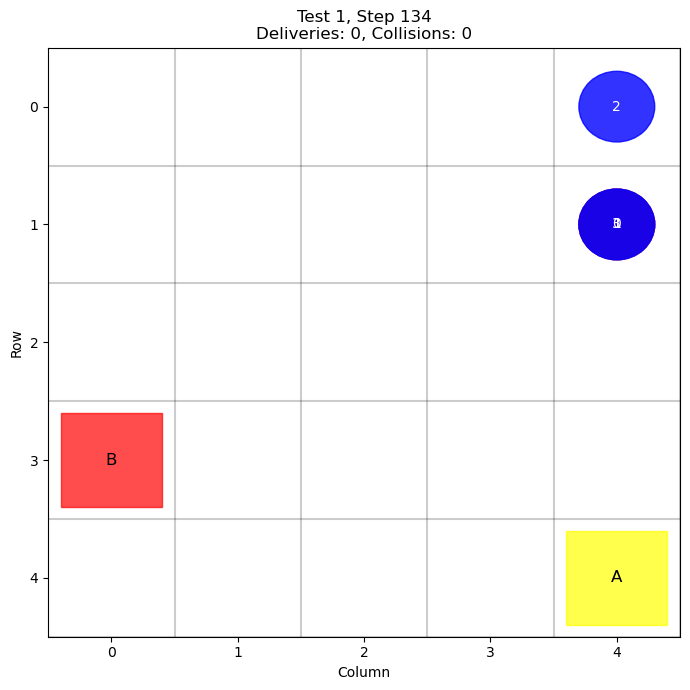

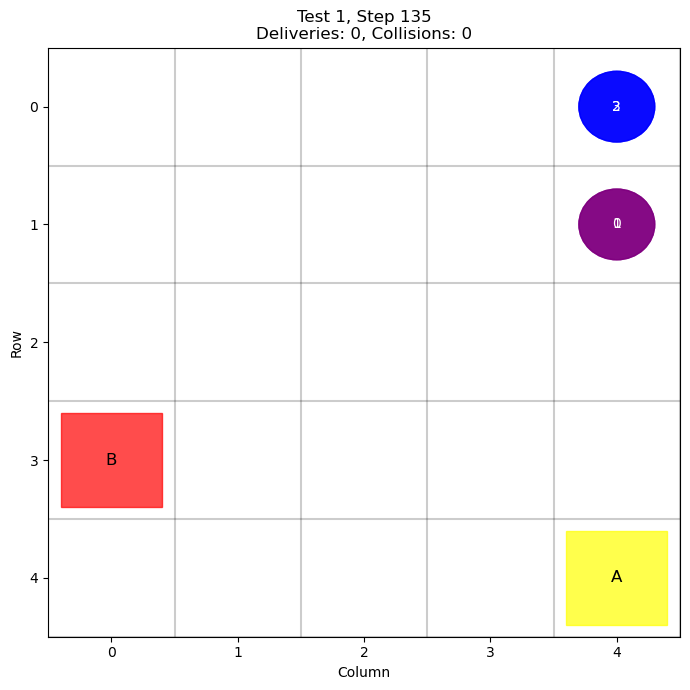

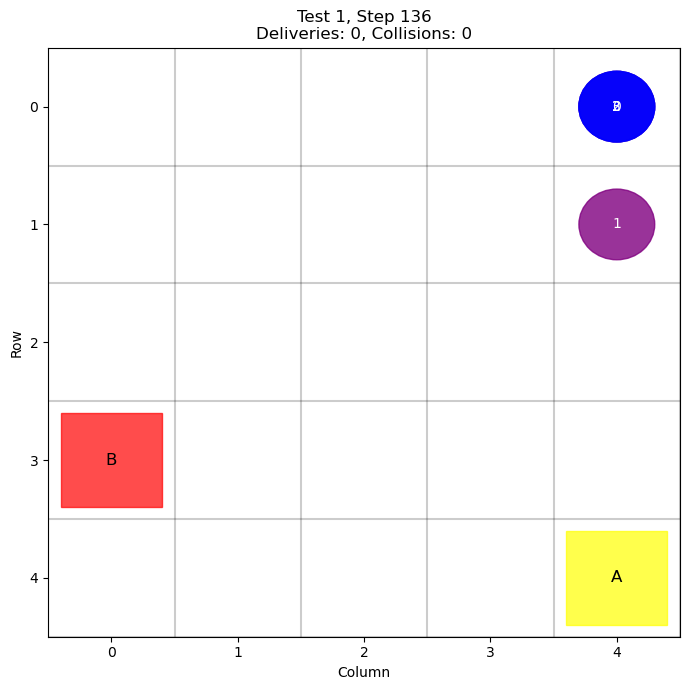

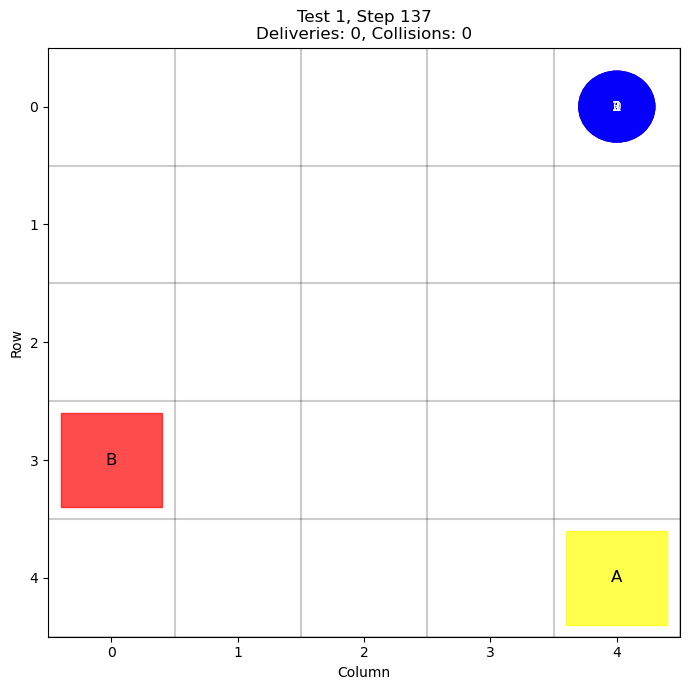

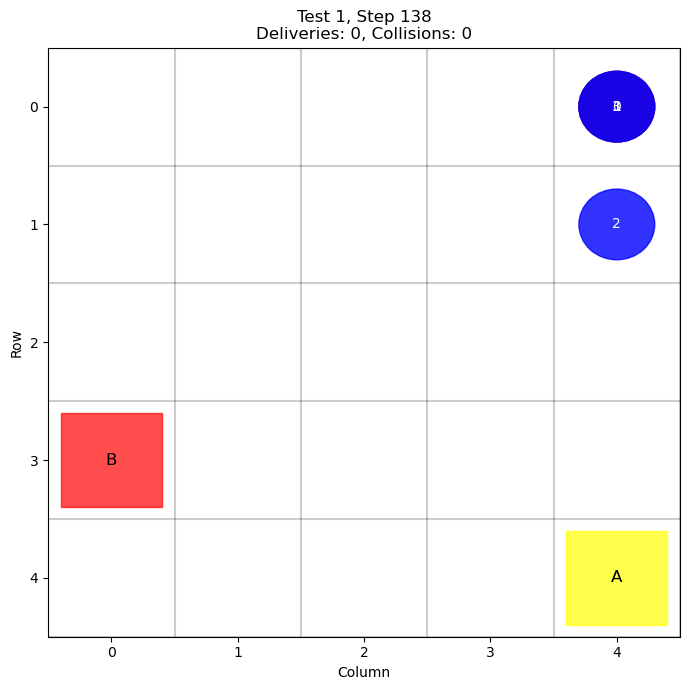

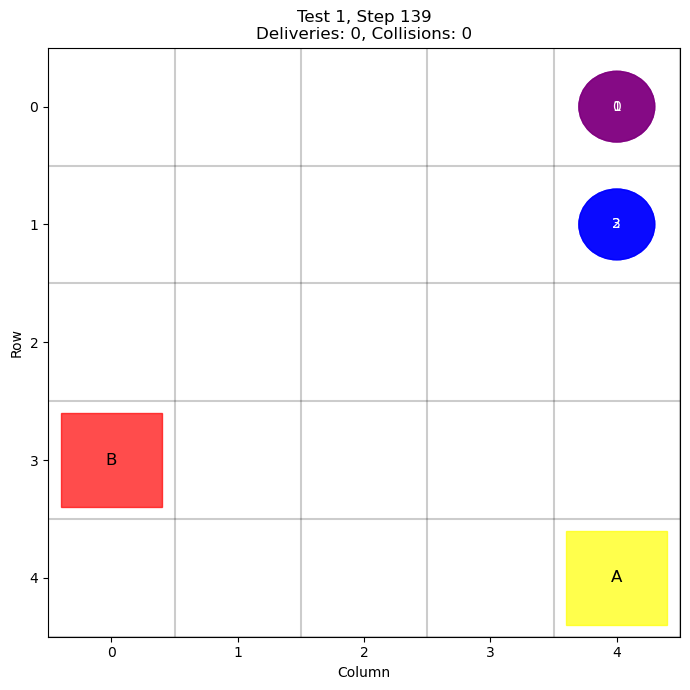

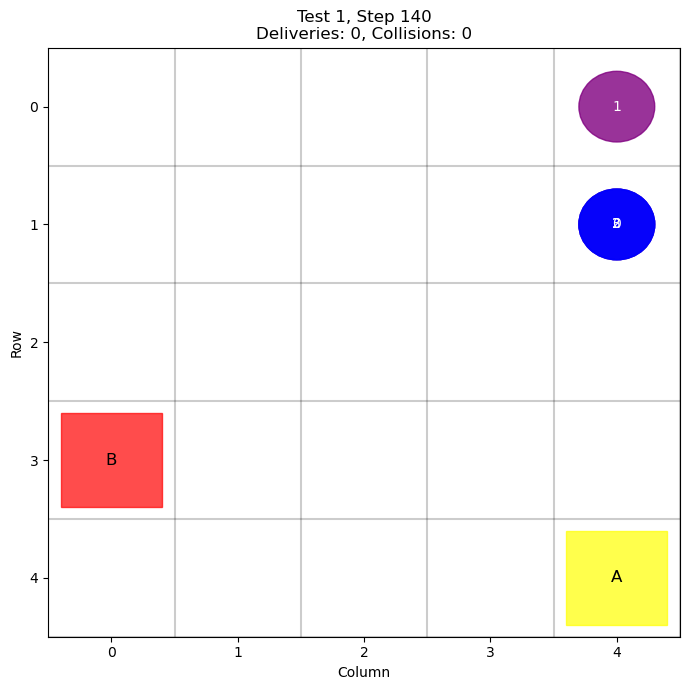

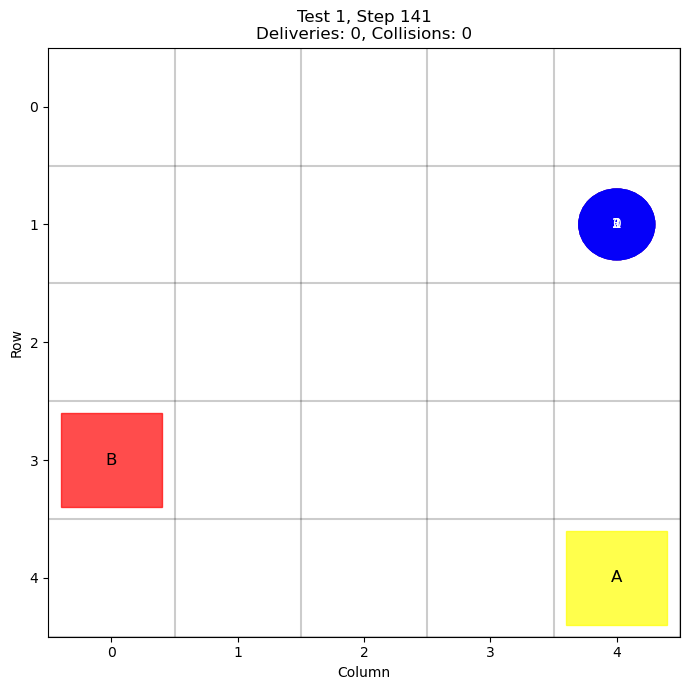

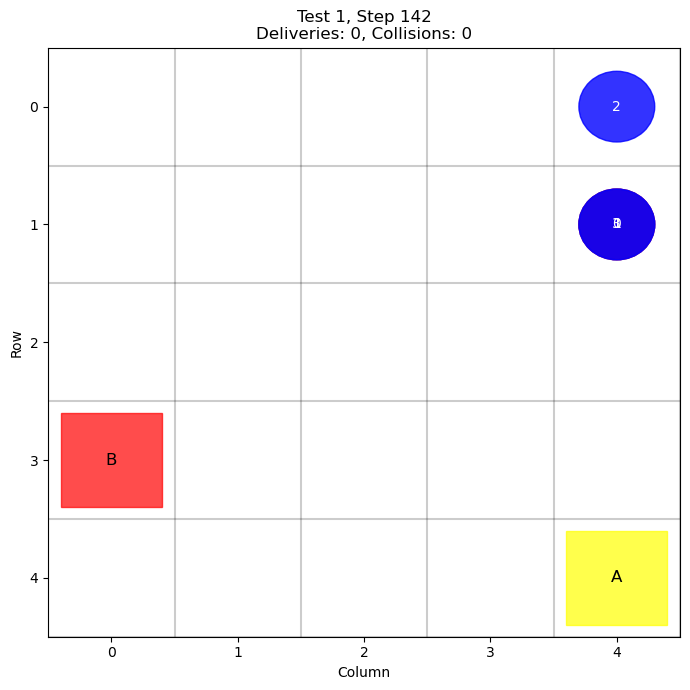

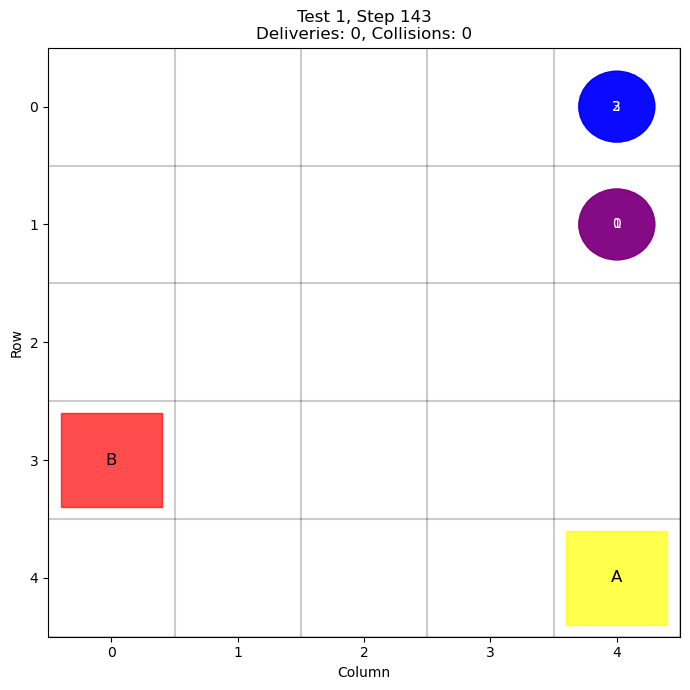

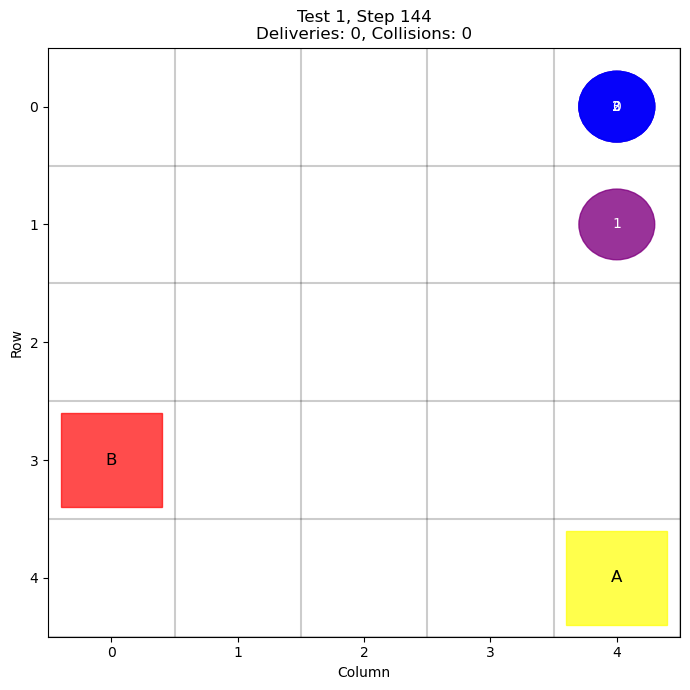

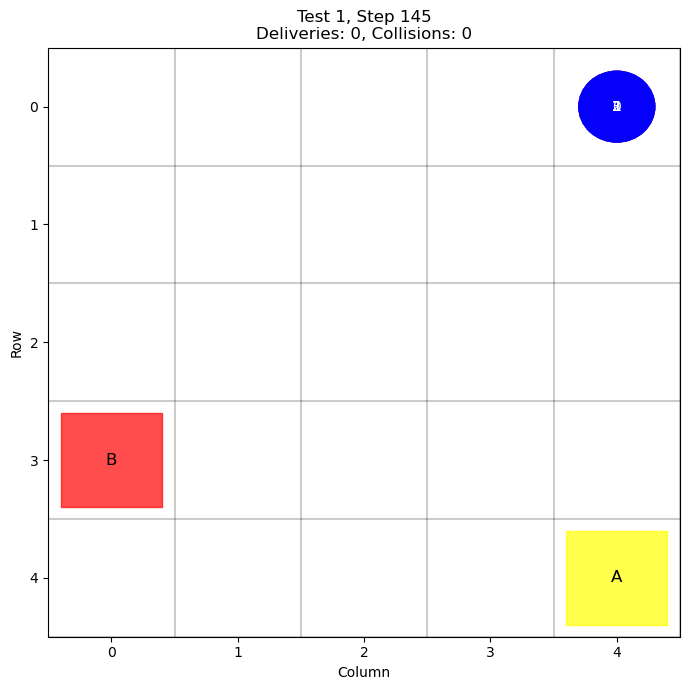

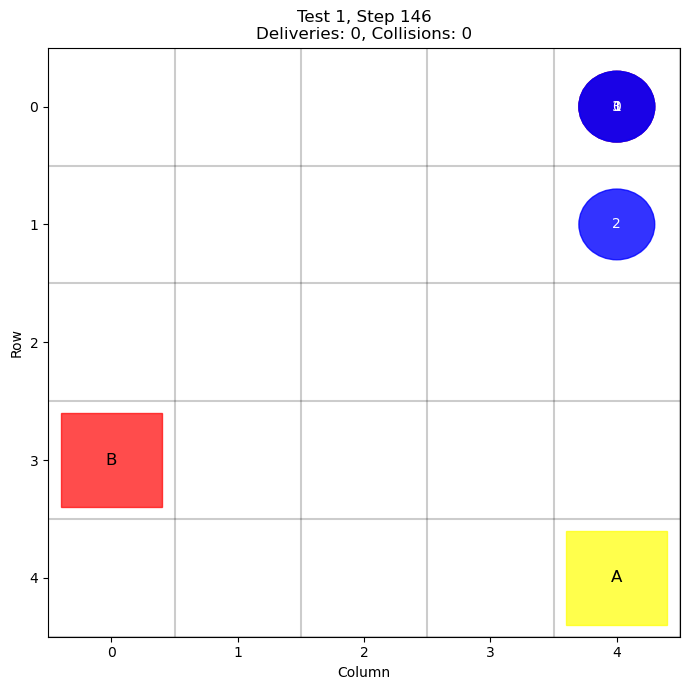

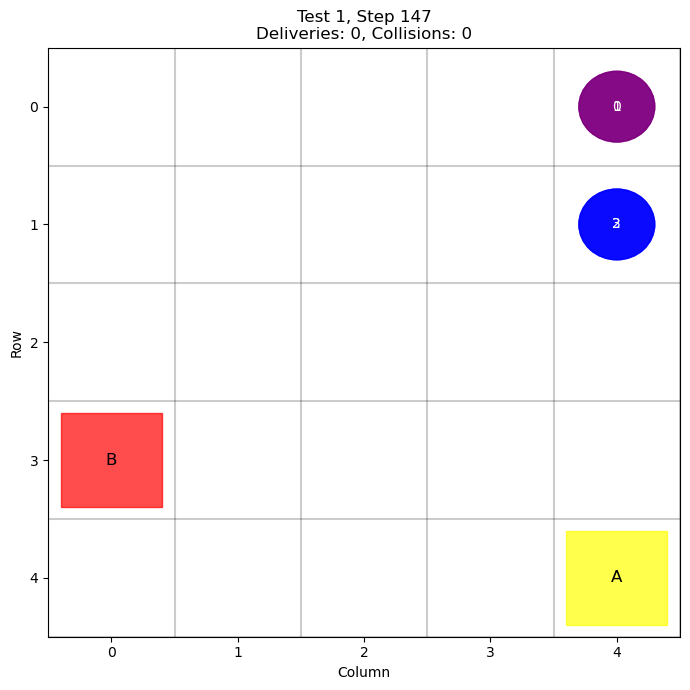

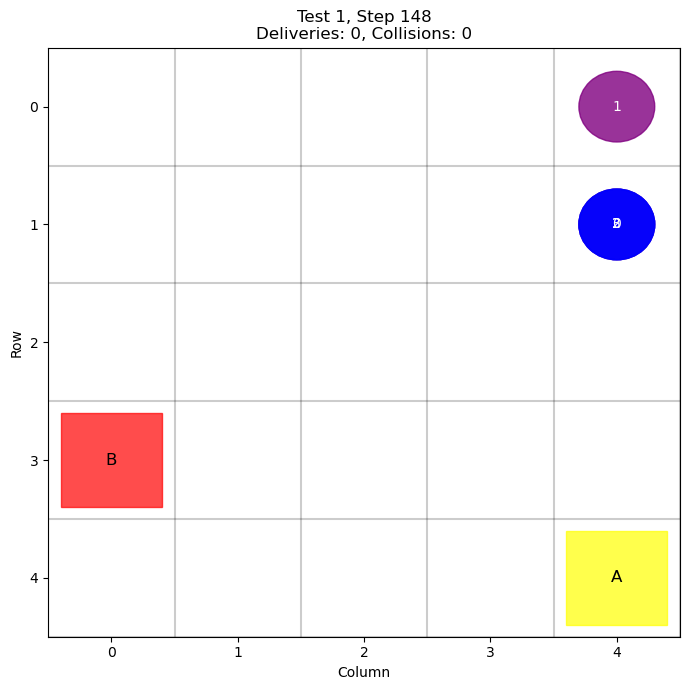

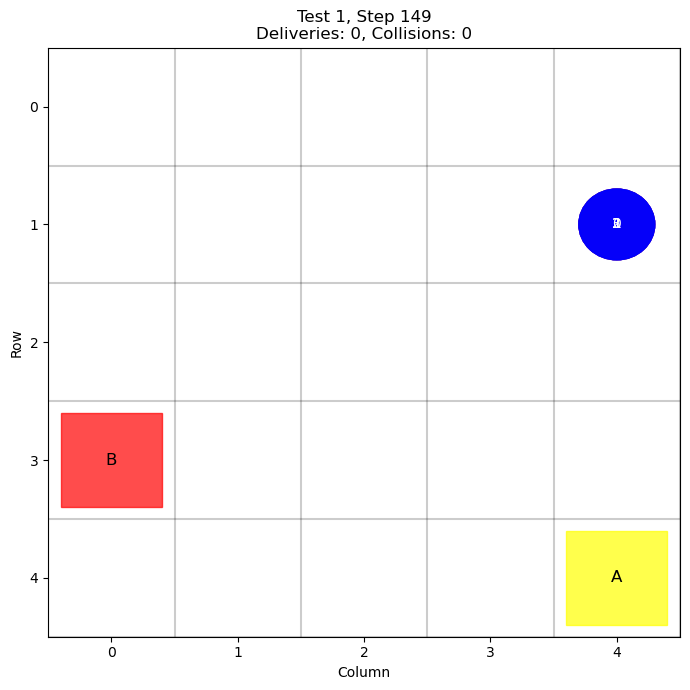

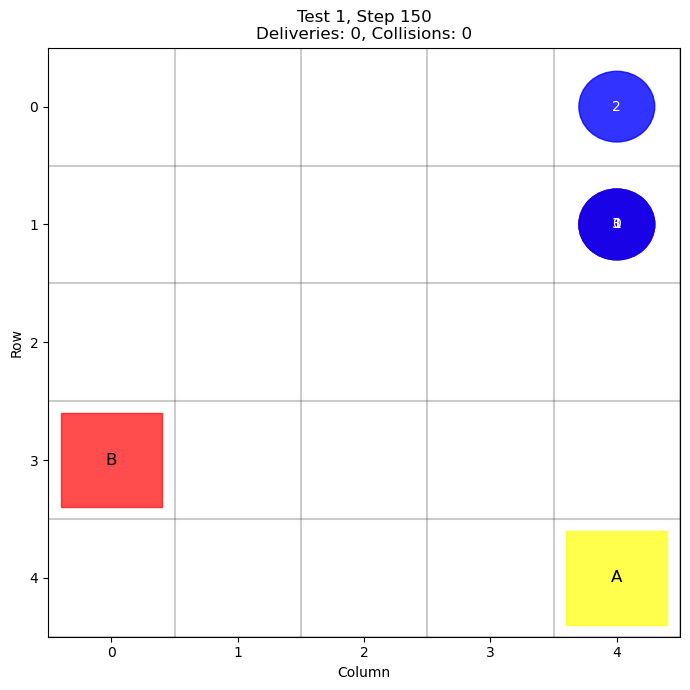

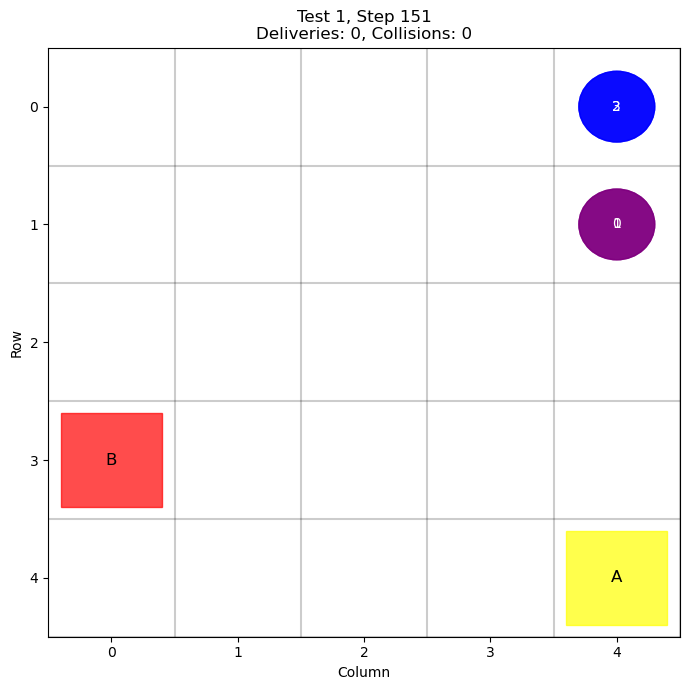

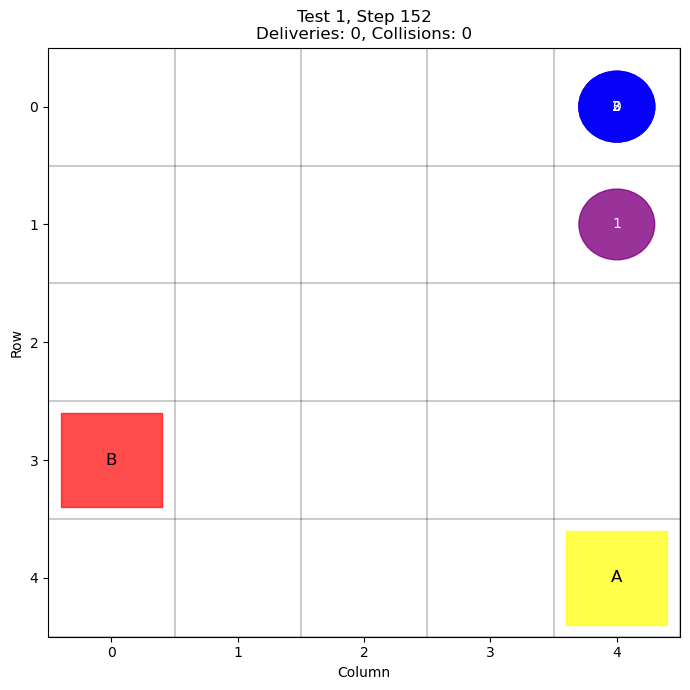

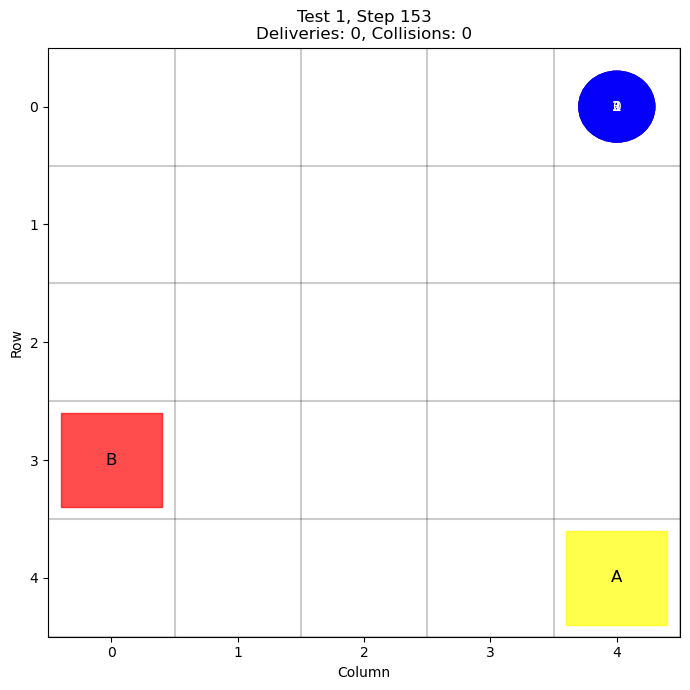

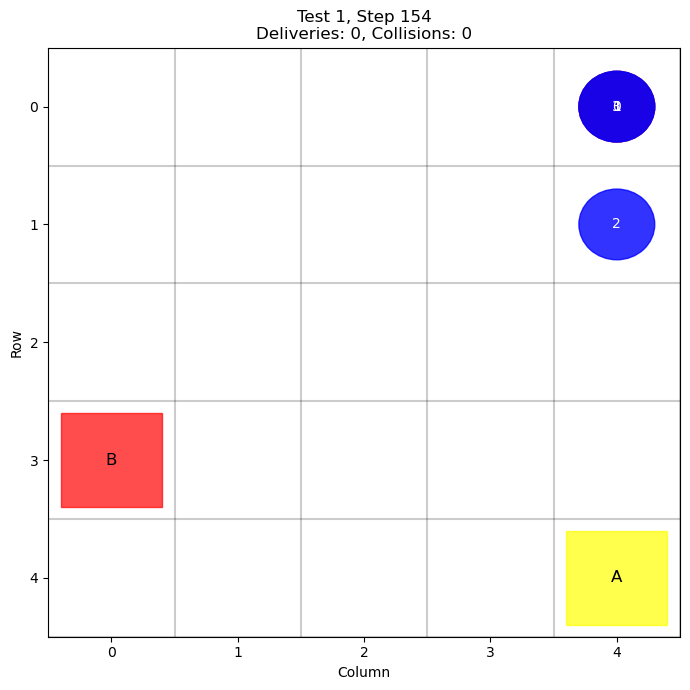

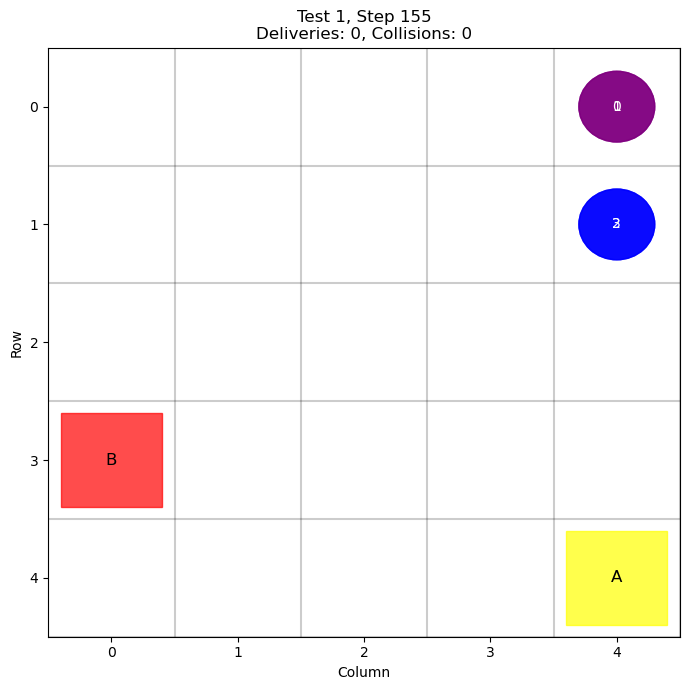

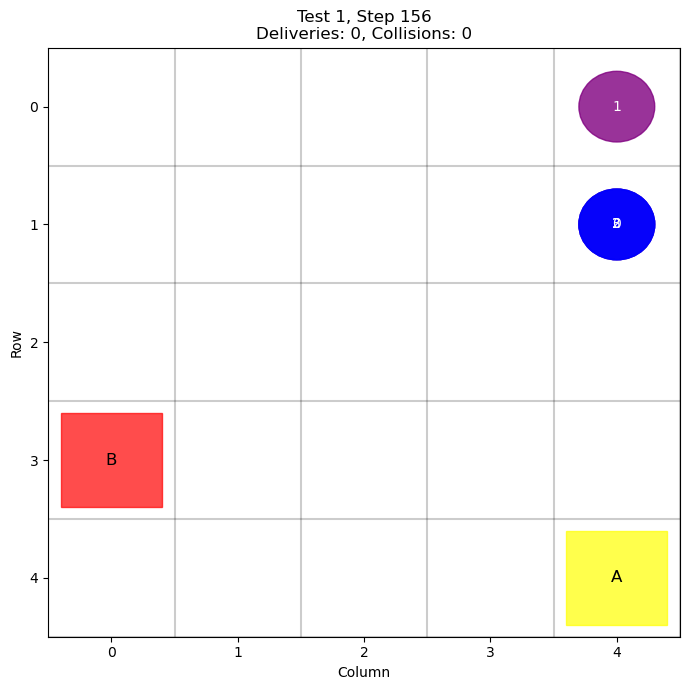

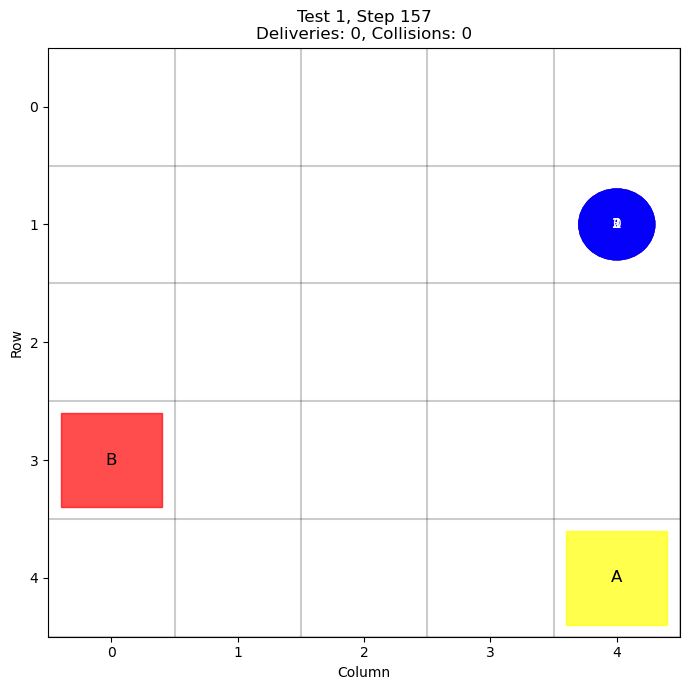

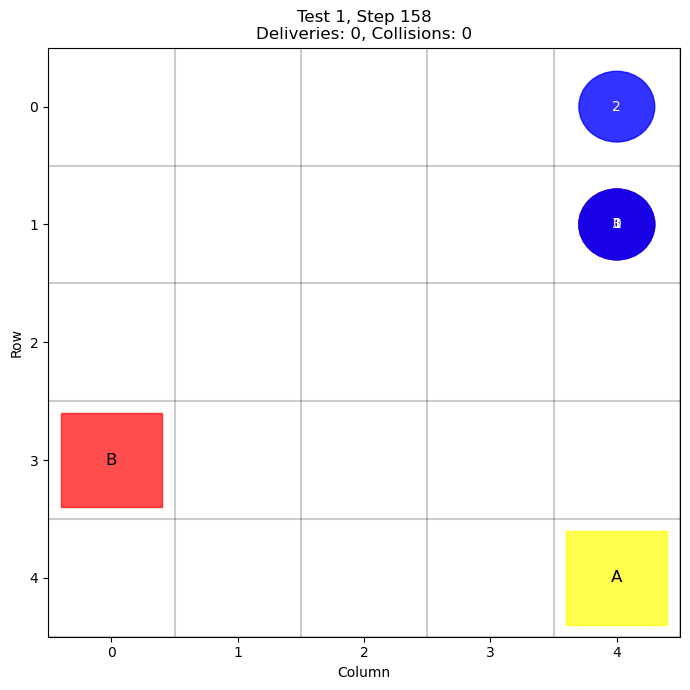

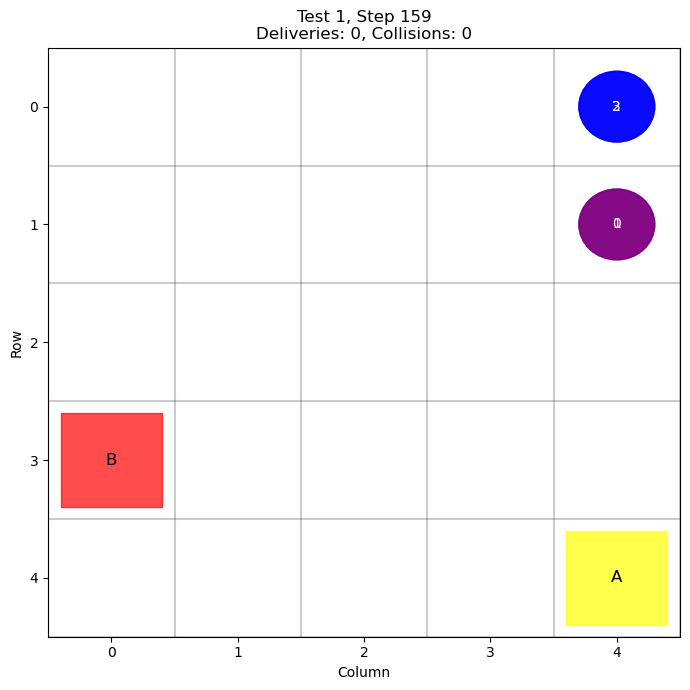

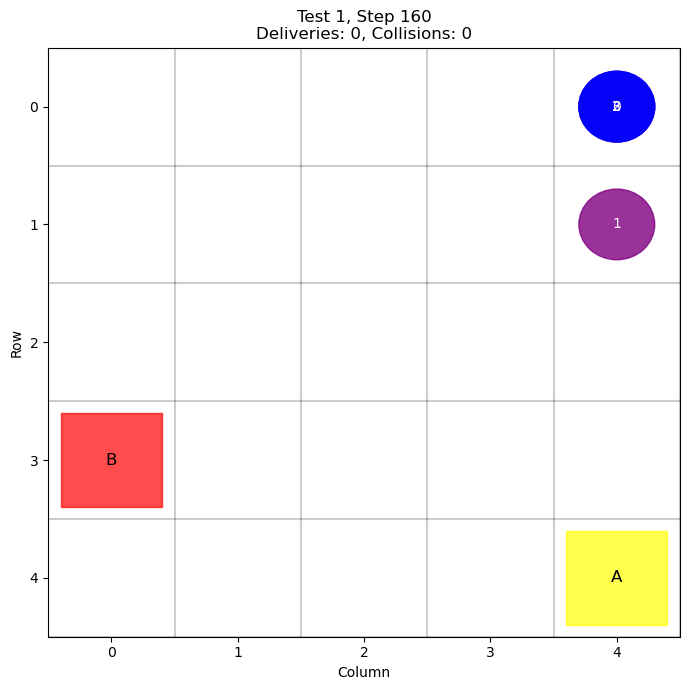

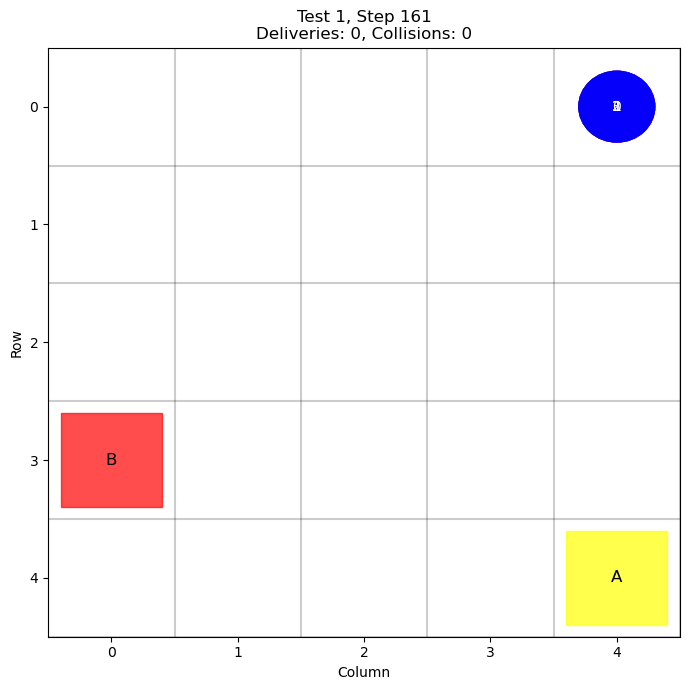

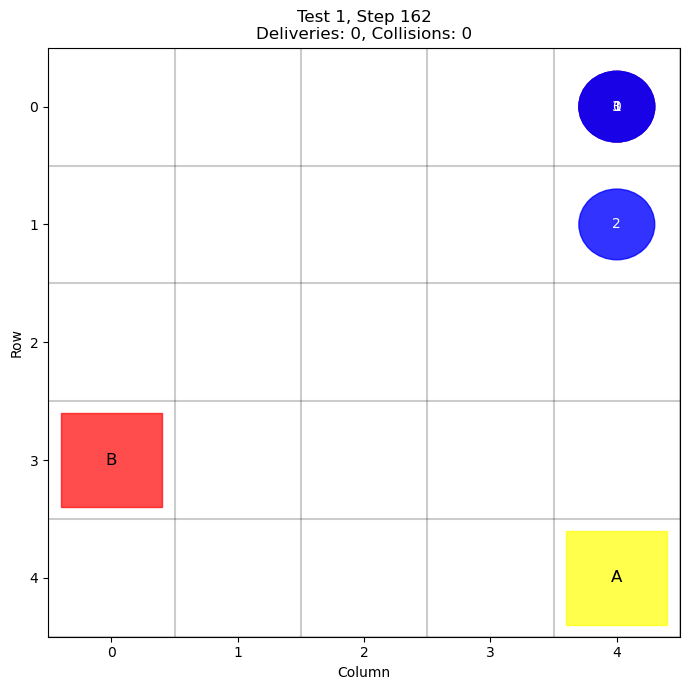

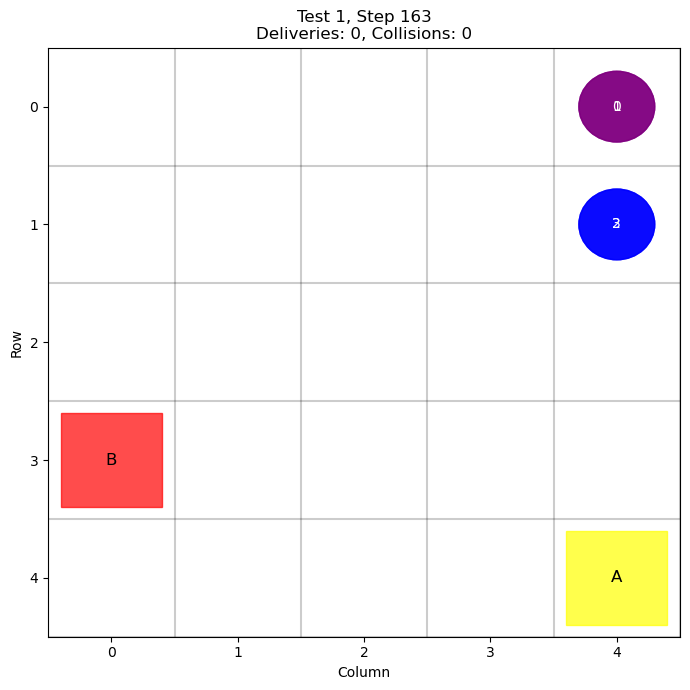

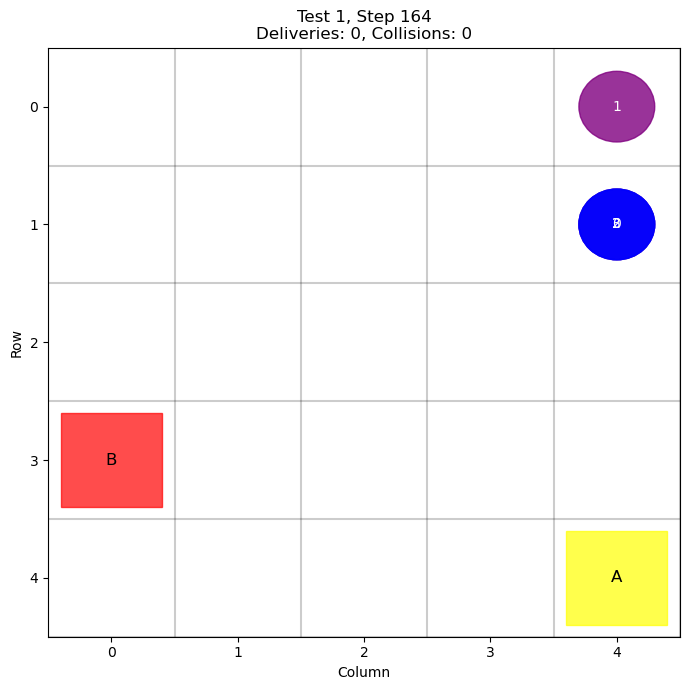

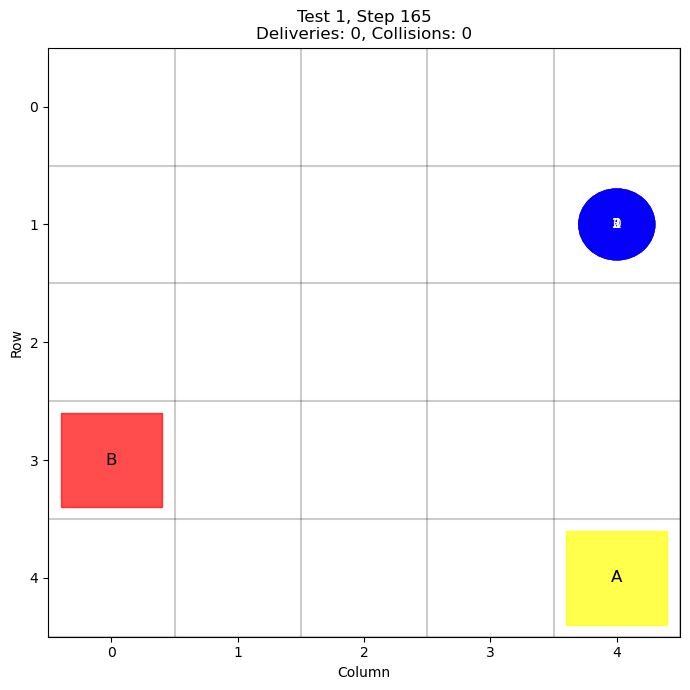

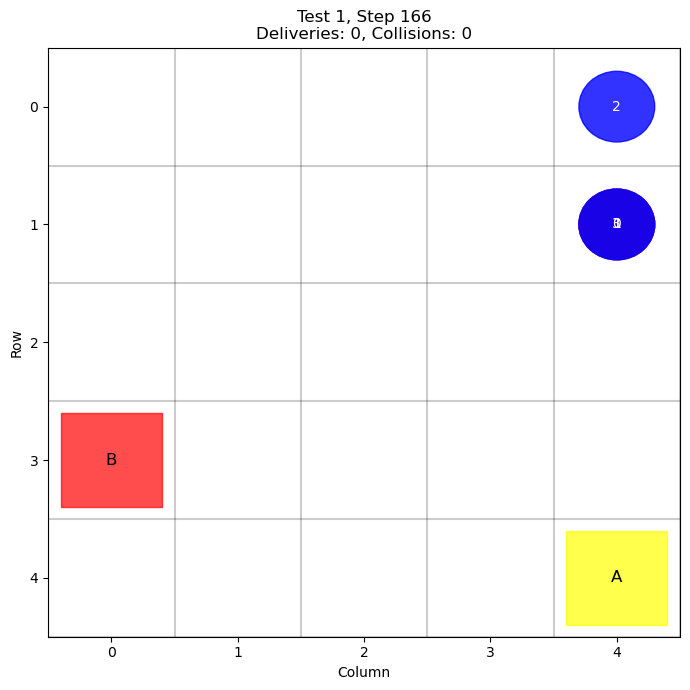

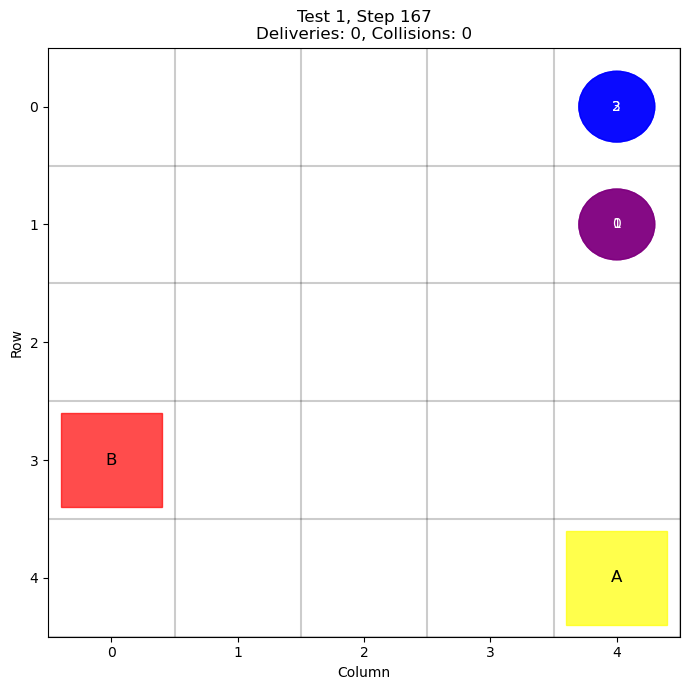

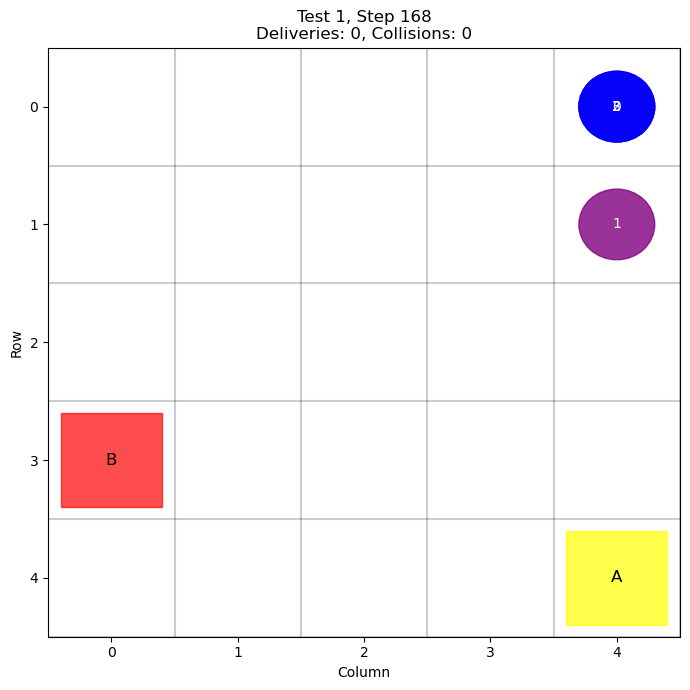

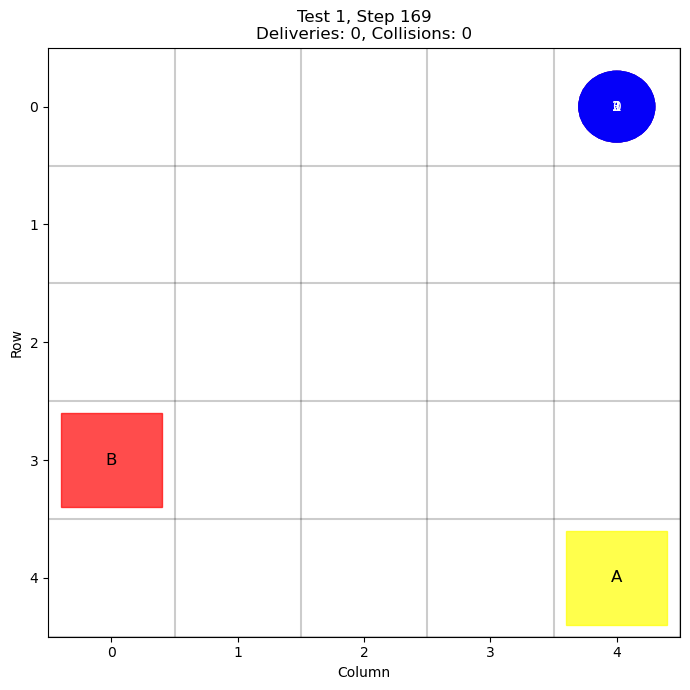

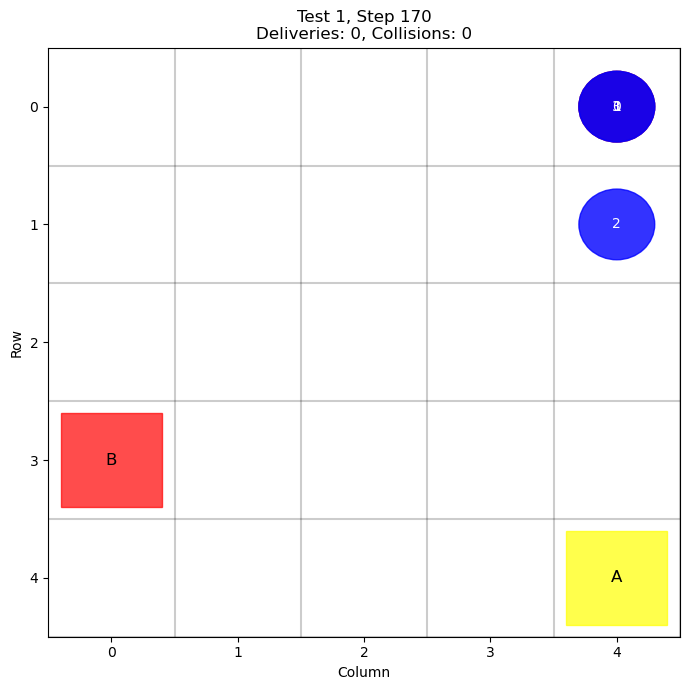

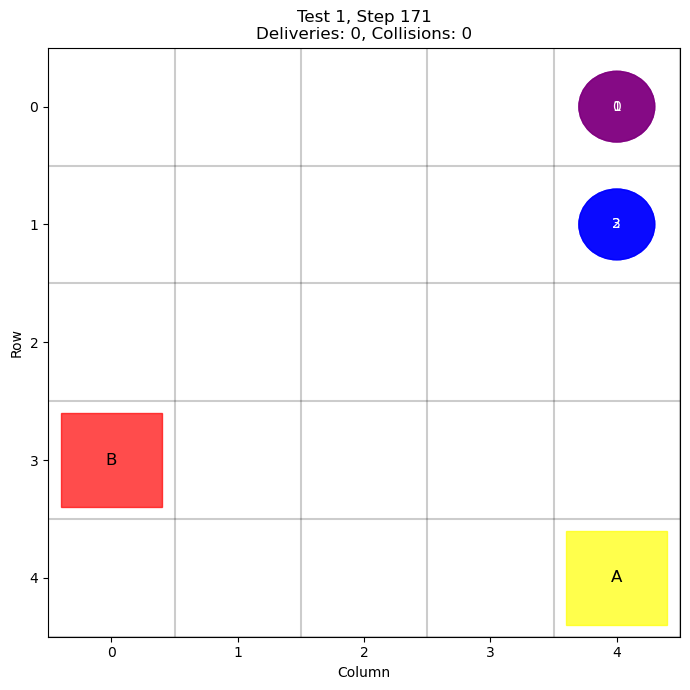

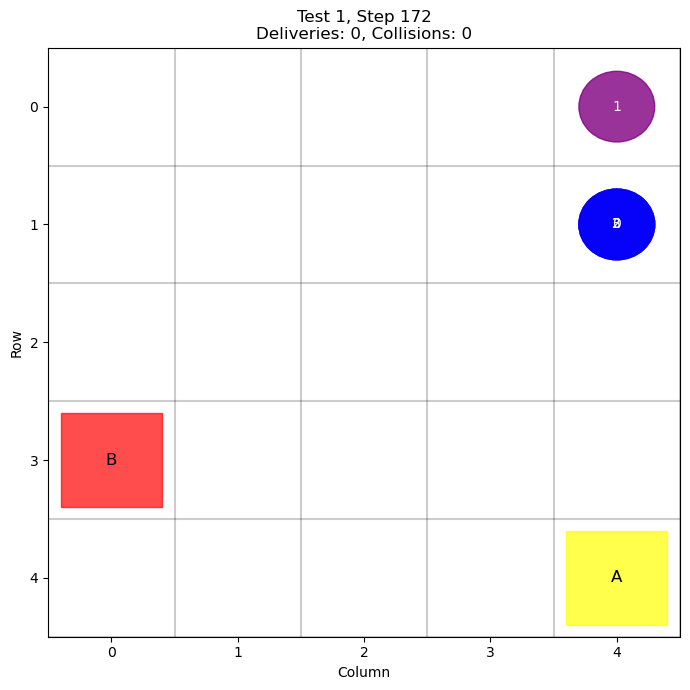

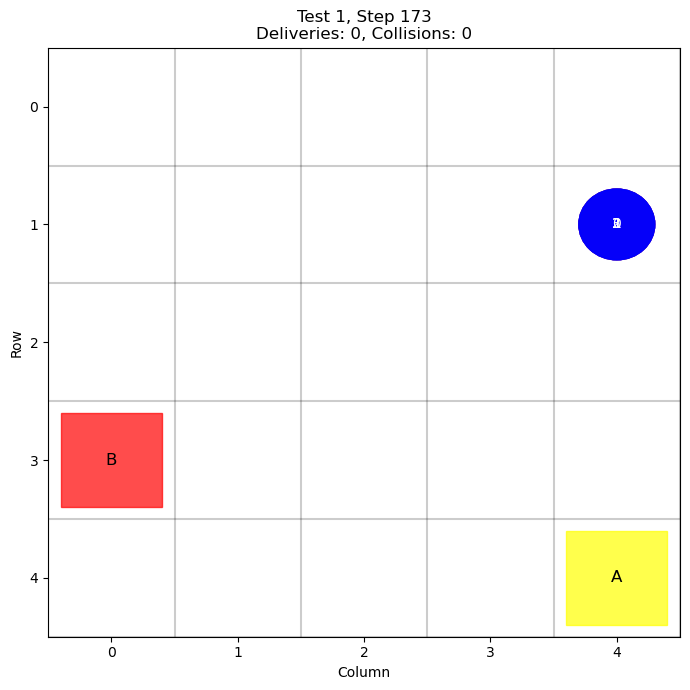

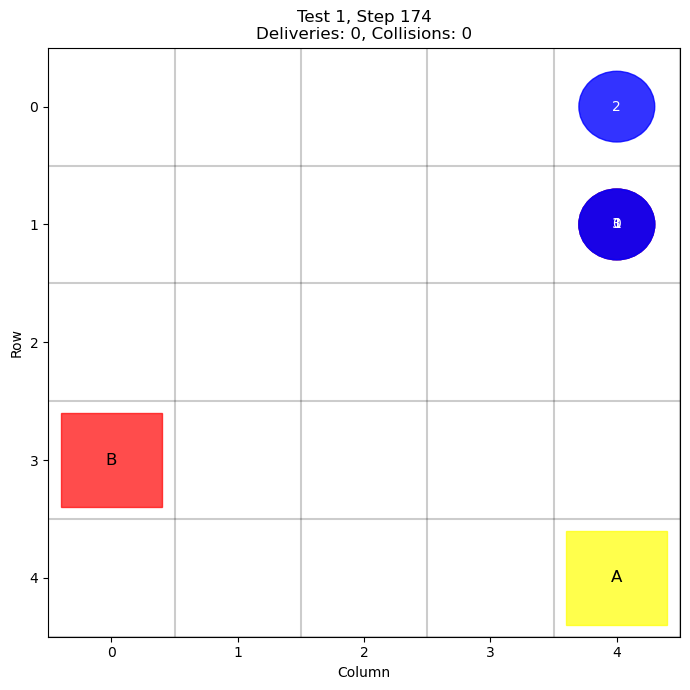

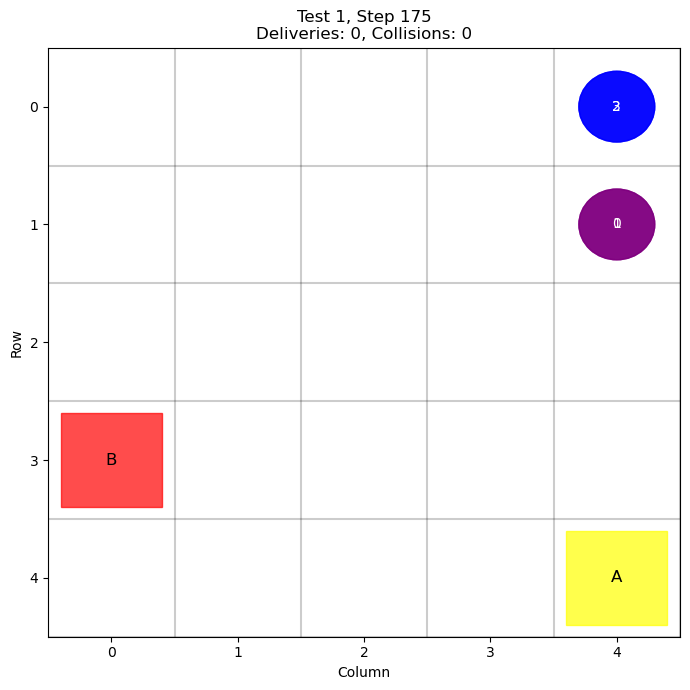

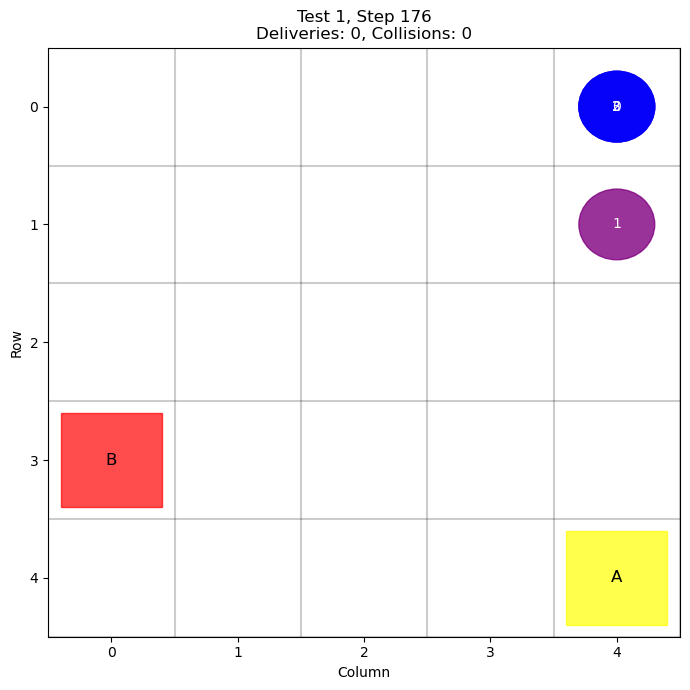

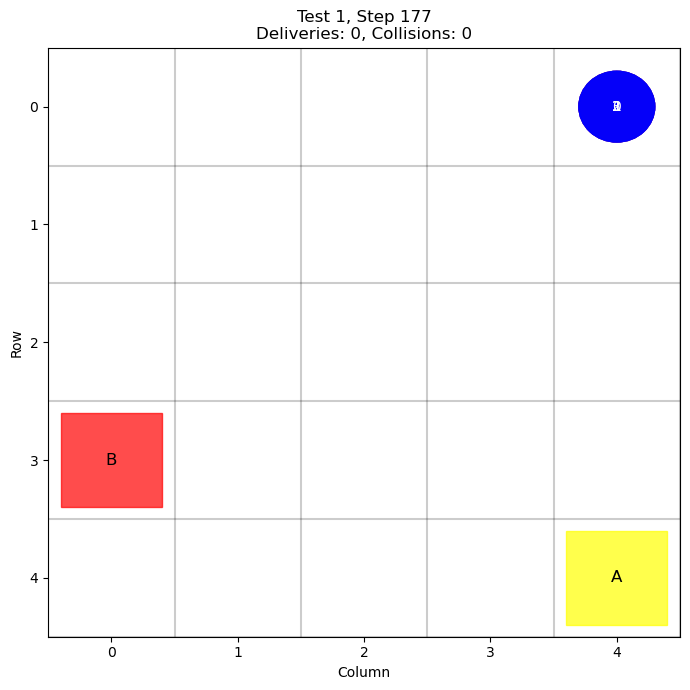

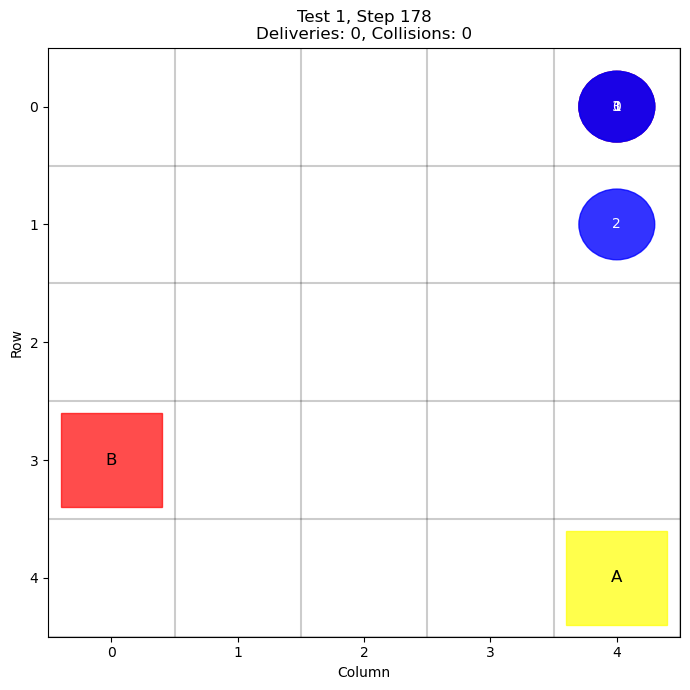

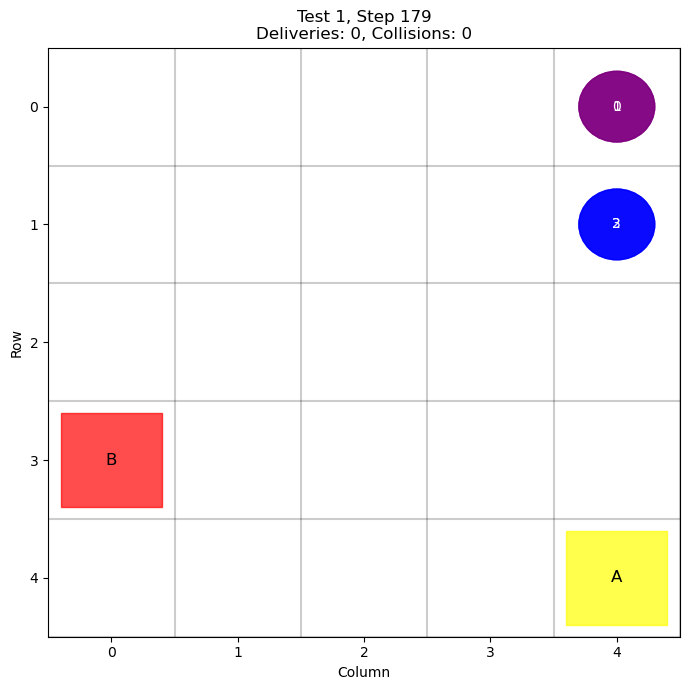

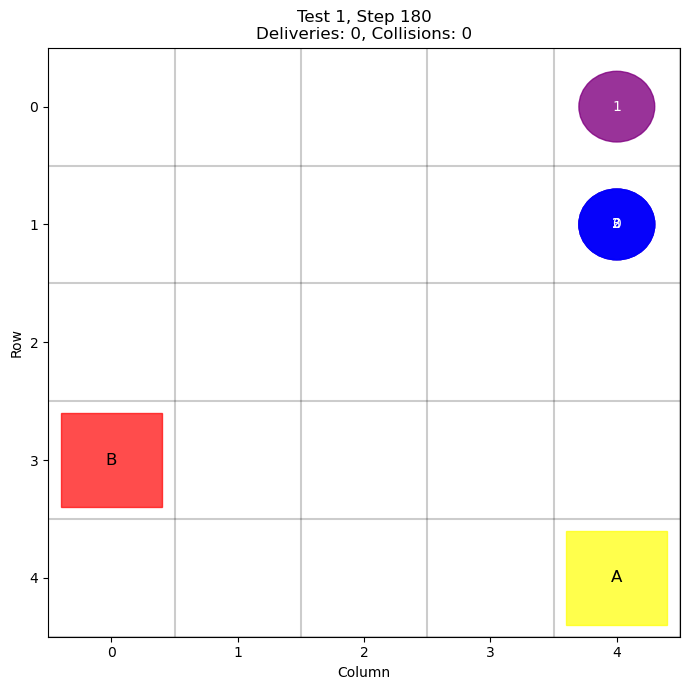

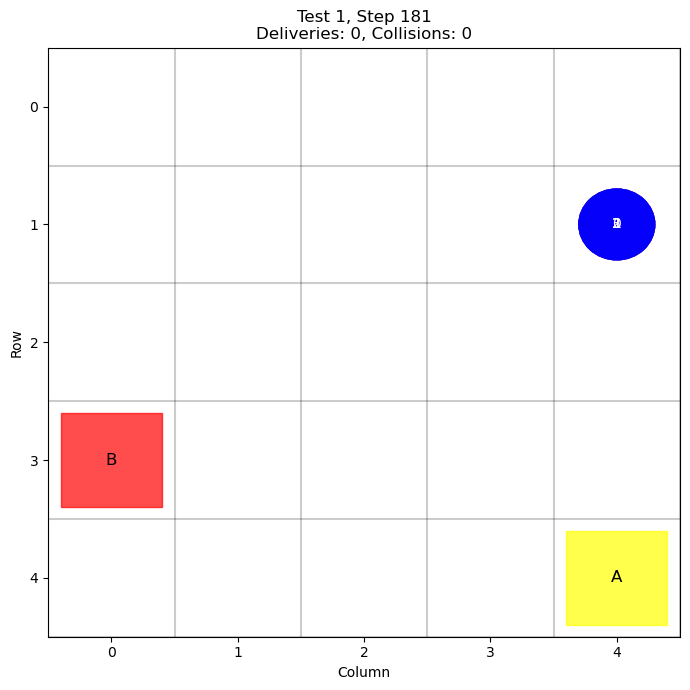

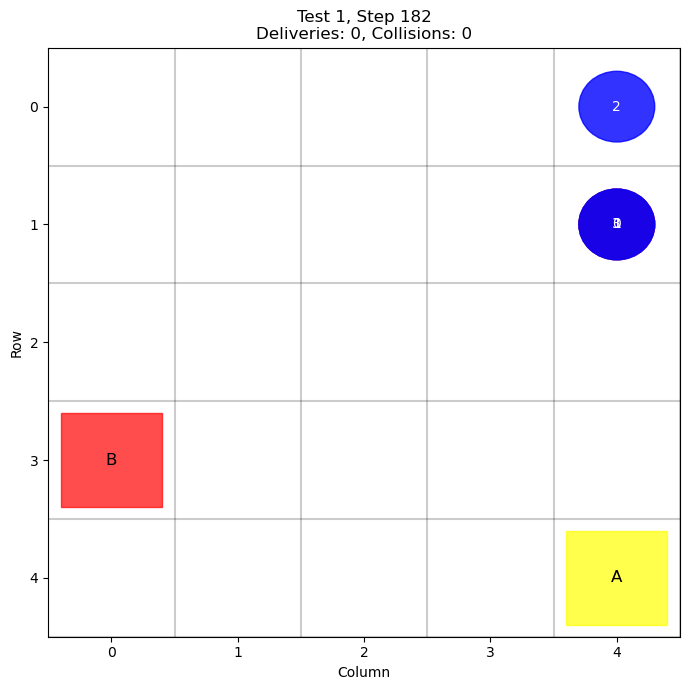

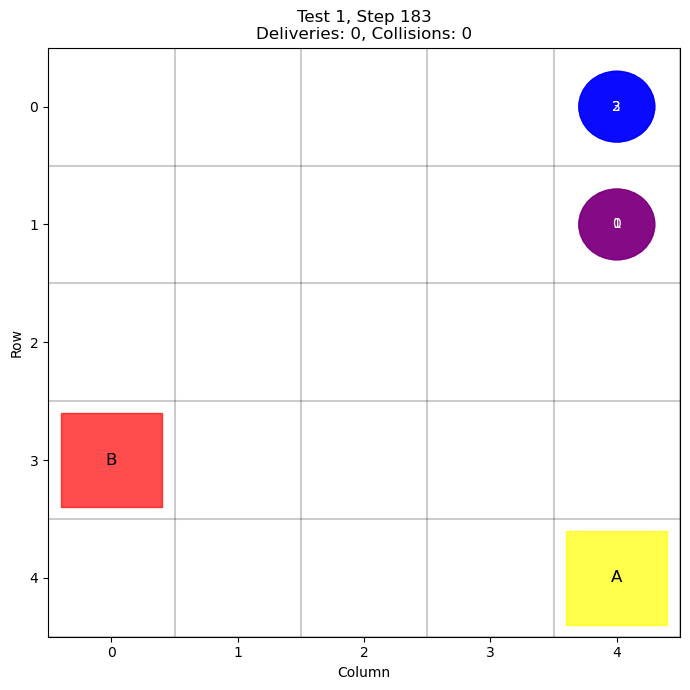

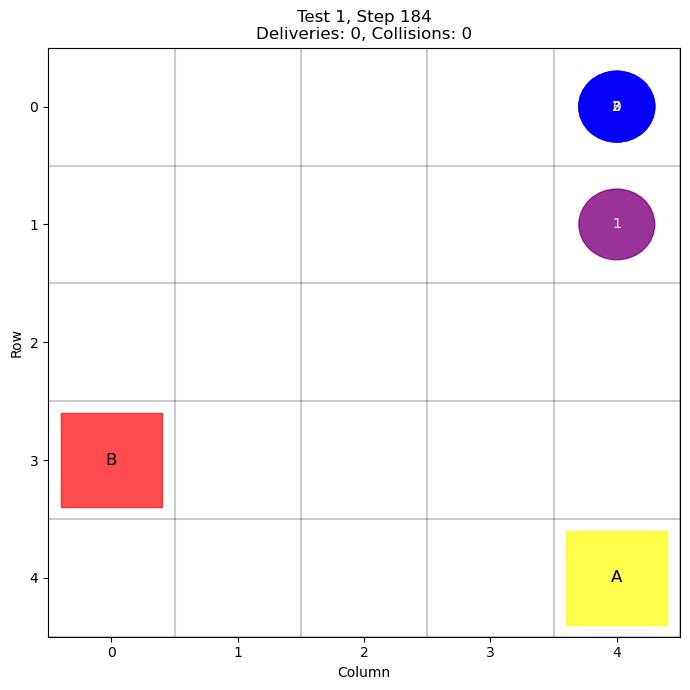

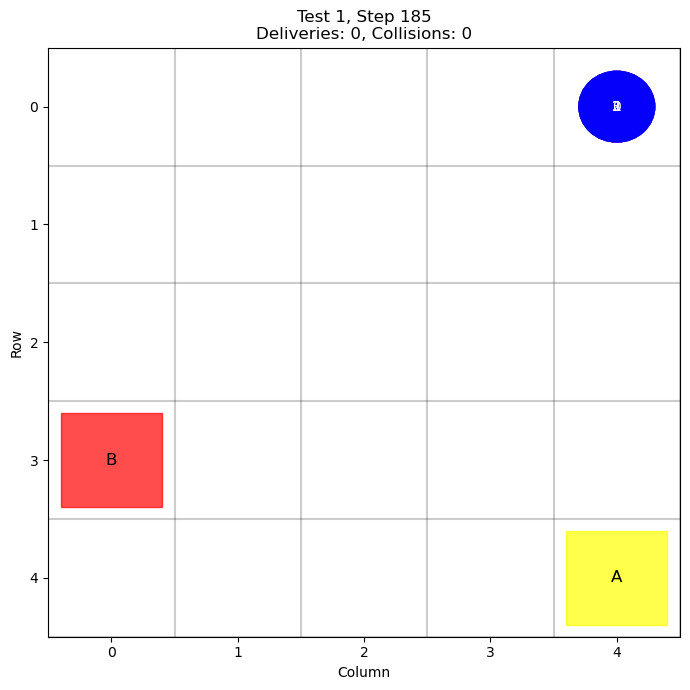

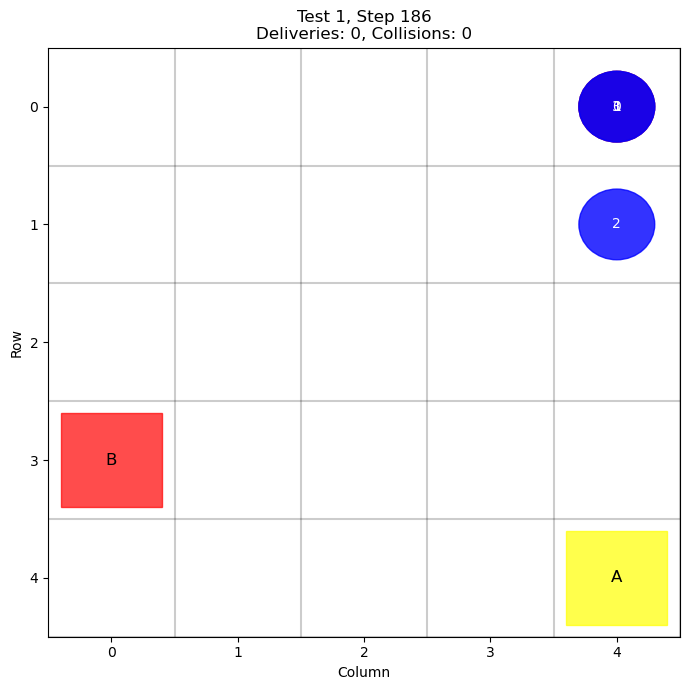

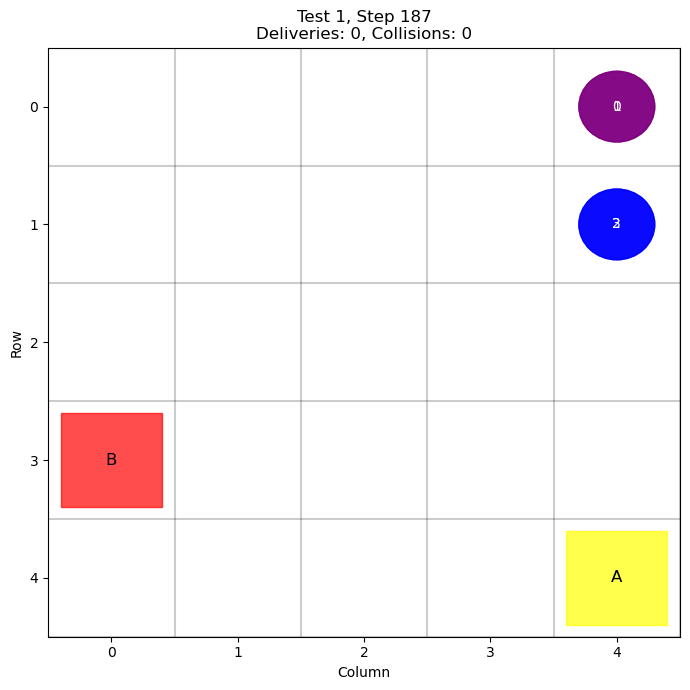

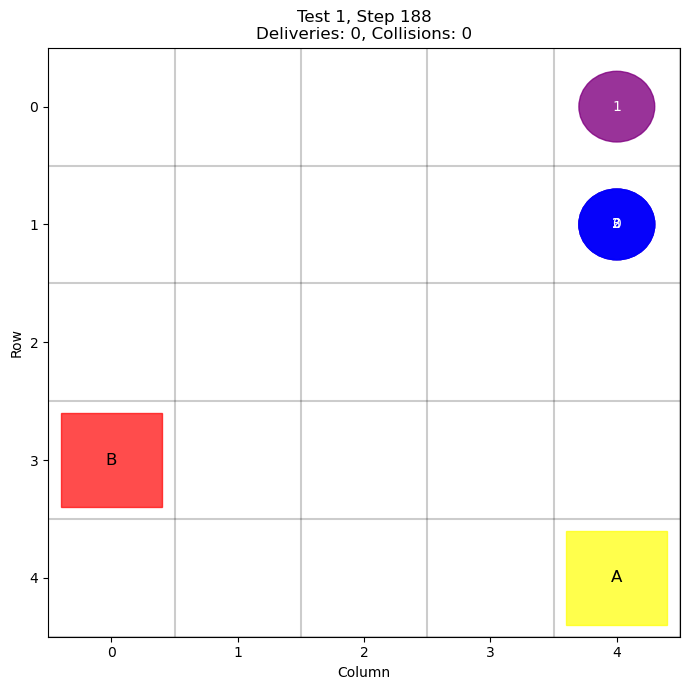

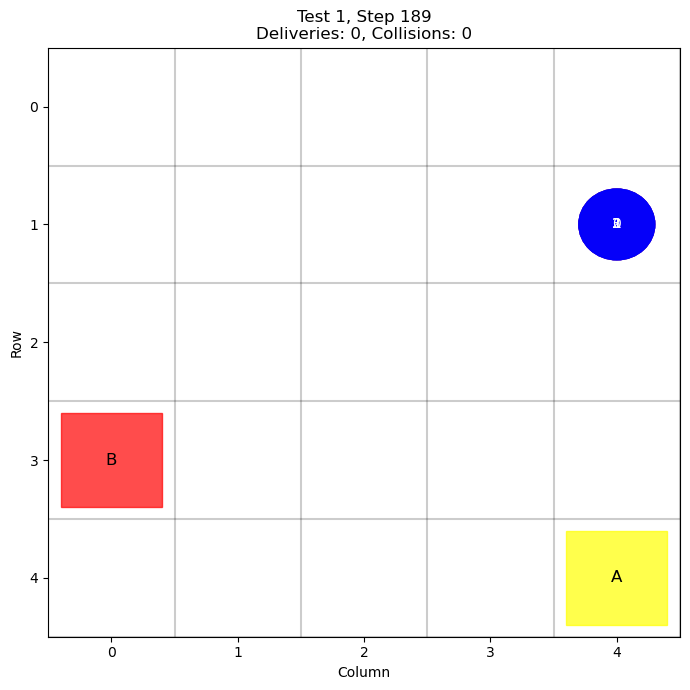

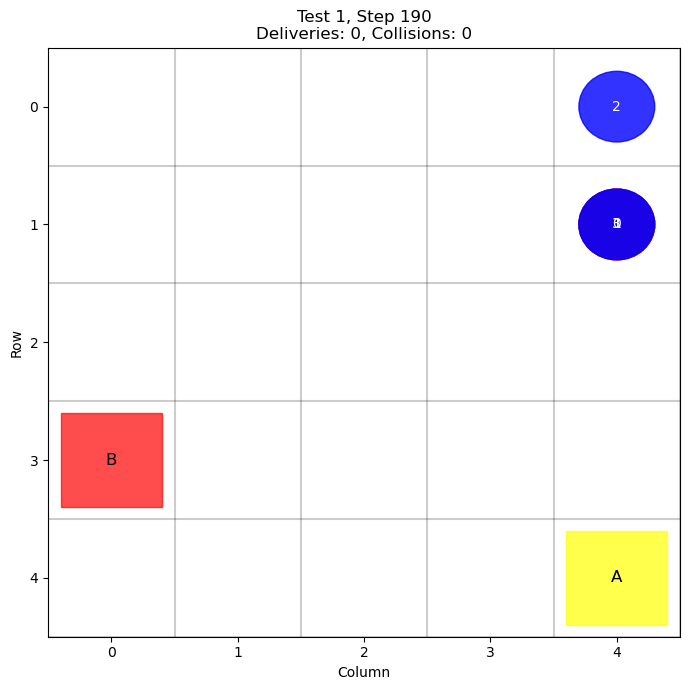

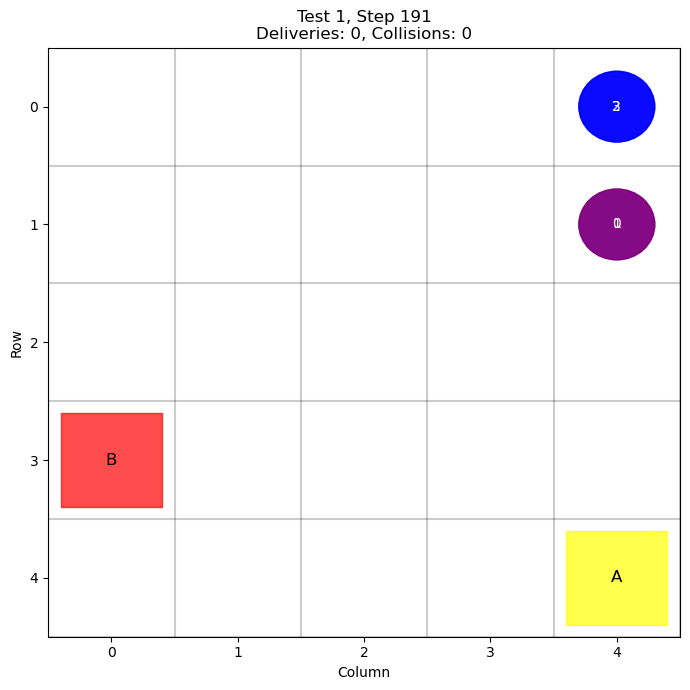

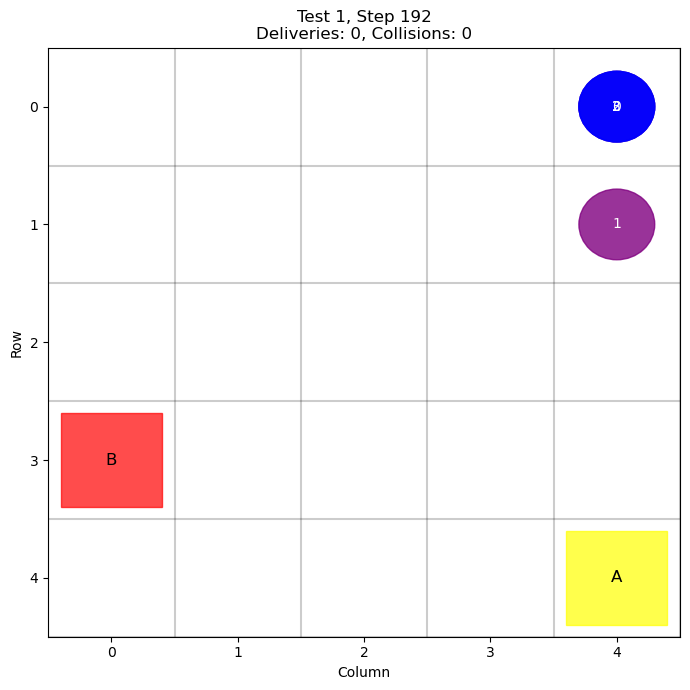

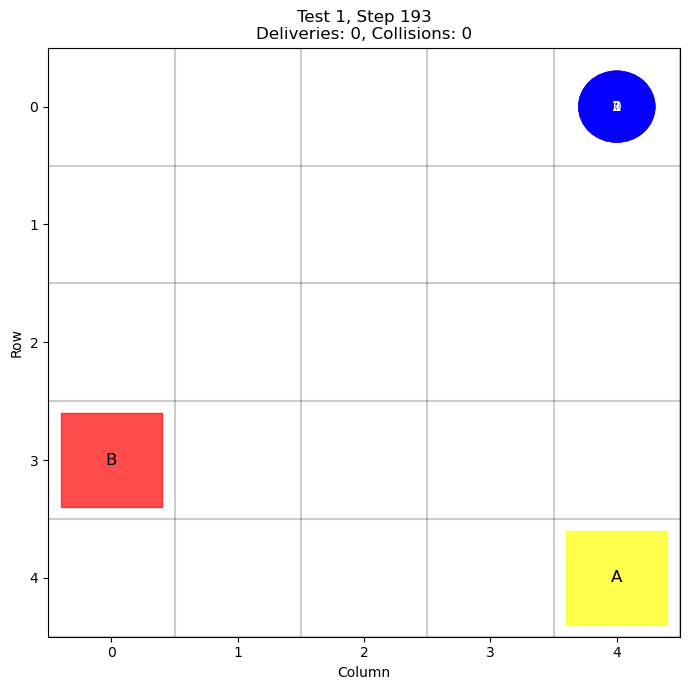

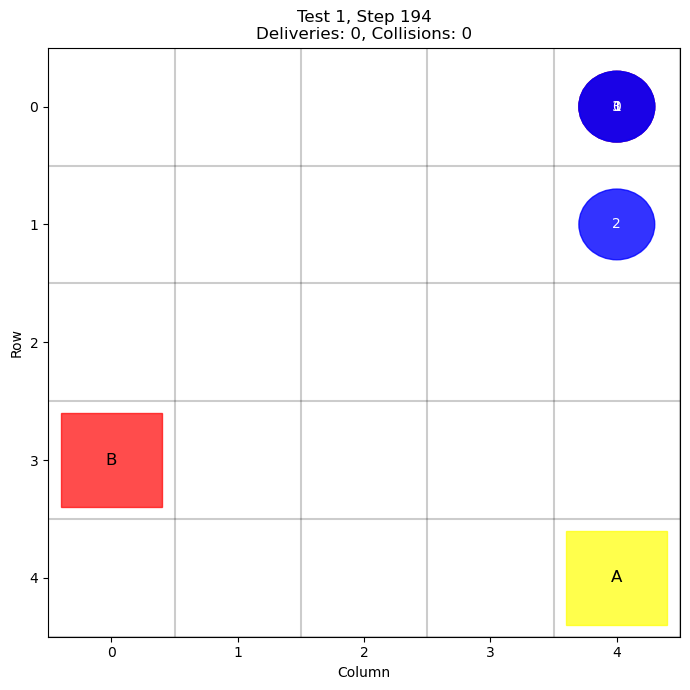

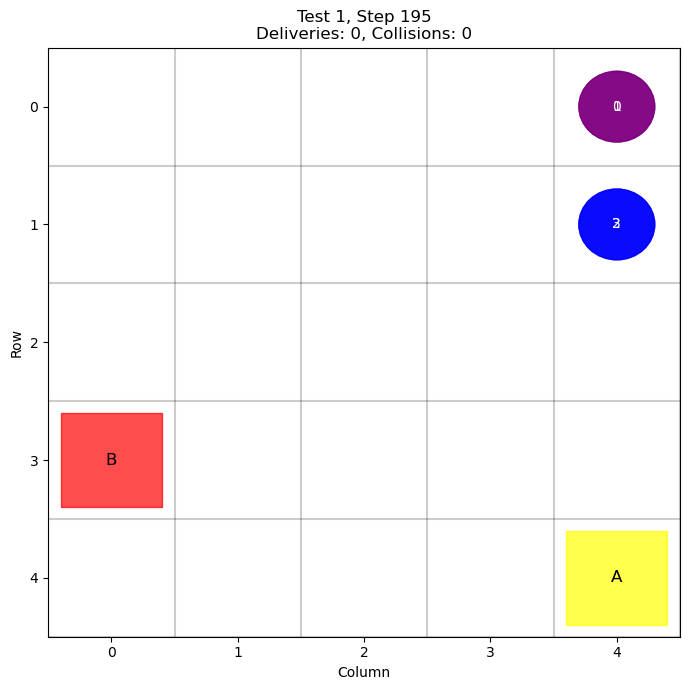

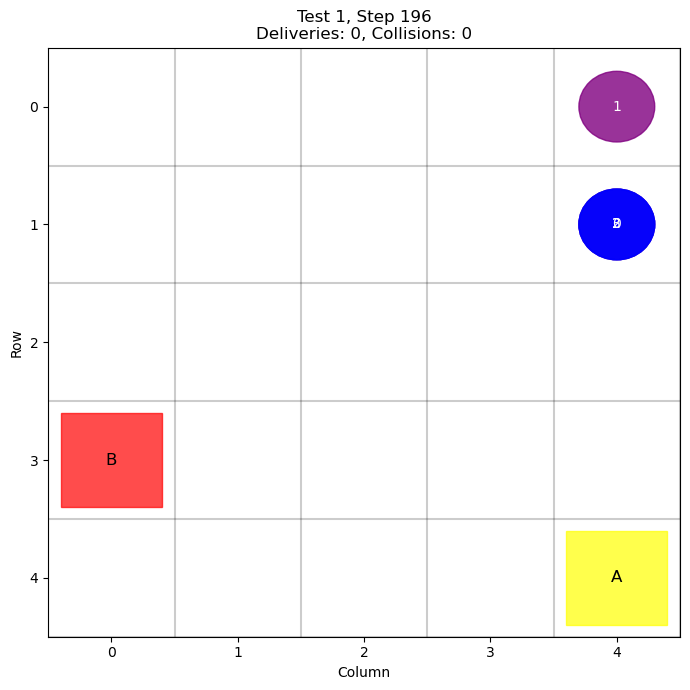

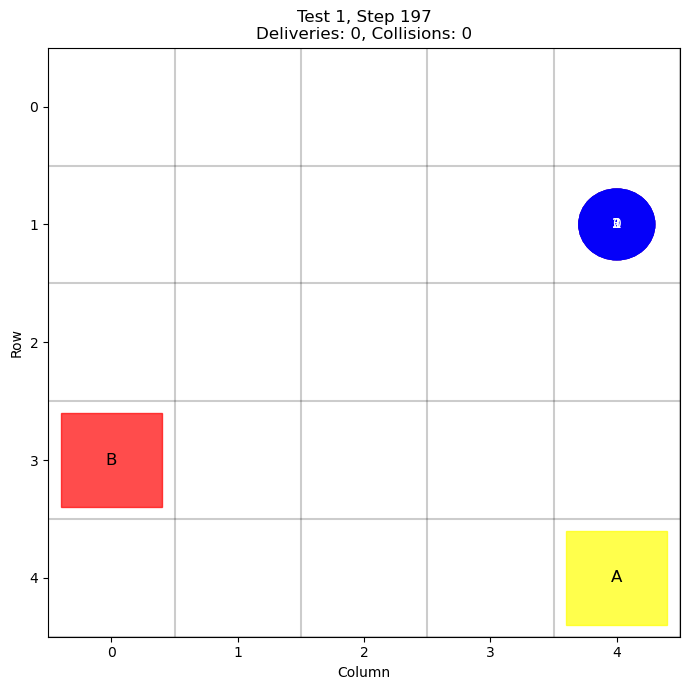

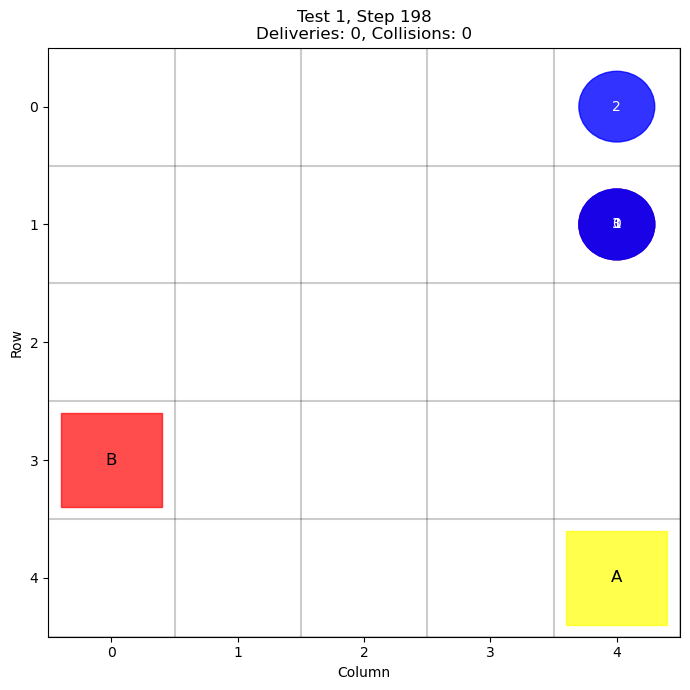

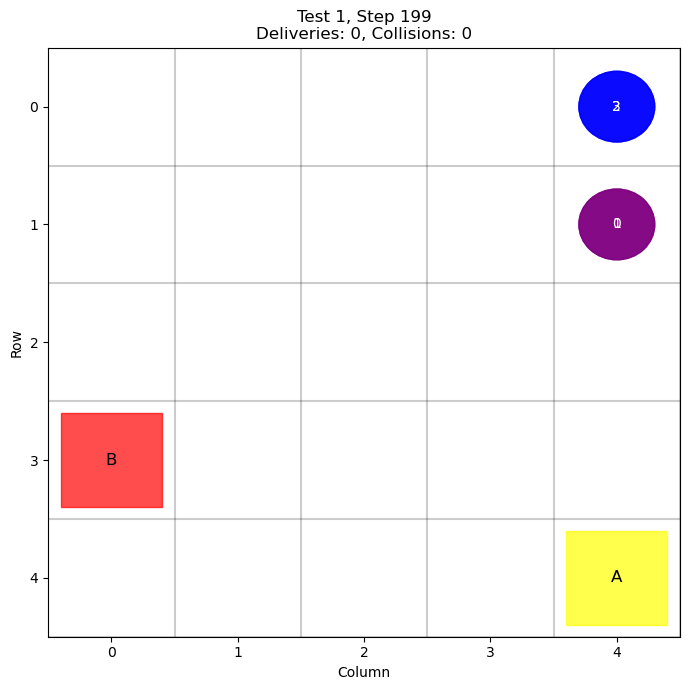

Test 1 Results: Deliveries=0, Collisions=0, Reward=-180

Overall Test Results:
Average Deliveries per Test: 0.00
Average Collisions per Test: 0.00
Average Reward per Test: -180.00


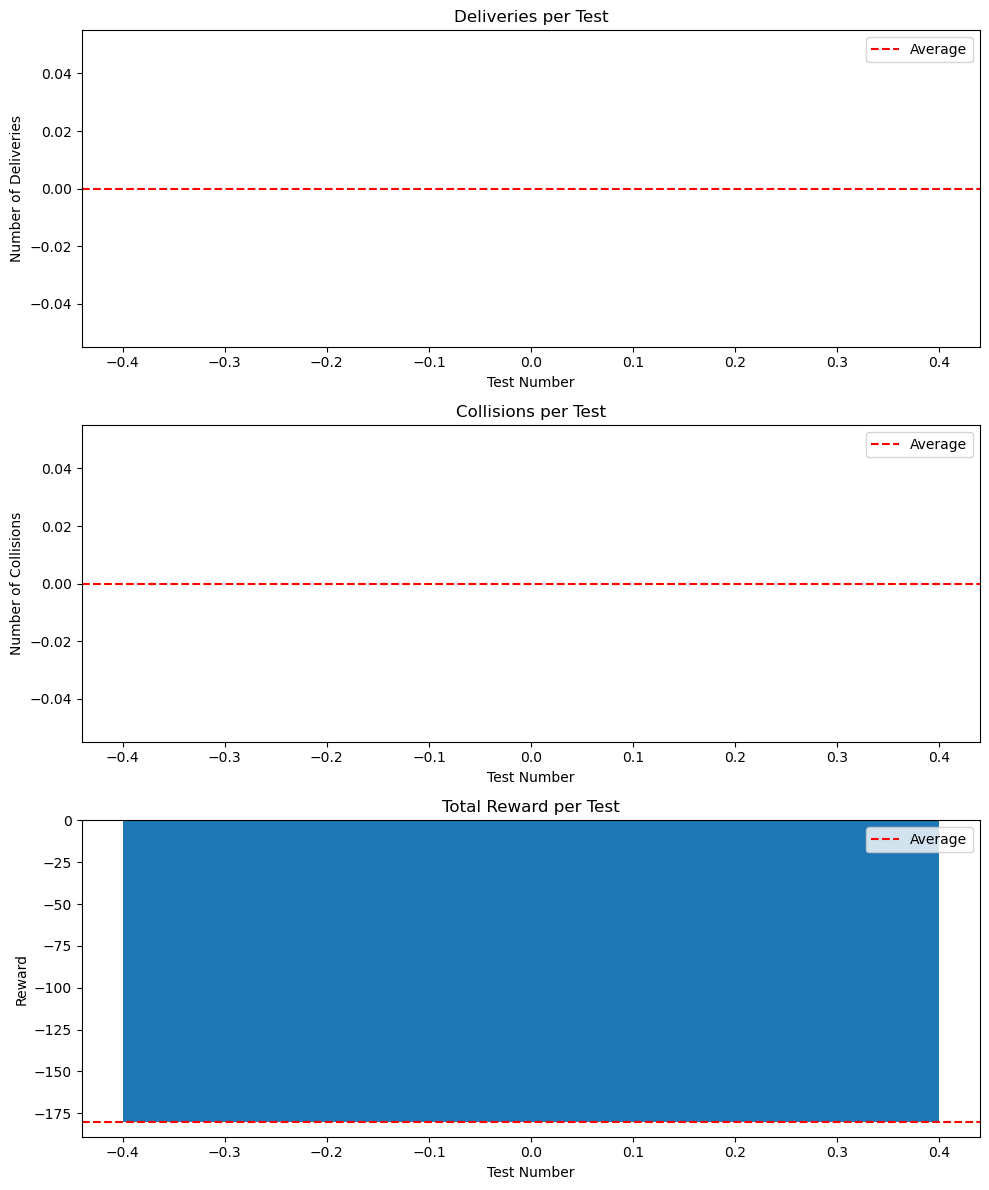

In [78]:
test_results = test_trained_agents_dqn(
    env,
    num_tests=1,           # Only one test
    steps_per_test=200,    # Or however many steps you want to watch
    render=True,
    render_delay=0.5,       # Adjust for your preference (0.3-1.0 seconds),
    show_all_steps=True
)